### run V-REP server

1. cd /Users/jack.lingheng.meng/GoogleDrive/Robot_Simulators/V-REP_PRO_EDU_V3_5_0_Mac
2. ./vrep.app/Contents/MacOS/vrep -h -s /Users/jack.lingheng.meng/GoogleDrive/Robot_Simulators/V-Rep-Python_Project_ASL/LAS_Gym/LAS-Scenes/livingArchitecture_singleVisitor_nondistributed.ttt

In [1]:
import tensorflow as tf
import numpy as np
import gym
from gym import wrappers
import tflearn
import argparse
import pprint as pp
from collections import deque

from IPython.core.debugger import Tracer

from Environment.LASEnv import LASEnv

from replay_buffer import ReplayBuffer

import matplotlib.pyplot as plt
def plot_cumulative_reward(cumulativeReward):
    line, = plt.plot(cumulativeReward)
    plt.ion()
    plt.show()
    plt.pause(0.0001)

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# ===========================
#   Actor and Critic DNNs
# ===========================

class ActorNetwork(object):
    """
    Input to the network is the state, output is the action
    under a deterministic policy.

    The output layer activation is a tanh to keep the action
    between -action_bound and action_bound
    """

    def __init__(self, sess, observation_space,  action_space, learning_rate, tau, batch_size):
        self.sess = sess
        self.s_dim = observation_space.shape[0]
        self.a_dim = action_space.shape[0]
        self.action_bound_high = action_space.high
        self.action_bound_low = action_space.low
        self.learning_rate = learning_rate
        self.tau = tau
        self.batch_size = batch_size

        # Actor Network
        self.inputs, self.out, self.scaled_out = self.create_actor_network()

        self.network_params = tf.trainable_variables()

        # Target Network
        self.target_inputs, self.target_out, self.target_scaled_out = self.create_actor_network()

        self.target_network_params = tf.trainable_variables()[
            len(self.network_params):]

        # Op for periodically updating target network with online network
        # weights
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) +
                                                  tf.multiply(self.target_network_params[i], 1. - self.tau))
                for i in range(len(self.target_network_params))]

        # This gradient will be provided by the critic network
        self.action_gradient = tf.placeholder(tf.float32, [None, self.a_dim])

        # Combine the gradients here
        self.unnormalized_actor_gradients = tf.gradients(
            self.scaled_out, self.network_params, -self.action_gradient)
        self.actor_gradients = list(map(lambda x: tf.div(x, self.batch_size), self.unnormalized_actor_gradients))

        # Optimization Op
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).\
            apply_gradients(zip(self.actor_gradients, self.network_params))

        self.num_trainable_vars = len(
            self.network_params) + len(self.target_network_params)

    def create_actor_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        net = tflearn.fully_connected(inputs, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        net = tflearn.fully_connected(net, 300)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        # Final layer weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(
            net, self.a_dim, activation='tanh', weights_init=w_init) # I don't understand why sigmoid worse than tanh
        # Scale output to -action_bound to action_bound
        scaled_out = tf.multiply(out, self.action_bound_high)
        return inputs, out, scaled_out

    def train(self, inputs, a_gradient):
        self.sess.run(self.optimize, feed_dict={
            self.inputs: inputs,
            self.action_gradient: a_gradient
        })

    def predict(self, inputs):
        return self.sess.run(self.scaled_out, feed_dict={
            self.inputs: inputs
        })

    def predict_target(self, inputs):
        return self.sess.run(self.target_scaled_out, feed_dict={
            self.target_inputs: inputs
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

    def get_num_trainable_vars(self):
        return self.num_trainable_vars

In [3]:
class CriticNetwork(object):
    """
    Input to the network is the state and action, output is Q(s,a).
    The action must be obtained from the output of the Actor network.

    """

    def __init__(self, sess, observation_space, action_space, learning_rate, tau, gamma, num_actor_vars):
        self.sess = sess
        self.s_dim = observation_space.shape[0]
        self.a_dim = action_space.shape[0]
        self.learning_rate = learning_rate
        self.tau = tau
        self.gamma = gamma

        # Create the critic network
        self.inputs, self.action, self.out = self.create_critic_network()

        self.network_params = tf.trainable_variables()[num_actor_vars:]

        # Target Network
        self.target_inputs, self.target_action, self.target_out = self.create_critic_network()

        self.target_network_params = tf.trainable_variables()[(len(self.network_params) + num_actor_vars):]

        # Op for periodically updating target network with online network
        # weights with regularization
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) \
            + tf.multiply(self.target_network_params[i], 1. - self.tau))
                for i in range(len(self.target_network_params))]

        # Network target (y_i)
        self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])

        # Define loss and optimization Op
        self.loss = tflearn.mean_square(self.predicted_q_value, self.out)
        self.optimize = tf.train.AdamOptimizer(
            self.learning_rate).minimize(self.loss)

        # Get the gradient of the net w.r.t. the action.
        # For each action in the minibatch (i.e., for each x in xs),
        # this will sum up the gradients of each critic output in the minibatch
        # w.r.t. that action. Each output is independent of all
        # actions except for one.
        self.action_grads = tf.gradients(self.out, self.action)

    def create_critic_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        action = tflearn.input_data(shape=[None, self.a_dim])
        net = tflearn.fully_connected(inputs, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)

        # Add the action tensor in the 2nd hidden layer
        # Use two temp layers to get the corresponding weights and biases
        t1 = tflearn.fully_connected(net, 300)
        t2 = tflearn.fully_connected(action, 300)

        net = tflearn.activation(
            tf.matmul(net, t1.W) + tf.matmul(action, t2.W) + t2.b, activation='relu')

        # linear layer connected to 1 output representing Q(s,a)
        # Weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(net, 1, weights_init=w_init)
        return inputs, action, out

    def train(self, inputs, action, predicted_q_value):
        return self.sess.run([self.out, self.optimize], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })

    def predict(self, inputs, action):
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs,
            self.action: action
        })

    def predict_target(self, inputs, action):
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs,
            self.target_action: action
        })

    def action_gradients(self, inputs, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.inputs: inputs,
            self.action: actions
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

In [4]:
# Taken from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py, which is
# based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [5]:
class LASAgent_Actor_Critic():
    def __init__(self, sess, env):
        self.sess = sess
        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space 
        
        # Actor
        self.minibatch_size = 64
        self.actor_lr = 0.0001
        self.actor_tau = 0.001
        self.actor_model = ActorNetwork(sess, 
                                        self.observation_space, 
                                        self.action_space,
                                        self.actor_lr, 
                                        self.actor_tau,
                                        self.minibatch_size)
        # Critic
        self.critic_lr = 0.0001
        self.critic_tau = 0.001
        self.gamma = 0.99
        self.critic_model = CriticNetwork(sess,
                                          self.observation_space,
                                          self.action_space,
                                          self.critic_lr,
                                          self.critic_tau,
                                          self.gamma,
                                          self.actor_model.get_num_trainable_vars())
        # Actor noise to maintain exploration
        self.actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(self.action_space.shape[0]))
        
        # Training Hyper-parameters and initialization
        self.max_episodes = 50000
        self.max_episode_len = 1000
        self.render_env = False
        
        self.sess.run(tf.global_variables_initializer())
        self.actor_model.update_target_network()
        self.critic_model.update_target_network()
        
        # Reply buffer
        self.buffer_size = 1000000
        self.random_seed = 1234
        self.replay_buffer = ReplayBuffer(self.buffer_size, self.random_seed)
        
        # Episod reward memory
        self.episod_reward_memory = deque(maxlen = 10000)
        
    # ===========================
    #   Agent Training
    # ===========================
    
    def train(self):
        # Needed to enable BatchNorm. 
        # This hurts the performance on Pendulum but could be useful
        # in other environments.
        # tflearn.is_training(True)
    
        for i in range(self.max_episodes):
    
            s = self.env.reset()
    
            ep_reward = 0
            ep_ave_max_q = 0
    
            for j in range(self.max_episode_len):
    
                if self.render_env:
                    self.env.render()
    
                # Added exploration noise
                a = self.actor_model.predict(np.reshape(s, (1, self.actor_model.s_dim))) + self.actor_noise()
    
                s2, r, terminal, info = self.env.step(a[0])
                print("Episod:{}, Step: {}, reward: {}".format(i, j, r))
                
                self.replay_buffer.add(np.reshape(s, (self.actor_model.s_dim,)), 
                                       np.reshape(a, (self.actor_model.a_dim,)), 
                                       r,
                                       terminal,
                                       np.reshape(s2, (self.actor_model.s_dim,)))
    
                # Keep adding experience to the memory until
                # there are at least minibatch size samples
                if self.replay_buffer.size() > self.minibatch_size:
                    s_batch, a_batch, r_batch, t_batch, s2_batch = \
                        self.replay_buffer.sample_batch(int(self.minibatch_size))
    
                    # Calculate targets
                    target_q = self.critic_model.predict_target(
                        s2_batch, self.actor_model.predict_target(s2_batch))
    
                    y_i = []
                    for k in range(int(self.minibatch_size)):
                        if t_batch[k]:
                            y_i.append(r_batch[k])
                        else:
                            y_i.append(r_batch[k] + self.critic_model.gamma * target_q[k])
    
                    # Update the critic given the targets
                    predicted_q_value, _ = self.critic_model.train(
                        s_batch, a_batch, np.reshape(y_i, (int(self.minibatch_size), 1)))
    
                    ep_ave_max_q += np.amax(predicted_q_value)
    
                    # Update the actor policy using the sampled gradient
                    a_outs = self.actor_model.predict(s_batch)
                    grads = self.critic_model.action_gradients(s_batch, a_outs)
                    self.actor_model.train(s_batch, grads[0])
    
                    # Update target networks
                    self.actor_model.update_target_network()
                    self.critic_model.update_target_network()
    
                s = s2
                ep_reward += r
    
                if terminal or j == (self.max_episode_len-1):
                    print('| Reward: {:d} | Episode: {:d} | Qmax: {:.4f}'.format(int(ep_reward), \
                            i, (ep_ave_max_q / float(j))))
                    self.episod_reward_memory.append(ep_reward)
                    plot_cumulative_reward(self.episod_reward_memory)
                    break

Initialize LASEnv ...
LASEnv connected to remote V-REP API server
Get objects' names and handles ...
Get Prox Sensor Success!!!!!
Proximity Sensor: ir_3_node#0, and handle: 16
Proximity Sensor: ir_2_node#0, and handle: 17
Proximity Sensor: ir_1_node#0, and handle: 18
Proximity Sensor: ir_3_node#1, and handle: 30
Proximity Sensor: ir_2_node#1, and handle: 31
Proximity Sensor: ir_1_node#1, and handle: 32
Proximity Sensor: ir_3_node#2, and handle: 44
Proximity Sensor: ir_2_node#2, and handle: 45
Proximity Sensor: ir_1_node#2, and handle: 46
Proximity Sensor: ir_3_node#3, and handle: 58
Proximity Sensor: ir_2_node#3, and handle: 59
Proximity Sensor: ir_1_node#3, and handle: 60
Proximity Sensor: ir_3_node#4, and handle: 72
Proximity Sensor: ir_2_node#4, and handle: 73
Proximity Sensor: ir_1_node#4, and handle: 74
Proximity Sensor: ir_3_node#5, and handle: 86
Proximity Sensor: ir_2_node#5, and handle: 87
Proximity Sensor: ir_1_node#5, and handle: 88
Proximity Sensor: ir_3_node#6, and handle:

/Users/jack.lingheng.meng/GoogleDrive/Robot_Simulators/V-Rep-Python_Project_ASL/LAS_Gym/Environment/LASEnv.py:451: UserWarning: Remote function call: getLightStateAndColor fail in Class AnyLight.
  warnings.warn("Remote function call: getLightStateAndColor fail in Class AnyLight.")


Episod:0, Step: 0, reward: 0
Episod:0, Step: 1, reward: 0
Episod:0, Step: 2, reward: 0
Episod:0, Step: 3, reward: 0
Episod:0, Step: 4, reward: 0
Episod:0, Step: 5, reward: 0
Episod:0, Step: 6, reward: 0
Episod:0, Step: 7, reward: 0
Episod:0, Step: 8, reward: 0
Episod:0, Step: 9, reward: 0
Episod:0, Step: 10, reward: 0
Episod:0, Step: 11, reward: 0
Episod:0, Step: 12, reward: 0
Episod:0, Step: 13, reward: 0
Episod:0, Step: 14, reward: 0
Episod:0, Step: 15, reward: 0
Episod:0, Step: 16, reward: 0
Episod:0, Step: 17, reward: 0
Episod:0, Step: 18, reward: 0
Episod:0, Step: 19, reward: 0
Episod:0, Step: 20, reward: 0
Episod:0, Step: 21, reward: 0
Episod:0, Step: 22, reward: 0
Episod:0, Step: 23, reward: 0
Episod:0, Step: 24, reward: 0
Episod:0, Step: 25, reward: 0
Episod:0, Step: 26, reward: 0
Episod:0, Step: 27, reward: 0
Episod:0, Step: 28, reward: 0
Episod:0, Step: 29, reward: 0
Episod:0, Step: 30, reward: 0
Episod:0, Step: 31, reward: 0
Episod:0, Step: 32, reward: 0
Episod:0, Step: 33, 

Episod:0, Step: 265, reward: 0
Episod:0, Step: 266, reward: 0
Episod:0, Step: 267, reward: 0
Episod:0, Step: 268, reward: 0
Episod:0, Step: 269, reward: 0
Episod:0, Step: 270, reward: 0
Episod:0, Step: 271, reward: 0
Episod:0, Step: 272, reward: 0
Episod:0, Step: 273, reward: 0
Episod:0, Step: 274, reward: 0
Episod:0, Step: 275, reward: 0
Episod:0, Step: 276, reward: 0
Episod:0, Step: 277, reward: 0.1
Episod:0, Step: 278, reward: 0
Episod:0, Step: 279, reward: 0
Episod:0, Step: 280, reward: 0
Episod:0, Step: 281, reward: 0
Episod:0, Step: 282, reward: 0
Episod:0, Step: 283, reward: 0.1
Episod:0, Step: 284, reward: 0.1
Episod:0, Step: 285, reward: 0.1
Episod:0, Step: 286, reward: 0.1
Episod:0, Step: 287, reward: 0.1
Episod:0, Step: 288, reward: 0.1
Episod:0, Step: 289, reward: 0
Episod:0, Step: 290, reward: 0
Episod:0, Step: 291, reward: 0
Episod:0, Step: 292, reward: 0
Episod:0, Step: 293, reward: 0
Episod:0, Step: 294, reward: 0
Episod:0, Step: 295, reward: 0
Episod:0, Step: 296, rewa

Episod:0, Step: 521, reward: 0.1
Episod:0, Step: 522, reward: 0.1
Episod:0, Step: 523, reward: 0.1
Episod:0, Step: 524, reward: 0.1
Episod:0, Step: 525, reward: 0.1
Episod:0, Step: 526, reward: 0.1
Episod:0, Step: 527, reward: 0.1
Episod:0, Step: 528, reward: 0.1
Episod:0, Step: 529, reward: 0.1
Episod:0, Step: 530, reward: 0.1
Episod:0, Step: 531, reward: 0.1
Episod:0, Step: 532, reward: 0.1
Episod:0, Step: 533, reward: 0.1
Episod:0, Step: 534, reward: 0.1
Episod:0, Step: 535, reward: 0.1
Episod:0, Step: 536, reward: 0.1
Episod:0, Step: 537, reward: 0.1
Episod:0, Step: 538, reward: 0.1
Episod:0, Step: 539, reward: 0.1
Episod:0, Step: 540, reward: 0.1
Episod:0, Step: 541, reward: 0.1
Episod:0, Step: 542, reward: 0.1
Episod:0, Step: 543, reward: 0.1
Episod:0, Step: 544, reward: 0.1
Episod:0, Step: 545, reward: 0.1
Episod:0, Step: 546, reward: 0.1
Episod:0, Step: 547, reward: 0.1
Episod:0, Step: 548, reward: 0.1
Episod:0, Step: 549, reward: 0.1
Episod:0, Step: 550, reward: 0.1
Episod:0, 

Episod:0, Step: 777, reward: 0.1
Episod:0, Step: 778, reward: 0.1
Episod:0, Step: 779, reward: 0.1
Episod:0, Step: 780, reward: 0.1
Episod:0, Step: 781, reward: 0.1
Episod:0, Step: 782, reward: 0.1
Episod:0, Step: 783, reward: 0.1
Episod:0, Step: 784, reward: 0.1
Episod:0, Step: 785, reward: 0.1
Episod:0, Step: 786, reward: 0.1
Episod:0, Step: 787, reward: 0.1
Episod:0, Step: 788, reward: 0.1
Episod:0, Step: 789, reward: 0.1
Episod:0, Step: 790, reward: 0.1
Episod:0, Step: 791, reward: 0.1
Episod:0, Step: 792, reward: 0.1
Episod:0, Step: 793, reward: 0.1
Episod:0, Step: 794, reward: 0.1
Episod:0, Step: 795, reward: 0.1
Episod:0, Step: 796, reward: 0.1
Episod:0, Step: 797, reward: 0.1
Episod:0, Step: 798, reward: 0.1
Episod:0, Step: 799, reward: 0.1
Episod:0, Step: 800, reward: 0.1
Episod:0, Step: 801, reward: 0.1
Episod:0, Step: 802, reward: 0.1
Episod:0, Step: 803, reward: 0.1
Episod:0, Step: 804, reward: 0.1
Episod:0, Step: 805, reward: 0.1
Episod:0, Step: 806, reward: 0.1
Episod:0, 

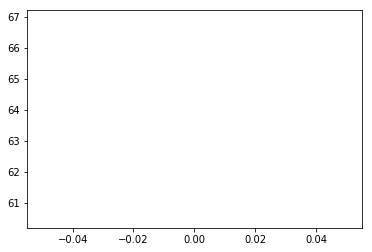

Episod:1, Step: 0, reward: 0
Episod:1, Step: 1, reward: 0
Episod:1, Step: 2, reward: 0
Episod:1, Step: 3, reward: 0
Episod:1, Step: 4, reward: 0
Episod:1, Step: 5, reward: 0
Episod:1, Step: 6, reward: 0
Episod:1, Step: 7, reward: 0
Episod:1, Step: 8, reward: 0
Episod:1, Step: 9, reward: 0
Episod:1, Step: 10, reward: 0
Episod:1, Step: 11, reward: 0
Episod:1, Step: 12, reward: 0
Episod:1, Step: 13, reward: 0
Episod:1, Step: 14, reward: 0
Episod:1, Step: 15, reward: 0
Episod:1, Step: 16, reward: 0
Episod:1, Step: 17, reward: 0
Episod:1, Step: 18, reward: 0
Episod:1, Step: 19, reward: 0
Episod:1, Step: 20, reward: 0.1
Episod:1, Step: 21, reward: 0.1
Episod:1, Step: 22, reward: 0.1
Episod:1, Step: 23, reward: 0.1
Episod:1, Step: 24, reward: 0.1
Episod:1, Step: 25, reward: 0.1
Episod:1, Step: 26, reward: 0.1
Episod:1, Step: 27, reward: 0
Episod:1, Step: 28, reward: 0
Episod:1, Step: 29, reward: 0
Episod:1, Step: 30, reward: 0
Episod:1, Step: 31, reward: 0
Episod:1, Step: 32, reward: 0.1
Epis

Episod:1, Step: 256, reward: 0
Episod:1, Step: 257, reward: 0
Episod:1, Step: 258, reward: 0
Episod:1, Step: 259, reward: 0
Episod:1, Step: 260, reward: 0
Episod:1, Step: 261, reward: 0
Episod:1, Step: 262, reward: 0
Episod:1, Step: 263, reward: 0
Episod:1, Step: 264, reward: 0
Episod:1, Step: 265, reward: 0
Episod:1, Step: 266, reward: 0
Episod:1, Step: 267, reward: 0
Episod:1, Step: 268, reward: 0
Episod:1, Step: 269, reward: 0
Episod:1, Step: 270, reward: 0
Episod:1, Step: 271, reward: 0
Episod:1, Step: 272, reward: 0
Episod:1, Step: 273, reward: 0
Episod:1, Step: 274, reward: 0
Episod:1, Step: 275, reward: 0
Episod:1, Step: 276, reward: 0
Episod:1, Step: 277, reward: 0.1
Episod:1, Step: 278, reward: 0.1
Episod:1, Step: 279, reward: 0.1
Episod:1, Step: 280, reward: 0.1
Episod:1, Step: 281, reward: 0.1
Episod:1, Step: 282, reward: 0.1
Episod:1, Step: 283, reward: 0.1
Episod:1, Step: 284, reward: 0.1
Episod:1, Step: 285, reward: 0.1
Episod:1, Step: 286, reward: 0
Episod:1, Step: 287, 

Episod:1, Step: 520, reward: 0
Episod:1, Step: 521, reward: 0
Episod:1, Step: 522, reward: 0
Episod:1, Step: 523, reward: 0
Episod:1, Step: 524, reward: 0
Episod:1, Step: 525, reward: 0
Episod:1, Step: 526, reward: 0
Episod:1, Step: 527, reward: 0
Episod:1, Step: 528, reward: 0
Episod:1, Step: 529, reward: 0
Episod:1, Step: 530, reward: 0
Episod:1, Step: 531, reward: 0
Episod:1, Step: 532, reward: 0
Episod:1, Step: 533, reward: 0
Episod:1, Step: 534, reward: 0
Episod:1, Step: 535, reward: 0
Episod:1, Step: 536, reward: 0
Episod:1, Step: 537, reward: 0
Episod:1, Step: 538, reward: 0
Episod:1, Step: 539, reward: 0
Episod:1, Step: 540, reward: 0
Episod:1, Step: 541, reward: 0
Episod:1, Step: 542, reward: 0
Episod:1, Step: 543, reward: 0
Episod:1, Step: 544, reward: 0
Episod:1, Step: 545, reward: 0
Episod:1, Step: 546, reward: 0
Episod:1, Step: 547, reward: 0
Episod:1, Step: 548, reward: 0
Episod:1, Step: 549, reward: 0
Episod:1, Step: 550, reward: 0
Episod:1, Step: 551, reward: 0
Episod:1

Episod:1, Step: 775, reward: 0.1
Episod:1, Step: 776, reward: 0.1
Episod:1, Step: 777, reward: 0.1
Episod:1, Step: 778, reward: 0.1
Episod:1, Step: 779, reward: 0.1
Episod:1, Step: 780, reward: 0.1
Episod:1, Step: 781, reward: 0.1
Episod:1, Step: 782, reward: 0.1
Episod:1, Step: 783, reward: 0.1
Episod:1, Step: 784, reward: 0.1
Episod:1, Step: 785, reward: 0.1
Episod:1, Step: 786, reward: 0.1
Episod:1, Step: 787, reward: 0.1
Episod:1, Step: 788, reward: 0.1
Episod:1, Step: 789, reward: 0.1
Episod:1, Step: 790, reward: 0.1
Episod:1, Step: 791, reward: 0.1
Episod:1, Step: 792, reward: 0.1
Episod:1, Step: 793, reward: 0
Episod:1, Step: 794, reward: 0
Episod:1, Step: 795, reward: 0
Episod:1, Step: 796, reward: 0
Episod:1, Step: 797, reward: 0
Episod:1, Step: 798, reward: 0
Episod:1, Step: 799, reward: 0
Episod:1, Step: 800, reward: 0
Episod:1, Step: 801, reward: 0
Episod:1, Step: 802, reward: 0
Episod:1, Step: 803, reward: 0
Episod:1, Step: 804, reward: 0
Episod:1, Step: 805, reward: 0
Epi

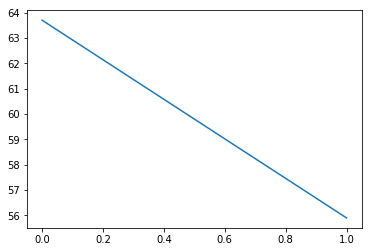

Episod:2, Step: 0, reward: 0.1
Episod:2, Step: 1, reward: 0.1
Episod:2, Step: 2, reward: 0.1
Episod:2, Step: 3, reward: 0.1
Episod:2, Step: 4, reward: 0.1
Episod:2, Step: 5, reward: 0.1
Episod:2, Step: 6, reward: 0.1
Episod:2, Step: 7, reward: 0.1
Episod:2, Step: 8, reward: 0.1
Episod:2, Step: 9, reward: 0.1
Episod:2, Step: 10, reward: 0.1
Episod:2, Step: 11, reward: 0.1
Episod:2, Step: 12, reward: 0.1
Episod:2, Step: 13, reward: 0.1
Episod:2, Step: 14, reward: 0.1
Episod:2, Step: 15, reward: 0.1
Episod:2, Step: 16, reward: 0.1
Episod:2, Step: 17, reward: 0.1
Episod:2, Step: 18, reward: 0.1
Episod:2, Step: 19, reward: 0.1
Episod:2, Step: 20, reward: 0.1
Episod:2, Step: 21, reward: 0.1
Episod:2, Step: 22, reward: 0.1
Episod:2, Step: 23, reward: 0.1
Episod:2, Step: 24, reward: 0.1
Episod:2, Step: 25, reward: 0.1
Episod:2, Step: 26, reward: 0.1
Episod:2, Step: 27, reward: 0.1
Episod:2, Step: 28, reward: 0.1
Episod:2, Step: 29, reward: 0.1
Episod:2, Step: 30, reward: 0.1
Episod:2, Step: 31

Episod:2, Step: 255, reward: 0.1
Episod:2, Step: 256, reward: 0.1
Episod:2, Step: 257, reward: 0.1
Episod:2, Step: 258, reward: 0.1
Episod:2, Step: 259, reward: 0.1
Episod:2, Step: 260, reward: 0.1
Episod:2, Step: 261, reward: 0.1
Episod:2, Step: 262, reward: 0.1
Episod:2, Step: 263, reward: 0
Episod:2, Step: 264, reward: 0
Episod:2, Step: 265, reward: 0
Episod:2, Step: 266, reward: 0
Episod:2, Step: 267, reward: 0
Episod:2, Step: 268, reward: 0
Episod:2, Step: 269, reward: 0
Episod:2, Step: 270, reward: 0
Episod:2, Step: 271, reward: 0
Episod:2, Step: 272, reward: 0
Episod:2, Step: 273, reward: 0
Episod:2, Step: 274, reward: 0
Episod:2, Step: 275, reward: 0
Episod:2, Step: 276, reward: 0
Episod:2, Step: 277, reward: 0
Episod:2, Step: 278, reward: 0
Episod:2, Step: 279, reward: 0
Episod:2, Step: 280, reward: 0
Episod:2, Step: 281, reward: 0
Episod:2, Step: 282, reward: 0
Episod:2, Step: 283, reward: 0
Episod:2, Step: 284, reward: 0
Episod:2, Step: 285, reward: 0
Episod:2, Step: 286, re

Episod:2, Step: 512, reward: 0
Episod:2, Step: 513, reward: 0
Episod:2, Step: 514, reward: 0
Episod:2, Step: 515, reward: 0
Episod:2, Step: 516, reward: 0
Episod:2, Step: 517, reward: 0
Episod:2, Step: 518, reward: 0
Episod:2, Step: 519, reward: 0
Episod:2, Step: 520, reward: 0
Episod:2, Step: 521, reward: 0
Episod:2, Step: 522, reward: 0
Episod:2, Step: 523, reward: 0
Episod:2, Step: 524, reward: 0
Episod:2, Step: 525, reward: 0
Episod:2, Step: 526, reward: 0
Episod:2, Step: 527, reward: 0
Episod:2, Step: 528, reward: 0
Episod:2, Step: 529, reward: 0
Episod:2, Step: 530, reward: 0
Episod:2, Step: 531, reward: 0
Episod:2, Step: 532, reward: 0
Episod:2, Step: 533, reward: 0
Episod:2, Step: 534, reward: 0
Episod:2, Step: 535, reward: 0
Episod:2, Step: 536, reward: 0
Episod:2, Step: 537, reward: 0
Episod:2, Step: 538, reward: 0
Episod:2, Step: 539, reward: 0
Episod:2, Step: 540, reward: 0
Episod:2, Step: 541, reward: 0
Episod:2, Step: 542, reward: 0
Episod:2, Step: 543, reward: 0
Episod:2

Episod:2, Step: 774, reward: 0
Episod:2, Step: 775, reward: 0
Episod:2, Step: 776, reward: 0
Episod:2, Step: 777, reward: 0
Episod:2, Step: 778, reward: 0
Episod:2, Step: 779, reward: 0
Episod:2, Step: 780, reward: 0
Episod:2, Step: 781, reward: 0
Episod:2, Step: 782, reward: 0
Episod:2, Step: 783, reward: 0
Episod:2, Step: 784, reward: 0
Episod:2, Step: 785, reward: 0
Episod:2, Step: 786, reward: 0
Episod:2, Step: 787, reward: 0
Episod:2, Step: 788, reward: 0
Episod:2, Step: 789, reward: 0
Episod:2, Step: 790, reward: 0
Episod:2, Step: 791, reward: 0
Episod:2, Step: 792, reward: 0
Episod:2, Step: 793, reward: 0
Episod:2, Step: 794, reward: 0
Episod:2, Step: 795, reward: 0
Episod:2, Step: 796, reward: 0
Episod:2, Step: 797, reward: 0
Episod:2, Step: 798, reward: 0
Episod:2, Step: 799, reward: 0
Episod:2, Step: 800, reward: 0
Episod:2, Step: 801, reward: 0
Episod:2, Step: 802, reward: 0
Episod:2, Step: 803, reward: 0
Episod:2, Step: 804, reward: 0
Episod:2, Step: 805, reward: 0
Episod:2

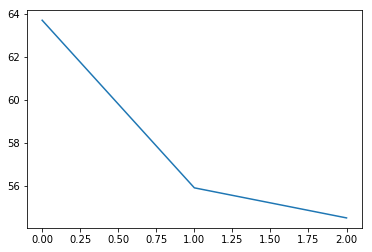

Episod:3, Step: 0, reward: 0.1
Episod:3, Step: 1, reward: 0.1
Episod:3, Step: 2, reward: 0.1
Episod:3, Step: 3, reward: 0.1
Episod:3, Step: 4, reward: 0.1
Episod:3, Step: 5, reward: 0.1
Episod:3, Step: 6, reward: 0.1
Episod:3, Step: 7, reward: 0.1
Episod:3, Step: 8, reward: 0.1
Episod:3, Step: 9, reward: 0.1
Episod:3, Step: 10, reward: 0.1
Episod:3, Step: 11, reward: 0.1
Episod:3, Step: 12, reward: 0
Episod:3, Step: 13, reward: 0
Episod:3, Step: 14, reward: 0
Episod:3, Step: 15, reward: 0
Episod:3, Step: 16, reward: 0
Episod:3, Step: 17, reward: 0
Episod:3, Step: 18, reward: 0
Episod:3, Step: 19, reward: 0
Episod:3, Step: 20, reward: 0
Episod:3, Step: 21, reward: 0
Episod:3, Step: 22, reward: 0
Episod:3, Step: 23, reward: 0
Episod:3, Step: 24, reward: 0
Episod:3, Step: 25, reward: 0
Episod:3, Step: 26, reward: 0
Episod:3, Step: 27, reward: 0
Episod:3, Step: 28, reward: 0
Episod:3, Step: 29, reward: 0
Episod:3, Step: 30, reward: 0
Episod:3, Step: 31, reward: 0
Episod:3, Step: 32, reward

Episod:3, Step: 267, reward: 0.1
Episod:3, Step: 268, reward: 0.1
Episod:3, Step: 269, reward: 0.1
Episod:3, Step: 270, reward: 0.1
Episod:3, Step: 271, reward: 0.1
Episod:3, Step: 272, reward: 0.1
Episod:3, Step: 273, reward: 0.1
Episod:3, Step: 274, reward: 0.1
Episod:3, Step: 275, reward: 0.1
Episod:3, Step: 276, reward: 0.1
Episod:3, Step: 277, reward: 0.1
Episod:3, Step: 278, reward: 0.1
Episod:3, Step: 279, reward: 0
Episod:3, Step: 280, reward: 0
Episod:3, Step: 281, reward: 0
Episod:3, Step: 282, reward: 0
Episod:3, Step: 283, reward: 0
Episod:3, Step: 284, reward: 0
Episod:3, Step: 285, reward: 0
Episod:3, Step: 286, reward: 0
Episod:3, Step: 287, reward: 0
Episod:3, Step: 288, reward: 0
Episod:3, Step: 289, reward: 0
Episod:3, Step: 290, reward: 0
Episod:3, Step: 291, reward: 0
Episod:3, Step: 292, reward: 0
Episod:3, Step: 293, reward: 0
Episod:3, Step: 294, reward: 0
Episod:3, Step: 295, reward: 0
Episod:3, Step: 296, reward: 0
Episod:3, Step: 297, reward: 0
Episod:3, Step:

Episod:3, Step: 533, reward: 0
Episod:3, Step: 534, reward: 0
Episod:3, Step: 535, reward: 0
Episod:3, Step: 536, reward: 0
Episod:3, Step: 537, reward: 0
Episod:3, Step: 538, reward: 0
Episod:3, Step: 539, reward: 0
Episod:3, Step: 540, reward: 0
Episod:3, Step: 541, reward: 0
Episod:3, Step: 542, reward: 0
Episod:3, Step: 543, reward: 0
Episod:3, Step: 544, reward: 0
Episod:3, Step: 545, reward: 0
Episod:3, Step: 546, reward: 0
Episod:3, Step: 547, reward: 0
Episod:3, Step: 548, reward: 0
Episod:3, Step: 549, reward: 0
Episod:3, Step: 550, reward: 0
Episod:3, Step: 551, reward: 0
Episod:3, Step: 552, reward: 0
Episod:3, Step: 553, reward: 0
Episod:3, Step: 554, reward: 0
Episod:3, Step: 555, reward: 0
Episod:3, Step: 556, reward: 0
Episod:3, Step: 557, reward: 0
Episod:3, Step: 558, reward: 0
Episod:3, Step: 559, reward: 0
Episod:3, Step: 560, reward: 0
Episod:3, Step: 561, reward: 0
Episod:3, Step: 562, reward: 0
Episod:3, Step: 563, reward: 0
Episod:3, Step: 564, reward: 0
Episod:3

Episod:3, Step: 799, reward: 0
Episod:3, Step: 800, reward: 0
Episod:3, Step: 801, reward: 0
Episod:3, Step: 802, reward: 0
Episod:3, Step: 803, reward: 0
Episod:3, Step: 804, reward: 0
Episod:3, Step: 805, reward: 0
Episod:3, Step: 806, reward: 0
Episod:3, Step: 807, reward: 0
Episod:3, Step: 808, reward: 0
Episod:3, Step: 809, reward: 0
Episod:3, Step: 810, reward: 0
Episod:3, Step: 811, reward: 0
Episod:3, Step: 812, reward: 0
Episod:3, Step: 813, reward: 0
Episod:3, Step: 814, reward: 0
Episod:3, Step: 815, reward: 0
Episod:3, Step: 816, reward: 0
Episod:3, Step: 817, reward: 0
Episod:3, Step: 818, reward: 0
Episod:3, Step: 819, reward: 0
Episod:3, Step: 820, reward: 0
Episod:3, Step: 821, reward: 0
Episod:3, Step: 822, reward: 0
Episod:3, Step: 823, reward: 0
Episod:3, Step: 824, reward: 0
Episod:3, Step: 825, reward: 0
Episod:3, Step: 826, reward: 0
Episod:3, Step: 827, reward: 0
Episod:3, Step: 828, reward: 0
Episod:3, Step: 829, reward: 0
Episod:3, Step: 830, reward: 0
Episod:3

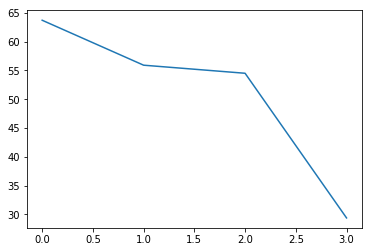

Episod:4, Step: 0, reward: 0
Episod:4, Step: 1, reward: 0
Episod:4, Step: 2, reward: 0
Episod:4, Step: 3, reward: 0
Episod:4, Step: 4, reward: 0
Episod:4, Step: 5, reward: 0
Episod:4, Step: 6, reward: 0
Episod:4, Step: 7, reward: 0
Episod:4, Step: 8, reward: 0
Episod:4, Step: 9, reward: 0
Episod:4, Step: 10, reward: 0
Episod:4, Step: 11, reward: 0
Episod:4, Step: 12, reward: 0
Episod:4, Step: 13, reward: 0
Episod:4, Step: 14, reward: 0
Episod:4, Step: 15, reward: 0
Episod:4, Step: 16, reward: 0
Episod:4, Step: 17, reward: 0
Episod:4, Step: 18, reward: 0
Episod:4, Step: 19, reward: 0
Episod:4, Step: 20, reward: 0
Episod:4, Step: 21, reward: 0
Episod:4, Step: 22, reward: 0
Episod:4, Step: 23, reward: 0
Episod:4, Step: 24, reward: 0
Episod:4, Step: 25, reward: 0
Episod:4, Step: 26, reward: 0
Episod:4, Step: 27, reward: 0
Episod:4, Step: 28, reward: 0
Episod:4, Step: 29, reward: 0
Episod:4, Step: 30, reward: 0
Episod:4, Step: 31, reward: 0
Episod:4, Step: 32, reward: 0
Episod:4, Step: 33, 

Episod:4, Step: 272, reward: 0.1
Episod:4, Step: 273, reward: 0.1
Episod:4, Step: 274, reward: 0.1
Episod:4, Step: 275, reward: 0.1
Episod:4, Step: 276, reward: 0.1
Episod:4, Step: 277, reward: 0.1
Episod:4, Step: 278, reward: 0.1
Episod:4, Step: 279, reward: 0.1
Episod:4, Step: 280, reward: 0.1
Episod:4, Step: 281, reward: 0.1
Episod:4, Step: 282, reward: 0.1
Episod:4, Step: 283, reward: 0.1
Episod:4, Step: 284, reward: 0.1
Episod:4, Step: 285, reward: 0.1
Episod:4, Step: 286, reward: 0.1
Episod:4, Step: 287, reward: 0.1
Episod:4, Step: 288, reward: 0.1
Episod:4, Step: 289, reward: 0.1
Episod:4, Step: 290, reward: 0.1
Episod:4, Step: 291, reward: 0.1
Episod:4, Step: 292, reward: 0.1
Episod:4, Step: 293, reward: 0.1
Episod:4, Step: 294, reward: 0.1
Episod:4, Step: 295, reward: 0.1
Episod:4, Step: 296, reward: 0.1
Episod:4, Step: 297, reward: 0.1
Episod:4, Step: 298, reward: 0.1
Episod:4, Step: 299, reward: 0.1
Episod:4, Step: 300, reward: 0.1
Episod:4, Step: 301, reward: 0.1
Episod:4, 

Episod:4, Step: 528, reward: 0.1
Episod:4, Step: 529, reward: 0.1
Episod:4, Step: 530, reward: 0.1
Episod:4, Step: 531, reward: 0.1
Episod:4, Step: 532, reward: 0.1
Episod:4, Step: 533, reward: 0.1
Episod:4, Step: 534, reward: 0.1
Episod:4, Step: 535, reward: 0.1
Episod:4, Step: 536, reward: 0.1
Episod:4, Step: 537, reward: 0.1
Episod:4, Step: 538, reward: 0.1
Episod:4, Step: 539, reward: 0.1
Episod:4, Step: 540, reward: 0.1
Episod:4, Step: 541, reward: 0.1
Episod:4, Step: 542, reward: 0.1
Episod:4, Step: 543, reward: 0.1
Episod:4, Step: 544, reward: 0.1
Episod:4, Step: 545, reward: 0.1
Episod:4, Step: 546, reward: 0.1
Episod:4, Step: 547, reward: 0.1
Episod:4, Step: 548, reward: 0.1
Episod:4, Step: 549, reward: 0.1
Episod:4, Step: 550, reward: 0.1
Episod:4, Step: 551, reward: 0.1
Episod:4, Step: 552, reward: 0.1
Episod:4, Step: 553, reward: 0.1
Episod:4, Step: 554, reward: 0.1
Episod:4, Step: 555, reward: 0.1
Episod:4, Step: 556, reward: 0.1
Episod:4, Step: 557, reward: 0.1
Episod:4, 

Episod:4, Step: 781, reward: 0.1
Episod:4, Step: 782, reward: 0.1
Episod:4, Step: 783, reward: 0.1
Episod:4, Step: 784, reward: 0.1
Episod:4, Step: 785, reward: 0.1
Episod:4, Step: 786, reward: 0.1
Episod:4, Step: 787, reward: 0.1
Episod:4, Step: 788, reward: 0.1
Episod:4, Step: 789, reward: 0.1
Episod:4, Step: 790, reward: 0.1
Episod:4, Step: 791, reward: 0.1
Episod:4, Step: 792, reward: 0.1
Episod:4, Step: 793, reward: 0.1
Episod:4, Step: 794, reward: 0.1
Episod:4, Step: 795, reward: 0.1
Episod:4, Step: 796, reward: 0.1
Episod:4, Step: 797, reward: 0.1
Episod:4, Step: 798, reward: 0.1
Episod:4, Step: 799, reward: 0.1
Episod:4, Step: 800, reward: 0.1
Episod:4, Step: 801, reward: 0.1
Episod:4, Step: 802, reward: 0.1
Episod:4, Step: 803, reward: 0.1
Episod:4, Step: 804, reward: 0.1
Episod:4, Step: 805, reward: 0.1
Episod:4, Step: 806, reward: 0.1
Episod:4, Step: 807, reward: 0.1
Episod:4, Step: 808, reward: 0.1
Episod:4, Step: 809, reward: 0.1
Episod:4, Step: 810, reward: 0.1
Episod:4, 

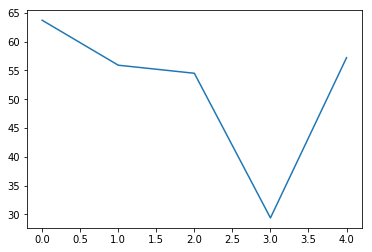

Episod:5, Step: 0, reward: 0.1
Episod:5, Step: 1, reward: 0.1
Episod:5, Step: 2, reward: 0.1
Episod:5, Step: 3, reward: 0.1
Episod:5, Step: 4, reward: 0.1
Episod:5, Step: 5, reward: 0.1
Episod:5, Step: 6, reward: 0.1
Episod:5, Step: 7, reward: 0.1
Episod:5, Step: 8, reward: 0.1
Episod:5, Step: 9, reward: 0.1
Episod:5, Step: 10, reward: 0.1
Episod:5, Step: 11, reward: 0.1
Episod:5, Step: 12, reward: 0.1
Episod:5, Step: 13, reward: 0.1
Episod:5, Step: 14, reward: 0.1
Episod:5, Step: 15, reward: 0.1
Episod:5, Step: 16, reward: 0.1
Episod:5, Step: 17, reward: 0.1
Episod:5, Step: 18, reward: 0.1
Episod:5, Step: 19, reward: 0.1
Episod:5, Step: 20, reward: 0.1
Episod:5, Step: 21, reward: 0.1
Episod:5, Step: 22, reward: 0.1
Episod:5, Step: 23, reward: 0.1
Episod:5, Step: 24, reward: 0.1
Episod:5, Step: 25, reward: 0.1
Episod:5, Step: 26, reward: 0.1
Episod:5, Step: 27, reward: 0.1
Episod:5, Step: 28, reward: 0.1
Episod:5, Step: 29, reward: 0.1
Episod:5, Step: 30, reward: 0.1
Episod:5, Step: 31

Episod:5, Step: 257, reward: 0.1
Episod:5, Step: 258, reward: 0.1
Episod:5, Step: 259, reward: 0.1
Episod:5, Step: 260, reward: 0.1
Episod:5, Step: 261, reward: 0.1
Episod:5, Step: 262, reward: 0.1
Episod:5, Step: 263, reward: 0.1
Episod:5, Step: 264, reward: 0.1
Episod:5, Step: 265, reward: 0.1
Episod:5, Step: 266, reward: 0.1
Episod:5, Step: 267, reward: 0.1
Episod:5, Step: 268, reward: 0.1
Episod:5, Step: 269, reward: 0.1
Episod:5, Step: 270, reward: 0.1
Episod:5, Step: 271, reward: 0.1
Episod:5, Step: 272, reward: 0.1
Episod:5, Step: 273, reward: 0.1
Episod:5, Step: 274, reward: 0.1
Episod:5, Step: 275, reward: 0.1
Episod:5, Step: 276, reward: 0.1
Episod:5, Step: 277, reward: 0.1
Episod:5, Step: 278, reward: 0.1
Episod:5, Step: 279, reward: 0.1
Episod:5, Step: 280, reward: 0.1
Episod:5, Step: 281, reward: 0.1
Episod:5, Step: 282, reward: 0.1
Episod:5, Step: 283, reward: 0.1
Episod:5, Step: 284, reward: 0.1
Episod:5, Step: 285, reward: 0.1
Episod:5, Step: 286, reward: 0.1
Episod:5, 

Episod:5, Step: 511, reward: 0.1
Episod:5, Step: 512, reward: 0.1
Episod:5, Step: 513, reward: 0.1
Episod:5, Step: 514, reward: 0.1
Episod:5, Step: 515, reward: 0.1
Episod:5, Step: 516, reward: 0.1
Episod:5, Step: 517, reward: 0.1
Episod:5, Step: 518, reward: 0.1
Episod:5, Step: 519, reward: 0.1
Episod:5, Step: 520, reward: 0.1
Episod:5, Step: 521, reward: 0.1
Episod:5, Step: 522, reward: 0.1
Episod:5, Step: 523, reward: 0.1
Episod:5, Step: 524, reward: 0.1
Episod:5, Step: 525, reward: 0.1
Episod:5, Step: 526, reward: 0
Episod:5, Step: 527, reward: 0
Episod:5, Step: 528, reward: 0
Episod:5, Step: 529, reward: 0
Episod:5, Step: 530, reward: 0
Episod:5, Step: 531, reward: 0
Episod:5, Step: 532, reward: 0
Episod:5, Step: 533, reward: 0
Episod:5, Step: 534, reward: 0
Episod:5, Step: 535, reward: 0
Episod:5, Step: 536, reward: 0
Episod:5, Step: 537, reward: 0
Episod:5, Step: 538, reward: 0
Episod:5, Step: 539, reward: 0
Episod:5, Step: 540, reward: 0
Episod:5, Step: 541, reward: 0
Episod:5,

Episod:5, Step: 767, reward: 0.1
Episod:5, Step: 768, reward: 0.1
Episod:5, Step: 769, reward: 0.1
Episod:5, Step: 770, reward: 0.1
Episod:5, Step: 771, reward: 0.1
Episod:5, Step: 772, reward: 0.1
Episod:5, Step: 773, reward: 0.1
Episod:5, Step: 774, reward: 0.1
Episod:5, Step: 775, reward: 0.1
Episod:5, Step: 776, reward: 0.1
Episod:5, Step: 777, reward: 0.1
Episod:5, Step: 778, reward: 0.1
Episod:5, Step: 779, reward: 0.1
Episod:5, Step: 780, reward: 0.1
Episod:5, Step: 781, reward: 0.1
Episod:5, Step: 782, reward: 0.1
Episod:5, Step: 783, reward: 0.1
Episod:5, Step: 784, reward: 0.1
Episod:5, Step: 785, reward: 0.1
Episod:5, Step: 786, reward: 0.1
Episod:5, Step: 787, reward: 0.1
Episod:5, Step: 788, reward: 0.1
Episod:5, Step: 789, reward: 0.1
Episod:5, Step: 790, reward: 0.1
Episod:5, Step: 791, reward: 0.1
Episod:5, Step: 792, reward: 0.1
Episod:5, Step: 793, reward: 0.1
Episod:5, Step: 794, reward: 0.1
Episod:5, Step: 795, reward: 0.1
Episod:5, Step: 796, reward: 0.1
Episod:5, 

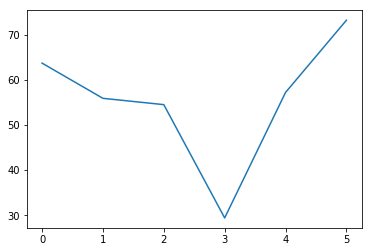

Episod:6, Step: 0, reward: 0.1
Episod:6, Step: 1, reward: 0.1
Episod:6, Step: 2, reward: 0.1
Episod:6, Step: 3, reward: 0.1
Episod:6, Step: 4, reward: 0
Episod:6, Step: 5, reward: 0
Episod:6, Step: 6, reward: 0
Episod:6, Step: 7, reward: 0
Episod:6, Step: 8, reward: 0
Episod:6, Step: 9, reward: 0
Episod:6, Step: 10, reward: 0
Episod:6, Step: 11, reward: 0
Episod:6, Step: 12, reward: 0
Episod:6, Step: 13, reward: 0
Episod:6, Step: 14, reward: 0
Episod:6, Step: 15, reward: 0
Episod:6, Step: 16, reward: 0
Episod:6, Step: 17, reward: 0
Episod:6, Step: 18, reward: 0
Episod:6, Step: 19, reward: 0
Episod:6, Step: 20, reward: 0
Episod:6, Step: 21, reward: 0
Episod:6, Step: 22, reward: 0
Episod:6, Step: 23, reward: 0
Episod:6, Step: 24, reward: 0
Episod:6, Step: 25, reward: 0
Episod:6, Step: 26, reward: 0
Episod:6, Step: 27, reward: 0
Episod:6, Step: 28, reward: 0
Episod:6, Step: 29, reward: 0
Episod:6, Step: 30, reward: 0
Episod:6, Step: 31, reward: 0
Episod:6, Step: 32, reward: 0
Episod:6, St

Episod:6, Step: 274, reward: 0
Episod:6, Step: 275, reward: 0
Episod:6, Step: 276, reward: 0
Episod:6, Step: 277, reward: 0
Episod:6, Step: 278, reward: 0
Episod:6, Step: 279, reward: 0
Episod:6, Step: 280, reward: 0
Episod:6, Step: 281, reward: 0
Episod:6, Step: 282, reward: 0
Episod:6, Step: 283, reward: 0
Episod:6, Step: 284, reward: 0
Episod:6, Step: 285, reward: 0
Episod:6, Step: 286, reward: 0
Episod:6, Step: 287, reward: 0
Episod:6, Step: 288, reward: 0
Episod:6, Step: 289, reward: 0
Episod:6, Step: 290, reward: 0
Episod:6, Step: 291, reward: 0
Episod:6, Step: 292, reward: 0
Episod:6, Step: 293, reward: 0
Episod:6, Step: 294, reward: 0
Episod:6, Step: 295, reward: 0
Episod:6, Step: 296, reward: 0
Episod:6, Step: 297, reward: 0
Episod:6, Step: 298, reward: 0
Episod:6, Step: 299, reward: 0
Episod:6, Step: 300, reward: 0
Episod:6, Step: 301, reward: 0
Episod:6, Step: 302, reward: 0
Episod:6, Step: 303, reward: 0
Episod:6, Step: 304, reward: 0
Episod:6, Step: 305, reward: 0
Episod:6

Episod:6, Step: 541, reward: 0
Episod:6, Step: 542, reward: 0
Episod:6, Step: 543, reward: 0
Episod:6, Step: 544, reward: 0
Episod:6, Step: 545, reward: 0
Episod:6, Step: 546, reward: 0
Episod:6, Step: 547, reward: 0
Episod:6, Step: 548, reward: 0
Episod:6, Step: 549, reward: 0
Episod:6, Step: 550, reward: 0
Episod:6, Step: 551, reward: 0
Episod:6, Step: 552, reward: 0
Episod:6, Step: 553, reward: 0
Episod:6, Step: 554, reward: 0
Episod:6, Step: 555, reward: 0
Episod:6, Step: 556, reward: 0
Episod:6, Step: 557, reward: 0
Episod:6, Step: 558, reward: 0
Episod:6, Step: 559, reward: 0
Episod:6, Step: 560, reward: 0
Episod:6, Step: 561, reward: 0
Episod:6, Step: 562, reward: 0
Episod:6, Step: 563, reward: 0
Episod:6, Step: 564, reward: 0
Episod:6, Step: 565, reward: 0
Episod:6, Step: 566, reward: 0
Episod:6, Step: 567, reward: 0
Episod:6, Step: 568, reward: 0
Episod:6, Step: 569, reward: 0
Episod:6, Step: 570, reward: 0
Episod:6, Step: 571, reward: 0
Episod:6, Step: 572, reward: 0
Episod:6

Episod:6, Step: 810, reward: 0
Episod:6, Step: 811, reward: 0
Episod:6, Step: 812, reward: 0
Episod:6, Step: 813, reward: 0
Episod:6, Step: 814, reward: 0
Episod:6, Step: 815, reward: 0
Episod:6, Step: 816, reward: 0
Episod:6, Step: 817, reward: 0
Episod:6, Step: 818, reward: 0
Episod:6, Step: 819, reward: 0
Episod:6, Step: 820, reward: 0
Episod:6, Step: 821, reward: 0
Episod:6, Step: 822, reward: 0
Episod:6, Step: 823, reward: 0
Episod:6, Step: 824, reward: 0
Episod:6, Step: 825, reward: 0
Episod:6, Step: 826, reward: 0
Episod:6, Step: 827, reward: 0
Episod:6, Step: 828, reward: 0
Episod:6, Step: 829, reward: 0
Episod:6, Step: 830, reward: 0
Episod:6, Step: 831, reward: 0
Episod:6, Step: 832, reward: 0
Episod:6, Step: 833, reward: 0
Episod:6, Step: 834, reward: 0
Episod:6, Step: 835, reward: 0
Episod:6, Step: 836, reward: 0
Episod:6, Step: 837, reward: 0
Episod:6, Step: 838, reward: 0
Episod:6, Step: 839, reward: 0
Episod:6, Step: 840, reward: 0
Episod:6, Step: 841, reward: 0
Episod:6

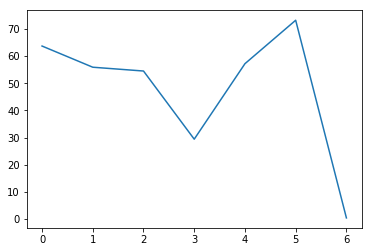

Episod:7, Step: 0, reward: 0
Episod:7, Step: 1, reward: 0
Episod:7, Step: 2, reward: 0
Episod:7, Step: 3, reward: 0
Episod:7, Step: 4, reward: 0
Episod:7, Step: 5, reward: 0
Episod:7, Step: 6, reward: 0
Episod:7, Step: 7, reward: 0
Episod:7, Step: 8, reward: 0
Episod:7, Step: 9, reward: 0
Episod:7, Step: 10, reward: 0
Episod:7, Step: 11, reward: 0
Episod:7, Step: 12, reward: 0
Episod:7, Step: 13, reward: 0
Episod:7, Step: 14, reward: 0
Episod:7, Step: 15, reward: 0
Episod:7, Step: 16, reward: 0
Episod:7, Step: 17, reward: 0
Episod:7, Step: 18, reward: 0
Episod:7, Step: 19, reward: 0
Episod:7, Step: 20, reward: 0
Episod:7, Step: 21, reward: 0
Episod:7, Step: 22, reward: 0
Episod:7, Step: 23, reward: 0
Episod:7, Step: 24, reward: 0
Episod:7, Step: 25, reward: 0
Episod:7, Step: 26, reward: 0
Episod:7, Step: 27, reward: 0
Episod:7, Step: 28, reward: 0
Episod:7, Step: 29, reward: 0
Episod:7, Step: 30, reward: 0
Episod:7, Step: 31, reward: 0
Episod:7, Step: 32, reward: 0
Episod:7, Step: 33, 

Episod:7, Step: 263, reward: 0.1
Episod:7, Step: 264, reward: 0.1
Episod:7, Step: 265, reward: 0.1
Episod:7, Step: 266, reward: 0.1
Episod:7, Step: 267, reward: 0.1
Episod:7, Step: 268, reward: 0.1
Episod:7, Step: 269, reward: 0.1
Episod:7, Step: 270, reward: 0.1
Episod:7, Step: 271, reward: 0.1
Episod:7, Step: 272, reward: 0.1
Episod:7, Step: 273, reward: 0.1
Episod:7, Step: 274, reward: 0.1
Episod:7, Step: 275, reward: 0.1
Episod:7, Step: 276, reward: 0.1
Episod:7, Step: 277, reward: 0
Episod:7, Step: 278, reward: 0
Episod:7, Step: 279, reward: 0
Episod:7, Step: 280, reward: 0
Episod:7, Step: 281, reward: 0
Episod:7, Step: 282, reward: 0
Episod:7, Step: 283, reward: 0
Episod:7, Step: 284, reward: 0
Episod:7, Step: 285, reward: 0
Episod:7, Step: 286, reward: 0
Episod:7, Step: 287, reward: 0
Episod:7, Step: 288, reward: 0
Episod:7, Step: 289, reward: 0
Episod:7, Step: 290, reward: 0
Episod:7, Step: 291, reward: 0
Episod:7, Step: 292, reward: 0
Episod:7, Step: 293, reward: 0
Episod:7, S

Episod:7, Step: 525, reward: 0.1
Episod:7, Step: 526, reward: 0.1
Episod:7, Step: 527, reward: 0.1
Episod:7, Step: 528, reward: 0.1
Episod:7, Step: 529, reward: 0.1
Episod:7, Step: 530, reward: 0.1
Episod:7, Step: 531, reward: 0.1
Episod:7, Step: 532, reward: 0.1
Episod:7, Step: 533, reward: 0.1
Episod:7, Step: 534, reward: 0.1
Episod:7, Step: 535, reward: 0.1
Episod:7, Step: 536, reward: 0.1
Episod:7, Step: 537, reward: 0.1
Episod:7, Step: 538, reward: 0.1
Episod:7, Step: 539, reward: 0.1
Episod:7, Step: 540, reward: 0.1
Episod:7, Step: 541, reward: 0.1
Episod:7, Step: 542, reward: 0.1
Episod:7, Step: 543, reward: 0.1
Episod:7, Step: 544, reward: 0.1
Episod:7, Step: 545, reward: 0.1
Episod:7, Step: 546, reward: 0.1
Episod:7, Step: 547, reward: 0.1
Episod:7, Step: 548, reward: 0.1
Episod:7, Step: 549, reward: 0.1
Episod:7, Step: 550, reward: 0.1
Episod:7, Step: 551, reward: 0.1
Episod:7, Step: 552, reward: 0.1
Episod:7, Step: 553, reward: 0.1
Episod:7, Step: 554, reward: 0.1
Episod:7, 

Episod:7, Step: 779, reward: 0.1
Episod:7, Step: 780, reward: 0.1
Episod:7, Step: 781, reward: 0.1
Episod:7, Step: 782, reward: 0.1
Episod:7, Step: 783, reward: 0.1
Episod:7, Step: 784, reward: 0.1
Episod:7, Step: 785, reward: 0.1
Episod:7, Step: 786, reward: 0.1
Episod:7, Step: 787, reward: 0.1
Episod:7, Step: 788, reward: 0.1
Episod:7, Step: 789, reward: 0.1
Episod:7, Step: 790, reward: 0.1
Episod:7, Step: 791, reward: 0.1
Episod:7, Step: 792, reward: 0.1
Episod:7, Step: 793, reward: 0.1
Episod:7, Step: 794, reward: 0.1
Episod:7, Step: 795, reward: 0.1
Episod:7, Step: 796, reward: 0.1
Episod:7, Step: 797, reward: 0.1
Episod:7, Step: 798, reward: 0.1
Episod:7, Step: 799, reward: 0.1
Episod:7, Step: 800, reward: 0.1
Episod:7, Step: 801, reward: 0.1
Episod:7, Step: 802, reward: 0.1
Episod:7, Step: 803, reward: 0.1
Episod:7, Step: 804, reward: 0.1
Episod:7, Step: 805, reward: 0.1
Episod:7, Step: 806, reward: 0.1
Episod:7, Step: 807, reward: 0.1
Episod:7, Step: 808, reward: 0.1
Episod:7, 

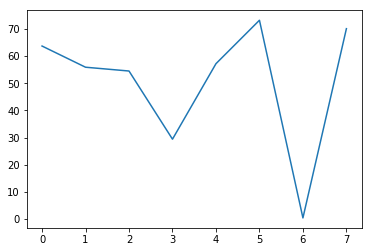

Episod:8, Step: 0, reward: 0.1
Episod:8, Step: 1, reward: 0.1
Episod:8, Step: 2, reward: 0.1
Episod:8, Step: 3, reward: 0.1
Episod:8, Step: 4, reward: 0.1
Episod:8, Step: 5, reward: 0.1
Episod:8, Step: 6, reward: 0.1
Episod:8, Step: 7, reward: 0.1
Episod:8, Step: 8, reward: 0.1
Episod:8, Step: 9, reward: 0.1
Episod:8, Step: 10, reward: 0.1
Episod:8, Step: 11, reward: 0.1
Episod:8, Step: 12, reward: 0.1
Episod:8, Step: 13, reward: 0.1
Episod:8, Step: 14, reward: 0.1
Episod:8, Step: 15, reward: 0.1
Episod:8, Step: 16, reward: 0.1
Episod:8, Step: 17, reward: 0.1
Episod:8, Step: 18, reward: 0.1
Episod:8, Step: 19, reward: 0.1
Episod:8, Step: 20, reward: 0.1
Episod:8, Step: 21, reward: 0.1
Episod:8, Step: 22, reward: 0.1
Episod:8, Step: 23, reward: 0.1
Episod:8, Step: 24, reward: 0.1
Episod:8, Step: 25, reward: 0.1
Episod:8, Step: 26, reward: 0.1
Episod:8, Step: 27, reward: 0.1
Episod:8, Step: 28, reward: 0.1
Episod:8, Step: 29, reward: 0.1
Episod:8, Step: 30, reward: 0.1
Episod:8, Step: 31

Episod:8, Step: 258, reward: 0.1
Episod:8, Step: 259, reward: 0.1
Episod:8, Step: 260, reward: 0.1
Episod:8, Step: 261, reward: 0.1
Episod:8, Step: 262, reward: 0.1
Episod:8, Step: 263, reward: 0.1
Episod:8, Step: 264, reward: 0.1
Episod:8, Step: 265, reward: 0.1
Episod:8, Step: 266, reward: 0.1
Episod:8, Step: 267, reward: 0.1
Episod:8, Step: 268, reward: 0.1
Episod:8, Step: 269, reward: 0.1
Episod:8, Step: 270, reward: 0.1
Episod:8, Step: 271, reward: 0.1
Episod:8, Step: 272, reward: 0.1
Episod:8, Step: 273, reward: 0.1
Episod:8, Step: 274, reward: 0.1
Episod:8, Step: 275, reward: 0.1
Episod:8, Step: 276, reward: 0.1
Episod:8, Step: 277, reward: 0.1
Episod:8, Step: 278, reward: 0.1
Episod:8, Step: 279, reward: 0.1
Episod:8, Step: 280, reward: 0.1
Episod:8, Step: 281, reward: 0.1
Episod:8, Step: 282, reward: 0.1
Episod:8, Step: 283, reward: 0.1
Episod:8, Step: 284, reward: 0.1
Episod:8, Step: 285, reward: 0.1
Episod:8, Step: 286, reward: 0.1
Episod:8, Step: 287, reward: 0.1
Episod:8, 

Episod:8, Step: 508, reward: 0.1
Episod:8, Step: 509, reward: 0.1
Episod:8, Step: 510, reward: 0.1
Episod:8, Step: 511, reward: 0.1
Episod:8, Step: 512, reward: 0.1
Episod:8, Step: 513, reward: 0.1
Episod:8, Step: 514, reward: 0
Episod:8, Step: 515, reward: 0
Episod:8, Step: 516, reward: 0
Episod:8, Step: 517, reward: 0
Episod:8, Step: 518, reward: 0
Episod:8, Step: 519, reward: 0
Episod:8, Step: 520, reward: 0
Episod:8, Step: 521, reward: 0
Episod:8, Step: 522, reward: 0
Episod:8, Step: 523, reward: 0
Episod:8, Step: 524, reward: 0
Episod:8, Step: 525, reward: 0
Episod:8, Step: 526, reward: 0
Episod:8, Step: 527, reward: 0
Episod:8, Step: 528, reward: 0
Episod:8, Step: 529, reward: 0
Episod:8, Step: 530, reward: 0
Episod:8, Step: 531, reward: 0
Episod:8, Step: 532, reward: 0
Episod:8, Step: 533, reward: 0
Episod:8, Step: 534, reward: 0
Episod:8, Step: 535, reward: 0
Episod:8, Step: 536, reward: 0
Episod:8, Step: 537, reward: 0
Episod:8, Step: 538, reward: 0
Episod:8, Step: 539, reward

Episod:8, Step: 772, reward: 0
Episod:8, Step: 773, reward: 0
Episod:8, Step: 774, reward: 0
Episod:8, Step: 775, reward: 0
Episod:8, Step: 776, reward: 0
Episod:8, Step: 777, reward: 0
Episod:8, Step: 778, reward: 0
Episod:8, Step: 779, reward: 0
Episod:8, Step: 780, reward: 0
Episod:8, Step: 781, reward: 0
Episod:8, Step: 782, reward: 0
Episod:8, Step: 783, reward: 0
Episod:8, Step: 784, reward: 0
Episod:8, Step: 785, reward: 0
Episod:8, Step: 786, reward: 0
Episod:8, Step: 787, reward: 0
Episod:8, Step: 788, reward: 0
Episod:8, Step: 789, reward: 0
Episod:8, Step: 790, reward: 0
Episod:8, Step: 791, reward: 0
Episod:8, Step: 792, reward: 0
Episod:8, Step: 793, reward: 0
Episod:8, Step: 794, reward: 0
Episod:8, Step: 795, reward: 0
Episod:8, Step: 796, reward: 0
Episod:8, Step: 797, reward: 0
Episod:8, Step: 798, reward: 0
Episod:8, Step: 799, reward: 0
Episod:8, Step: 800, reward: 0
Episod:8, Step: 801, reward: 0
Episod:8, Step: 802, reward: 0
Episod:8, Step: 803, reward: 0
Episod:8

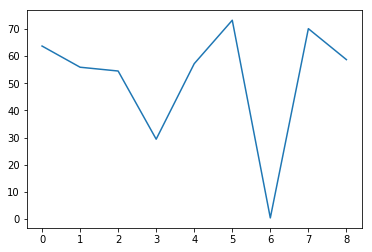

Episod:9, Step: 0, reward: 0
Episod:9, Step: 1, reward: 0
Episod:9, Step: 2, reward: 0
Episod:9, Step: 3, reward: 0
Episod:9, Step: 4, reward: 0
Episod:9, Step: 5, reward: 0
Episod:9, Step: 6, reward: 0
Episod:9, Step: 7, reward: 0
Episod:9, Step: 8, reward: 0
Episod:9, Step: 9, reward: 0
Episod:9, Step: 10, reward: 0
Episod:9, Step: 11, reward: 0
Episod:9, Step: 12, reward: 0
Episod:9, Step: 13, reward: 0
Episod:9, Step: 14, reward: 0
Episod:9, Step: 15, reward: 0
Episod:9, Step: 16, reward: 0
Episod:9, Step: 17, reward: 0
Episod:9, Step: 18, reward: 0
Episod:9, Step: 19, reward: 0
Episod:9, Step: 20, reward: 0
Episod:9, Step: 21, reward: 0
Episod:9, Step: 22, reward: 0
Episod:9, Step: 23, reward: 0
Episod:9, Step: 24, reward: 0
Episod:9, Step: 25, reward: 0
Episod:9, Step: 26, reward: 0
Episod:9, Step: 27, reward: 0
Episod:9, Step: 28, reward: 0
Episod:9, Step: 29, reward: 0
Episod:9, Step: 30, reward: 0
Episod:9, Step: 31, reward: 0
Episod:9, Step: 32, reward: 0
Episod:9, Step: 33, 

Episod:9, Step: 269, reward: 0
Episod:9, Step: 270, reward: 0
Episod:9, Step: 271, reward: 0
Episod:9, Step: 272, reward: 0
Episod:9, Step: 273, reward: 0
Episod:9, Step: 274, reward: 0
Episod:9, Step: 275, reward: 0
Episod:9, Step: 276, reward: 0
Episod:9, Step: 277, reward: 0
Episod:9, Step: 278, reward: 0
Episod:9, Step: 279, reward: 0
Episod:9, Step: 280, reward: 0
Episod:9, Step: 281, reward: 0
Episod:9, Step: 282, reward: 0
Episod:9, Step: 283, reward: 0
Episod:9, Step: 284, reward: 0
Episod:9, Step: 285, reward: 0
Episod:9, Step: 286, reward: 0
Episod:9, Step: 287, reward: 0
Episod:9, Step: 288, reward: 0
Episod:9, Step: 289, reward: 0
Episod:9, Step: 290, reward: 0
Episod:9, Step: 291, reward: 0
Episod:9, Step: 292, reward: 0
Episod:9, Step: 293, reward: 0
Episod:9, Step: 294, reward: 0
Episod:9, Step: 295, reward: 0
Episod:9, Step: 296, reward: 0
Episod:9, Step: 297, reward: 0
Episod:9, Step: 298, reward: 0
Episod:9, Step: 299, reward: 0
Episod:9, Step: 300, reward: 0
Episod:9

Episod:9, Step: 536, reward: 0
Episod:9, Step: 537, reward: 0
Episod:9, Step: 538, reward: 0
Episod:9, Step: 539, reward: 0
Episod:9, Step: 540, reward: 0
Episod:9, Step: 541, reward: 0
Episod:9, Step: 542, reward: 0
Episod:9, Step: 543, reward: 0
Episod:9, Step: 544, reward: 0
Episod:9, Step: 545, reward: 0
Episod:9, Step: 546, reward: 0
Episod:9, Step: 547, reward: 0
Episod:9, Step: 548, reward: 0
Episod:9, Step: 549, reward: 0
Episod:9, Step: 550, reward: 0
Episod:9, Step: 551, reward: 0
Episod:9, Step: 552, reward: 0
Episod:9, Step: 553, reward: 0
Episod:9, Step: 554, reward: 0
Episod:9, Step: 555, reward: 0
Episod:9, Step: 556, reward: 0
Episod:9, Step: 557, reward: 0
Episod:9, Step: 558, reward: 0
Episod:9, Step: 559, reward: 0
Episod:9, Step: 560, reward: 0
Episod:9, Step: 561, reward: 0
Episod:9, Step: 562, reward: 0
Episod:9, Step: 563, reward: 0
Episod:9, Step: 564, reward: 0
Episod:9, Step: 565, reward: 0
Episod:9, Step: 566, reward: 0
Episod:9, Step: 567, reward: 0
Episod:9

Episod:9, Step: 804, reward: 0.1
Episod:9, Step: 805, reward: 0.1
Episod:9, Step: 806, reward: 0.1
Episod:9, Step: 807, reward: 0.1
Episod:9, Step: 808, reward: 0
Episod:9, Step: 809, reward: 0
Episod:9, Step: 810, reward: 0
Episod:9, Step: 811, reward: 0
Episod:9, Step: 812, reward: 0
Episod:9, Step: 813, reward: 0
Episod:9, Step: 814, reward: 0
Episod:9, Step: 815, reward: 0
Episod:9, Step: 816, reward: 0
Episod:9, Step: 817, reward: 0
Episod:9, Step: 818, reward: 0
Episod:9, Step: 819, reward: 0
Episod:9, Step: 820, reward: 0
Episod:9, Step: 821, reward: 0
Episod:9, Step: 822, reward: 0
Episod:9, Step: 823, reward: 0
Episod:9, Step: 824, reward: 0
Episod:9, Step: 825, reward: 0
Episod:9, Step: 826, reward: 0
Episod:9, Step: 827, reward: 0
Episod:9, Step: 828, reward: 0
Episod:9, Step: 829, reward: 0
Episod:9, Step: 830, reward: 0.1
Episod:9, Step: 831, reward: 0.1
Episod:9, Step: 832, reward: 0.1
Episod:9, Step: 833, reward: 0.1
Episod:9, Step: 834, reward: 0.1
Episod:9, Step: 835, 

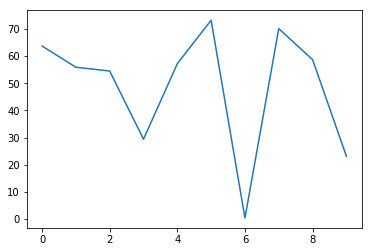

Episod:10, Step: 0, reward: 0.1
Episod:10, Step: 1, reward: 0.1
Episod:10, Step: 2, reward: 0.1
Episod:10, Step: 3, reward: 0.1
Episod:10, Step: 4, reward: 0.1
Episod:10, Step: 5, reward: 0.1
Episod:10, Step: 6, reward: 0.1
Episod:10, Step: 7, reward: 0.1
Episod:10, Step: 8, reward: 0.1
Episod:10, Step: 9, reward: 0.1
Episod:10, Step: 10, reward: 0.1
Episod:10, Step: 11, reward: 0.1
Episod:10, Step: 12, reward: 0.1
Episod:10, Step: 13, reward: 0.1
Episod:10, Step: 14, reward: 0.1
Episod:10, Step: 15, reward: 0.1
Episod:10, Step: 16, reward: 0.1
Episod:10, Step: 17, reward: 0.1
Episod:10, Step: 18, reward: 0.1
Episod:10, Step: 19, reward: 0.1
Episod:10, Step: 20, reward: 0.1
Episod:10, Step: 21, reward: 0.1
Episod:10, Step: 22, reward: 0.1
Episod:10, Step: 23, reward: 0.1
Episod:10, Step: 24, reward: 0.1
Episod:10, Step: 25, reward: 0.1
Episod:10, Step: 26, reward: 0.1
Episod:10, Step: 27, reward: 0.1
Episod:10, Step: 28, reward: 0.1
Episod:10, Step: 29, reward: 0.1
Episod:10, Step: 30,

Episod:10, Step: 245, reward: 0.1
Episod:10, Step: 246, reward: 0.1
Episod:10, Step: 247, reward: 0.1
Episod:10, Step: 248, reward: 0.1
Episod:10, Step: 249, reward: 0.1
Episod:10, Step: 250, reward: 0.1
Episod:10, Step: 251, reward: 0.1
Episod:10, Step: 252, reward: 0.1
Episod:10, Step: 253, reward: 0.1
Episod:10, Step: 254, reward: 0
Episod:10, Step: 255, reward: 0
Episod:10, Step: 256, reward: 0
Episod:10, Step: 257, reward: 0
Episod:10, Step: 258, reward: 0
Episod:10, Step: 259, reward: 0
Episod:10, Step: 260, reward: 0
Episod:10, Step: 261, reward: 0
Episod:10, Step: 262, reward: 0
Episod:10, Step: 263, reward: 0
Episod:10, Step: 264, reward: 0
Episod:10, Step: 265, reward: 0
Episod:10, Step: 266, reward: 0
Episod:10, Step: 267, reward: 0
Episod:10, Step: 268, reward: 0
Episod:10, Step: 269, reward: 0
Episod:10, Step: 270, reward: 0
Episod:10, Step: 271, reward: 0
Episod:10, Step: 272, reward: 0
Episod:10, Step: 273, reward: 0
Episod:10, Step: 274, reward: 0
Episod:10, Step: 275, 

Episod:10, Step: 493, reward: 0.1
Episod:10, Step: 494, reward: 0.1
Episod:10, Step: 495, reward: 0.1
Episod:10, Step: 496, reward: 0.1
Episod:10, Step: 497, reward: 0.1
Episod:10, Step: 498, reward: 0.1
Episod:10, Step: 499, reward: 0.1
Episod:10, Step: 500, reward: 0.1
Episod:10, Step: 501, reward: 0.1
Episod:10, Step: 502, reward: 0.1
Episod:10, Step: 503, reward: 0.1
Episod:10, Step: 504, reward: 0.1
Episod:10, Step: 505, reward: 0.1
Episod:10, Step: 506, reward: 0.1
Episod:10, Step: 507, reward: 0.1
Episod:10, Step: 508, reward: 0.1
Episod:10, Step: 509, reward: 0
Episod:10, Step: 510, reward: 0
Episod:10, Step: 511, reward: 0
Episod:10, Step: 512, reward: 0
Episod:10, Step: 513, reward: 0
Episod:10, Step: 514, reward: 0
Episod:10, Step: 515, reward: 0
Episod:10, Step: 516, reward: 0
Episod:10, Step: 517, reward: 0
Episod:10, Step: 518, reward: 0
Episod:10, Step: 519, reward: 0
Episod:10, Step: 520, reward: 0
Episod:10, Step: 521, reward: 0
Episod:10, Step: 522, reward: 0
Episod:1

Episod:10, Step: 747, reward: 0
Episod:10, Step: 748, reward: 0
Episod:10, Step: 749, reward: 0.1
Episod:10, Step: 750, reward: 0.1
Episod:10, Step: 751, reward: 0.1
Episod:10, Step: 752, reward: 0.1
Episod:10, Step: 753, reward: 0.1
Episod:10, Step: 754, reward: 0.1
Episod:10, Step: 755, reward: 0.1
Episod:10, Step: 756, reward: 0.1
Episod:10, Step: 757, reward: 0.1
Episod:10, Step: 758, reward: 0
Episod:10, Step: 759, reward: 0
Episod:10, Step: 760, reward: 0
Episod:10, Step: 761, reward: 0
Episod:10, Step: 762, reward: 0
Episod:10, Step: 763, reward: 0
Episod:10, Step: 764, reward: 0
Episod:10, Step: 765, reward: 0
Episod:10, Step: 766, reward: 0
Episod:10, Step: 767, reward: 0
Episod:10, Step: 768, reward: 0
Episod:10, Step: 769, reward: 0
Episod:10, Step: 770, reward: 0
Episod:10, Step: 771, reward: 0
Episod:10, Step: 772, reward: 0
Episod:10, Step: 773, reward: 0
Episod:10, Step: 774, reward: 0
Episod:10, Step: 775, reward: 0
Episod:10, Step: 776, reward: 0
Episod:10, Step: 777, 

Episod:10, Step: 999, reward: 0.1
| Reward: 67 | Episode: 10 | Qmax: 1.6763


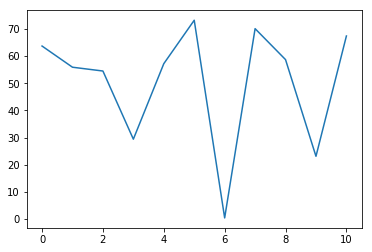

Episod:11, Step: 0, reward: 0
Episod:11, Step: 1, reward: 0
Episod:11, Step: 2, reward: 0
Episod:11, Step: 3, reward: 0
Episod:11, Step: 4, reward: 0
Episod:11, Step: 5, reward: 0
Episod:11, Step: 6, reward: 0
Episod:11, Step: 7, reward: 0
Episod:11, Step: 8, reward: 0
Episod:11, Step: 9, reward: 0
Episod:11, Step: 10, reward: 0
Episod:11, Step: 11, reward: 0
Episod:11, Step: 12, reward: 0.1
Episod:11, Step: 13, reward: 0.1
Episod:11, Step: 14, reward: 0.1
Episod:11, Step: 15, reward: 0.1
Episod:11, Step: 16, reward: 0.1
Episod:11, Step: 17, reward: 0.1
Episod:11, Step: 18, reward: 0
Episod:11, Step: 19, reward: 0
Episod:11, Step: 20, reward: 0
Episod:11, Step: 21, reward: 0
Episod:11, Step: 22, reward: 0
Episod:11, Step: 23, reward: 0
Episod:11, Step: 24, reward: 0
Episod:11, Step: 25, reward: 0
Episod:11, Step: 26, reward: 0
Episod:11, Step: 27, reward: 0
Episod:11, Step: 28, reward: 0
Episod:11, Step: 29, reward: 0
Episod:11, Step: 30, reward: 0
Episod:11, Step: 31, reward: 0
Episod

Episod:11, Step: 261, reward: 0.1
Episod:11, Step: 262, reward: 0.1
Episod:11, Step: 263, reward: 0.1
Episod:11, Step: 264, reward: 0.1
Episod:11, Step: 265, reward: 0.1
Episod:11, Step: 266, reward: 0.1
Episod:11, Step: 267, reward: 0.1
Episod:11, Step: 268, reward: 0.1
Episod:11, Step: 269, reward: 0.1
Episod:11, Step: 270, reward: 0.1
Episod:11, Step: 271, reward: 0.1
Episod:11, Step: 272, reward: 0.1
Episod:11, Step: 273, reward: 0.1
Episod:11, Step: 274, reward: 0.1
Episod:11, Step: 275, reward: 0.1
Episod:11, Step: 276, reward: 0.1
Episod:11, Step: 277, reward: 0.1
Episod:11, Step: 278, reward: 0.1
Episod:11, Step: 279, reward: 0.1
Episod:11, Step: 280, reward: 0.1
Episod:11, Step: 281, reward: 0.1
Episod:11, Step: 282, reward: 0.1
Episod:11, Step: 283, reward: 0.1
Episod:11, Step: 284, reward: 0.1
Episod:11, Step: 285, reward: 0.1
Episod:11, Step: 286, reward: 0.1
Episod:11, Step: 287, reward: 0.1
Episod:11, Step: 288, reward: 0.1
Episod:11, Step: 289, reward: 0
Episod:11, Step:

Episod:11, Step: 516, reward: 0
Episod:11, Step: 517, reward: 0
Episod:11, Step: 518, reward: 0
Episod:11, Step: 519, reward: 0
Episod:11, Step: 520, reward: 0
Episod:11, Step: 521, reward: 0
Episod:11, Step: 522, reward: 0
Episod:11, Step: 523, reward: 0
Episod:11, Step: 524, reward: 0
Episod:11, Step: 525, reward: 0
Episod:11, Step: 526, reward: 0
Episod:11, Step: 527, reward: 0
Episod:11, Step: 528, reward: 0
Episod:11, Step: 529, reward: 0
Episod:11, Step: 530, reward: 0.1
Episod:11, Step: 531, reward: 0.1
Episod:11, Step: 532, reward: 0.1
Episod:11, Step: 533, reward: 0.1
Episod:11, Step: 534, reward: 0.1
Episod:11, Step: 535, reward: 0.1
Episod:11, Step: 536, reward: 0.1
Episod:11, Step: 537, reward: 0.1
Episod:11, Step: 538, reward: 0.1
Episod:11, Step: 539, reward: 0.1
Episod:11, Step: 540, reward: 0.1
Episod:11, Step: 541, reward: 0.1
Episod:11, Step: 542, reward: 0.1
Episod:11, Step: 543, reward: 0.1
Episod:11, Step: 544, reward: 0.1
Episod:11, Step: 545, reward: 0.1
Episod:1

Episod:11, Step: 763, reward: 0.1
Episod:11, Step: 764, reward: 0.1
Episod:11, Step: 765, reward: 0.1
Episod:11, Step: 766, reward: 0.1
Episod:11, Step: 767, reward: 0.1
Episod:11, Step: 768, reward: 0.1
Episod:11, Step: 769, reward: 0.1
Episod:11, Step: 770, reward: 0.1
Episod:11, Step: 771, reward: 0.1
Episod:11, Step: 772, reward: 0.1
Episod:11, Step: 773, reward: 0.1
Episod:11, Step: 774, reward: 0.1
Episod:11, Step: 775, reward: 0.1
Episod:11, Step: 776, reward: 0.1
Episod:11, Step: 777, reward: 0.1
Episod:11, Step: 778, reward: 0.1
Episod:11, Step: 779, reward: 0.1
Episod:11, Step: 780, reward: 0.1
Episod:11, Step: 781, reward: 0.1
Episod:11, Step: 782, reward: 0.1
Episod:11, Step: 783, reward: 0.1
Episod:11, Step: 784, reward: 0.1
Episod:11, Step: 785, reward: 0.1
Episod:11, Step: 786, reward: 0.1
Episod:11, Step: 787, reward: 0.1
Episod:11, Step: 788, reward: 0.1
Episod:11, Step: 789, reward: 0.1
Episod:11, Step: 790, reward: 0.1
Episod:11, Step: 791, reward: 0.1
Episod:11, Ste

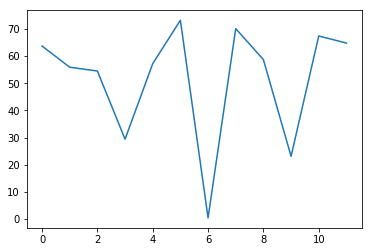

Episod:12, Step: 0, reward: 0.1
Episod:12, Step: 1, reward: 0.1
Episod:12, Step: 2, reward: 0.1
Episod:12, Step: 3, reward: 0.1
Episod:12, Step: 4, reward: 0.1
Episod:12, Step: 5, reward: 0.1
Episod:12, Step: 6, reward: 0.1
Episod:12, Step: 7, reward: 0.1
Episod:12, Step: 8, reward: 0.1
Episod:12, Step: 9, reward: 0.1
Episod:12, Step: 10, reward: 0.1
Episod:12, Step: 11, reward: 0.1
Episod:12, Step: 12, reward: 0.1
Episod:12, Step: 13, reward: 0.1
Episod:12, Step: 14, reward: 0.1
Episod:12, Step: 15, reward: 0.1
Episod:12, Step: 16, reward: 0.1
Episod:12, Step: 17, reward: 0.1
Episod:12, Step: 18, reward: 0.1
Episod:12, Step: 19, reward: 0.1
Episod:12, Step: 20, reward: 0.1
Episod:12, Step: 21, reward: 0.1
Episod:12, Step: 22, reward: 0.1
Episod:12, Step: 23, reward: 0.1
Episod:12, Step: 24, reward: 0.1
Episod:12, Step: 25, reward: 0.1
Episod:12, Step: 26, reward: 0.1
Episod:12, Step: 27, reward: 0.1
Episod:12, Step: 28, reward: 0.1
Episod:12, Step: 29, reward: 0.1
Episod:12, Step: 30,

Episod:12, Step: 248, reward: 0
Episod:12, Step: 249, reward: 0
Episod:12, Step: 250, reward: 0
Episod:12, Step: 251, reward: 0
Episod:12, Step: 252, reward: 0
Episod:12, Step: 253, reward: 0
Episod:12, Step: 254, reward: 0
Episod:12, Step: 255, reward: 0
Episod:12, Step: 256, reward: 0
Episod:12, Step: 257, reward: 0
Episod:12, Step: 258, reward: 0
Episod:12, Step: 259, reward: 0
Episod:12, Step: 260, reward: 0
Episod:12, Step: 261, reward: 0
Episod:12, Step: 262, reward: 0
Episod:12, Step: 263, reward: 0
Episod:12, Step: 264, reward: 0
Episod:12, Step: 265, reward: 0
Episod:12, Step: 266, reward: 0
Episod:12, Step: 267, reward: 0
Episod:12, Step: 268, reward: 0
Episod:12, Step: 269, reward: 0
Episod:12, Step: 270, reward: 0
Episod:12, Step: 271, reward: 0
Episod:12, Step: 272, reward: 0
Episod:12, Step: 273, reward: 0
Episod:12, Step: 274, reward: 0
Episod:12, Step: 275, reward: 0
Episod:12, Step: 276, reward: 0
Episod:12, Step: 277, reward: 0
Episod:12, Step: 278, reward: 0
Episod:1

Episod:12, Step: 500, reward: 0.1
Episod:12, Step: 501, reward: 0.1
Episod:12, Step: 502, reward: 0.1
Episod:12, Step: 503, reward: 0.1
Episod:12, Step: 504, reward: 0.1
Episod:12, Step: 505, reward: 0.1
Episod:12, Step: 506, reward: 0.1
Episod:12, Step: 507, reward: 0.1
Episod:12, Step: 508, reward: 0.1
Episod:12, Step: 509, reward: 0.1
Episod:12, Step: 510, reward: 0.1
Episod:12, Step: 511, reward: 0.1
Episod:12, Step: 512, reward: 0.1
Episod:12, Step: 513, reward: 0.1
Episod:12, Step: 514, reward: 0.1
Episod:12, Step: 515, reward: 0.1
Episod:12, Step: 516, reward: 0.1
Episod:12, Step: 517, reward: 0.1
Episod:12, Step: 518, reward: 0.1
Episod:12, Step: 519, reward: 0.1
Episod:12, Step: 520, reward: 0.1
Episod:12, Step: 521, reward: 0.1
Episod:12, Step: 522, reward: 0.1
Episod:12, Step: 523, reward: 0.1
Episod:12, Step: 524, reward: 0.1
Episod:12, Step: 525, reward: 0.1
Episod:12, Step: 526, reward: 0.1
Episod:12, Step: 527, reward: 0.1
Episod:12, Step: 528, reward: 0.1
Episod:12, Ste

Episod:12, Step: 747, reward: 0.1
Episod:12, Step: 748, reward: 0.1
Episod:12, Step: 749, reward: 0.1
Episod:12, Step: 750, reward: 0.1
Episod:12, Step: 751, reward: 0.1
Episod:12, Step: 752, reward: 0.1
Episod:12, Step: 753, reward: 0.1
Episod:12, Step: 754, reward: 0.1
Episod:12, Step: 755, reward: 0.1
Episod:12, Step: 756, reward: 0.1
Episod:12, Step: 757, reward: 0.1
Episod:12, Step: 758, reward: 0.1
Episod:12, Step: 759, reward: 0.1
Episod:12, Step: 760, reward: 0.1
Episod:12, Step: 761, reward: 0.1
Episod:12, Step: 762, reward: 0.1
Episod:12, Step: 763, reward: 0.1
Episod:12, Step: 764, reward: 0.1
Episod:12, Step: 765, reward: 0.1
Episod:12, Step: 766, reward: 0.1
Episod:12, Step: 767, reward: 0.1
Episod:12, Step: 768, reward: 0.1
Episod:12, Step: 769, reward: 0.1
Episod:12, Step: 770, reward: 0.1
Episod:12, Step: 771, reward: 0.1
Episod:12, Step: 772, reward: 0.1
Episod:12, Step: 773, reward: 0.1
Episod:12, Step: 774, reward: 0.1
Episod:12, Step: 775, reward: 0.1
Episod:12, Ste

Episod:12, Step: 994, reward: 0.1
Episod:12, Step: 995, reward: 0.1
Episod:12, Step: 996, reward: 0.1
Episod:12, Step: 997, reward: 0.1
Episod:12, Step: 998, reward: 0.1
Episod:12, Step: 999, reward: 0.1
| Reward: 91 | Episode: 12 | Qmax: 1.9237


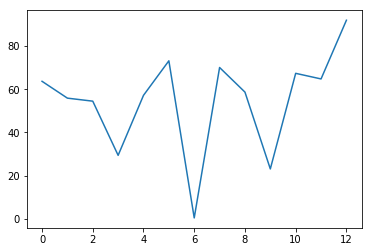

Episod:13, Step: 0, reward: 0.1
Episod:13, Step: 1, reward: 0.1
Episod:13, Step: 2, reward: 0.1
Episod:13, Step: 3, reward: 0.1
Episod:13, Step: 4, reward: 0.1
Episod:13, Step: 5, reward: 0.1
Episod:13, Step: 6, reward: 0.1
Episod:13, Step: 7, reward: 0.1
Episod:13, Step: 8, reward: 0.1
Episod:13, Step: 9, reward: 0.1
Episod:13, Step: 10, reward: 0.1
Episod:13, Step: 11, reward: 0.1
Episod:13, Step: 12, reward: 0.1
Episod:13, Step: 13, reward: 0.1
Episod:13, Step: 14, reward: 0.1
Episod:13, Step: 15, reward: 0.1
Episod:13, Step: 16, reward: 0.1
Episod:13, Step: 17, reward: 0.1
Episod:13, Step: 18, reward: 0.1
Episod:13, Step: 19, reward: 0.1
Episod:13, Step: 20, reward: 0.1
Episod:13, Step: 21, reward: 0.1
Episod:13, Step: 22, reward: 0.1
Episod:13, Step: 23, reward: 0.1
Episod:13, Step: 24, reward: 0.1
Episod:13, Step: 25, reward: 0.1
Episod:13, Step: 26, reward: 0.1
Episod:13, Step: 27, reward: 0.1
Episod:13, Step: 28, reward: 0.1
Episod:13, Step: 29, reward: 0.1
Episod:13, Step: 30,

Episod:13, Step: 245, reward: 0.1
Episod:13, Step: 246, reward: 0.1
Episod:13, Step: 247, reward: 0.1
Episod:13, Step: 248, reward: 0.1
Episod:13, Step: 249, reward: 0.1
Episod:13, Step: 250, reward: 0.1
Episod:13, Step: 251, reward: 0.1
Episod:13, Step: 252, reward: 0.1
Episod:13, Step: 253, reward: 0.1
Episod:13, Step: 254, reward: 0.1
Episod:13, Step: 255, reward: 0.1
Episod:13, Step: 256, reward: 0.1
Episod:13, Step: 257, reward: 0.1
Episod:13, Step: 258, reward: 0.1
Episod:13, Step: 259, reward: 0.1
Episod:13, Step: 260, reward: 0.1
Episod:13, Step: 261, reward: 0.1
Episod:13, Step: 262, reward: 0.1
Episod:13, Step: 263, reward: 0.1
Episod:13, Step: 264, reward: 0.1
Episod:13, Step: 265, reward: 0.1
Episod:13, Step: 266, reward: 0.1
Episod:13, Step: 267, reward: 0.1
Episod:13, Step: 268, reward: 0.1
Episod:13, Step: 269, reward: 0.1
Episod:13, Step: 270, reward: 0.1
Episod:13, Step: 271, reward: 0.1
Episod:13, Step: 272, reward: 0.1
Episod:13, Step: 273, reward: 0.1
Episod:13, Ste

Episod:13, Step: 491, reward: 0.1
Episod:13, Step: 492, reward: 0.1
Episod:13, Step: 493, reward: 0.1
Episod:13, Step: 494, reward: 0.1
Episod:13, Step: 495, reward: 0.1
Episod:13, Step: 496, reward: 0.1
Episod:13, Step: 497, reward: 0.1
Episod:13, Step: 498, reward: 0.1
Episod:13, Step: 499, reward: 0.1
Episod:13, Step: 500, reward: 0.1
Episod:13, Step: 501, reward: 0.1
Episod:13, Step: 502, reward: 0.1
Episod:13, Step: 503, reward: 0.1
Episod:13, Step: 504, reward: 0.1
Episod:13, Step: 505, reward: 0.1
Episod:13, Step: 506, reward: 0.1
Episod:13, Step: 507, reward: 0.1
Episod:13, Step: 508, reward: 0.1
Episod:13, Step: 509, reward: 0.1
Episod:13, Step: 510, reward: 0.1
Episod:13, Step: 511, reward: 0.1
Episod:13, Step: 512, reward: 0.1
Episod:13, Step: 513, reward: 0.1
Episod:13, Step: 514, reward: 0.1
Episod:13, Step: 515, reward: 0.1
Episod:13, Step: 516, reward: 0.1
Episod:13, Step: 517, reward: 0.1
Episod:13, Step: 518, reward: 0.1
Episod:13, Step: 519, reward: 0.1
Episod:13, Ste

Episod:13, Step: 739, reward: 0.1
Episod:13, Step: 740, reward: 0.1
Episod:13, Step: 741, reward: 0.1
Episod:13, Step: 742, reward: 0.1
Episod:13, Step: 743, reward: 0.1
Episod:13, Step: 744, reward: 0.1
Episod:13, Step: 745, reward: 0.1
Episod:13, Step: 746, reward: 0.1
Episod:13, Step: 747, reward: 0.1
Episod:13, Step: 748, reward: 0.1
Episod:13, Step: 749, reward: 0.1
Episod:13, Step: 750, reward: 0.1
Episod:13, Step: 751, reward: 0.1
Episod:13, Step: 752, reward: 0.1
Episod:13, Step: 753, reward: 0.1
Episod:13, Step: 754, reward: 0.1
Episod:13, Step: 755, reward: 0.1
Episod:13, Step: 756, reward: 0.1
Episod:13, Step: 757, reward: 0.1
Episod:13, Step: 758, reward: 0.1
Episod:13, Step: 759, reward: 0.1
Episod:13, Step: 760, reward: 0.1
Episod:13, Step: 761, reward: 0.1
Episod:13, Step: 762, reward: 0.1
Episod:13, Step: 763, reward: 0.1
Episod:13, Step: 764, reward: 0.1
Episod:13, Step: 765, reward: 0.1
Episod:13, Step: 766, reward: 0.1
Episod:13, Step: 767, reward: 0.1
Episod:13, Ste

Episod:13, Step: 981, reward: 0
Episod:13, Step: 982, reward: 0
Episod:13, Step: 983, reward: 0
Episod:13, Step: 984, reward: 0
Episod:13, Step: 985, reward: 0
Episod:13, Step: 986, reward: 0
Episod:13, Step: 987, reward: 0
Episod:13, Step: 988, reward: 0
Episod:13, Step: 989, reward: 0
Episod:13, Step: 990, reward: 0
Episod:13, Step: 991, reward: 0
Episod:13, Step: 992, reward: 0
Episod:13, Step: 993, reward: 0
Episod:13, Step: 994, reward: 0
Episod:13, Step: 995, reward: 0
Episod:13, Step: 996, reward: 0
Episod:13, Step: 997, reward: 0
Episod:13, Step: 998, reward: 0
Episod:13, Step: 999, reward: 0
| Reward: 97 | Episode: 13 | Qmax: 2.0674


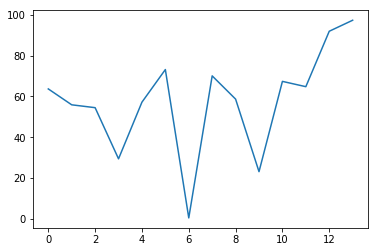

Episod:14, Step: 0, reward: 0
Episod:14, Step: 1, reward: 0
Episod:14, Step: 2, reward: 0
Episod:14, Step: 3, reward: 0
Episod:14, Step: 4, reward: 0
Episod:14, Step: 5, reward: 0
Episod:14, Step: 6, reward: 0
Episod:14, Step: 7, reward: 0
Episod:14, Step: 8, reward: 0
Episod:14, Step: 9, reward: 0
Episod:14, Step: 10, reward: 0
Episod:14, Step: 11, reward: 0
Episod:14, Step: 12, reward: 0
Episod:14, Step: 13, reward: 0
Episod:14, Step: 14, reward: 0
Episod:14, Step: 15, reward: 0
Episod:14, Step: 16, reward: 0
Episod:14, Step: 17, reward: 0
Episod:14, Step: 18, reward: 0
Episod:14, Step: 19, reward: 0
Episod:14, Step: 20, reward: 0
Episod:14, Step: 21, reward: 0
Episod:14, Step: 22, reward: 0
Episod:14, Step: 23, reward: 0
Episod:14, Step: 24, reward: 0
Episod:14, Step: 25, reward: 0
Episod:14, Step: 26, reward: 0
Episod:14, Step: 27, reward: 0
Episod:14, Step: 28, reward: 0
Episod:14, Step: 29, reward: 0
Episod:14, Step: 30, reward: 0
Episod:14, Step: 31, reward: 0
Episod:14, Step: 3

Episod:14, Step: 248, reward: 0.1
Episod:14, Step: 249, reward: 0.1
Episod:14, Step: 250, reward: 0.1
Episod:14, Step: 251, reward: 0.1
Episod:14, Step: 252, reward: 0.1
Episod:14, Step: 253, reward: 0.1
Episod:14, Step: 254, reward: 0.1
Episod:14, Step: 255, reward: 0.1
Episod:14, Step: 256, reward: 0.1
Episod:14, Step: 257, reward: 0.1
Episod:14, Step: 258, reward: 0.1
Episod:14, Step: 259, reward: 0.1
Episod:14, Step: 260, reward: 0.1
Episod:14, Step: 261, reward: 0.1
Episod:14, Step: 262, reward: 0.1
Episod:14, Step: 263, reward: 0.1
Episod:14, Step: 264, reward: 0.1
Episod:14, Step: 265, reward: 0.1
Episod:14, Step: 266, reward: 0.1
Episod:14, Step: 267, reward: 0.1
Episod:14, Step: 268, reward: 0.1
Episod:14, Step: 269, reward: 0.1
Episod:14, Step: 270, reward: 0.1
Episod:14, Step: 271, reward: 0.1
Episod:14, Step: 272, reward: 0.1
Episod:14, Step: 273, reward: 0.1
Episod:14, Step: 274, reward: 0.1
Episod:14, Step: 275, reward: 0.1
Episod:14, Step: 276, reward: 0.1
Episod:14, Ste

Episod:14, Step: 495, reward: 0.1
Episod:14, Step: 496, reward: 0.1
Episod:14, Step: 497, reward: 0.1
Episod:14, Step: 498, reward: 0.1
Episod:14, Step: 499, reward: 0.1
Episod:14, Step: 500, reward: 0.1
Episod:14, Step: 501, reward: 0.1
Episod:14, Step: 502, reward: 0.1
Episod:14, Step: 503, reward: 0.1
Episod:14, Step: 504, reward: 0.1
Episod:14, Step: 505, reward: 0.1
Episod:14, Step: 506, reward: 0.1
Episod:14, Step: 507, reward: 0.1
Episod:14, Step: 508, reward: 0.1
Episod:14, Step: 509, reward: 0.1
Episod:14, Step: 510, reward: 0.1
Episod:14, Step: 511, reward: 0.1
Episod:14, Step: 512, reward: 0.1
Episod:14, Step: 513, reward: 0.1
Episod:14, Step: 514, reward: 0.1
Episod:14, Step: 515, reward: 0.1
Episod:14, Step: 516, reward: 0.1
Episod:14, Step: 517, reward: 0.1
Episod:14, Step: 518, reward: 0.1
Episod:14, Step: 519, reward: 0.1
Episod:14, Step: 520, reward: 0.1
Episod:14, Step: 521, reward: 0.1
Episod:14, Step: 522, reward: 0.1
Episod:14, Step: 523, reward: 0.1
Episod:14, Ste

Episod:14, Step: 740, reward: 0.1
Episod:14, Step: 741, reward: 0.1
Episod:14, Step: 742, reward: 0.1
Episod:14, Step: 743, reward: 0.1
Episod:14, Step: 744, reward: 0.1
Episod:14, Step: 745, reward: 0.1
Episod:14, Step: 746, reward: 0.1
Episod:14, Step: 747, reward: 0.1
Episod:14, Step: 748, reward: 0.1
Episod:14, Step: 749, reward: 0.1
Episod:14, Step: 750, reward: 0.1
Episod:14, Step: 751, reward: 0.1
Episod:14, Step: 752, reward: 0.1
Episod:14, Step: 753, reward: 0.1
Episod:14, Step: 754, reward: 0.1
Episod:14, Step: 755, reward: 0.1
Episod:14, Step: 756, reward: 0.1
Episod:14, Step: 757, reward: 0.1
Episod:14, Step: 758, reward: 0.1
Episod:14, Step: 759, reward: 0.1
Episod:14, Step: 760, reward: 0.1
Episod:14, Step: 761, reward: 0.1
Episod:14, Step: 762, reward: 0.1
Episod:14, Step: 763, reward: 0.1
Episod:14, Step: 764, reward: 0.1
Episod:14, Step: 765, reward: 0.1
Episod:14, Step: 766, reward: 0.1
Episod:14, Step: 767, reward: 0.1
Episod:14, Step: 768, reward: 0.1
Episod:14, Ste

Episod:14, Step: 981, reward: 0.1
Episod:14, Step: 982, reward: 0.1
Episod:14, Step: 983, reward: 0.1
Episod:14, Step: 984, reward: 0.1
Episod:14, Step: 985, reward: 0.1
Episod:14, Step: 986, reward: 0.1
Episod:14, Step: 987, reward: 0.1
Episod:14, Step: 988, reward: 0.1
Episod:14, Step: 989, reward: 0.1
Episod:14, Step: 990, reward: 0.1
Episod:14, Step: 991, reward: 0.1
Episod:14, Step: 992, reward: 0.1
Episod:14, Step: 993, reward: 0.1
Episod:14, Step: 994, reward: 0.1
Episod:14, Step: 995, reward: 0.1
Episod:14, Step: 996, reward: 0.1
Episod:14, Step: 997, reward: 0.1
Episod:14, Step: 998, reward: 0.1
Episod:14, Step: 999, reward: 0.1
| Reward: 95 | Episode: 14 | Qmax: 2.1997


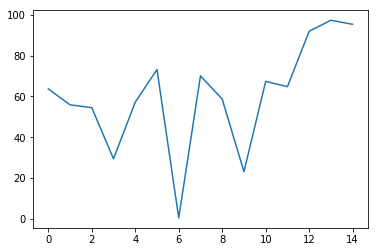

Episod:15, Step: 0, reward: 0
Episod:15, Step: 1, reward: 0
Episod:15, Step: 2, reward: 0
Episod:15, Step: 3, reward: 0
Episod:15, Step: 4, reward: 0
Episod:15, Step: 5, reward: 0
Episod:15, Step: 6, reward: 0
Episod:15, Step: 7, reward: 0
Episod:15, Step: 8, reward: 0
Episod:15, Step: 9, reward: 0
Episod:15, Step: 10, reward: 0
Episod:15, Step: 11, reward: 0
Episod:15, Step: 12, reward: 0
Episod:15, Step: 13, reward: 0
Episod:15, Step: 14, reward: 0
Episod:15, Step: 15, reward: 0
Episod:15, Step: 16, reward: 0
Episod:15, Step: 17, reward: 0
Episod:15, Step: 18, reward: 0
Episod:15, Step: 19, reward: 0
Episod:15, Step: 20, reward: 0
Episod:15, Step: 21, reward: 0
Episod:15, Step: 22, reward: 0
Episod:15, Step: 23, reward: 0
Episod:15, Step: 24, reward: 0
Episod:15, Step: 25, reward: 0
Episod:15, Step: 26, reward: 0
Episod:15, Step: 27, reward: 0
Episod:15, Step: 28, reward: 0
Episod:15, Step: 29, reward: 0
Episod:15, Step: 30, reward: 0
Episod:15, Step: 31, reward: 0
Episod:15, Step: 3

Episod:15, Step: 267, reward: 0
Episod:15, Step: 268, reward: 0
Episod:15, Step: 269, reward: 0
Episod:15, Step: 270, reward: 0
Episod:15, Step: 271, reward: 0
Episod:15, Step: 272, reward: 0
Episod:15, Step: 273, reward: 0
Episod:15, Step: 274, reward: 0
Episod:15, Step: 275, reward: 0
Episod:15, Step: 276, reward: 0
Episod:15, Step: 277, reward: 0
Episod:15, Step: 278, reward: 0
Episod:15, Step: 279, reward: 0
Episod:15, Step: 280, reward: 0
Episod:15, Step: 281, reward: 0
Episod:15, Step: 282, reward: 0
Episod:15, Step: 283, reward: 0
Episod:15, Step: 284, reward: 0
Episod:15, Step: 285, reward: 0
Episod:15, Step: 286, reward: 0
Episod:15, Step: 287, reward: 0
Episod:15, Step: 288, reward: 0
Episod:15, Step: 289, reward: 0
Episod:15, Step: 290, reward: 0
Episod:15, Step: 291, reward: 0
Episod:15, Step: 292, reward: 0
Episod:15, Step: 293, reward: 0
Episod:15, Step: 294, reward: 0
Episod:15, Step: 295, reward: 0
Episod:15, Step: 296, reward: 0
Episod:15, Step: 297, reward: 0
Episod:1

Episod:15, Step: 524, reward: 0
Episod:15, Step: 525, reward: 0
Episod:15, Step: 526, reward: 0
Episod:15, Step: 527, reward: 0
Episod:15, Step: 528, reward: 0
Episod:15, Step: 529, reward: 0
Episod:15, Step: 530, reward: 0
Episod:15, Step: 531, reward: 0
Episod:15, Step: 532, reward: 0
Episod:15, Step: 533, reward: 0
Episod:15, Step: 534, reward: 0
Episod:15, Step: 535, reward: 0
Episod:15, Step: 536, reward: 0.1
Episod:15, Step: 537, reward: 0.1
Episod:15, Step: 538, reward: 0.1
Episod:15, Step: 539, reward: 0.1
Episod:15, Step: 540, reward: 0.1
Episod:15, Step: 541, reward: 0.1
Episod:15, Step: 542, reward: 0.1
Episod:15, Step: 543, reward: 0.1
Episod:15, Step: 544, reward: 0.1
Episod:15, Step: 545, reward: 0.1
Episod:15, Step: 546, reward: 0.1
Episod:15, Step: 547, reward: 0.1
Episod:15, Step: 548, reward: 0.1
Episod:15, Step: 549, reward: 0.1
Episod:15, Step: 550, reward: 0.1
Episod:15, Step: 551, reward: 0.1
Episod:15, Step: 552, reward: 0.1
Episod:15, Step: 553, reward: 0.1
Epis

Episod:15, Step: 768, reward: 0.1
Episod:15, Step: 769, reward: 0.1
Episod:15, Step: 770, reward: 0.1
Episod:15, Step: 771, reward: 0.1
Episod:15, Step: 772, reward: 0.1
Episod:15, Step: 773, reward: 0.1
Episod:15, Step: 774, reward: 0.1
Episod:15, Step: 775, reward: 0.1
Episod:15, Step: 776, reward: 0.1
Episod:15, Step: 777, reward: 0.1
Episod:15, Step: 778, reward: 0.1
Episod:15, Step: 779, reward: 0.1
Episod:15, Step: 780, reward: 0.1
Episod:15, Step: 781, reward: 0.1
Episod:15, Step: 782, reward: 0.1
Episod:15, Step: 783, reward: 0.1
Episod:15, Step: 784, reward: 0.1
Episod:15, Step: 785, reward: 0.1
Episod:15, Step: 786, reward: 0.1
Episod:15, Step: 787, reward: 0.1
Episod:15, Step: 788, reward: 0.1
Episod:15, Step: 789, reward: 0.1
Episod:15, Step: 790, reward: 0.1
Episod:15, Step: 791, reward: 0.1
Episod:15, Step: 792, reward: 0.1
Episod:15, Step: 793, reward: 0.1
Episod:15, Step: 794, reward: 0.1
Episod:15, Step: 795, reward: 0.1
Episod:15, Step: 796, reward: 0.1
Episod:15, Ste

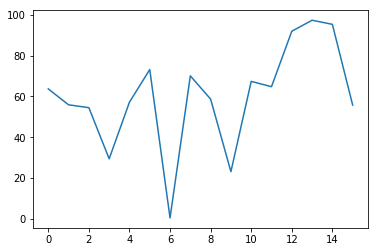

Episod:16, Step: 0, reward: 0.1
Episod:16, Step: 1, reward: 0.1
Episod:16, Step: 2, reward: 0.1
Episod:16, Step: 3, reward: 0.1
Episod:16, Step: 4, reward: 0.1
Episod:16, Step: 5, reward: 0.1
Episod:16, Step: 6, reward: 0.1
Episod:16, Step: 7, reward: 0.1
Episod:16, Step: 8, reward: 0.1
Episod:16, Step: 9, reward: 0.1
Episod:16, Step: 10, reward: 0.1
Episod:16, Step: 11, reward: 0.1
Episod:16, Step: 12, reward: 0.1
Episod:16, Step: 13, reward: 0.1
Episod:16, Step: 14, reward: 0.1
Episod:16, Step: 15, reward: 0.1
Episod:16, Step: 16, reward: 0.1
Episod:16, Step: 17, reward: 0.1
Episod:16, Step: 18, reward: 0.1
Episod:16, Step: 19, reward: 0.1
Episod:16, Step: 20, reward: 0.1
Episod:16, Step: 21, reward: 0.1
Episod:16, Step: 22, reward: 0.1
Episod:16, Step: 23, reward: 0.1
Episod:16, Step: 24, reward: 0.1
Episod:16, Step: 25, reward: 0.1
Episod:16, Step: 26, reward: 0.1
Episod:16, Step: 27, reward: 0.1
Episod:16, Step: 28, reward: 0.1
Episod:16, Step: 29, reward: 0.1
Episod:16, Step: 30,

Episod:16, Step: 250, reward: 0
Episod:16, Step: 251, reward: 0
Episod:16, Step: 252, reward: 0
Episod:16, Step: 253, reward: 0
Episod:16, Step: 254, reward: 0
Episod:16, Step: 255, reward: 0
Episod:16, Step: 256, reward: 0
Episod:16, Step: 257, reward: 0
Episod:16, Step: 258, reward: 0
Episod:16, Step: 259, reward: 0
Episod:16, Step: 260, reward: 0
Episod:16, Step: 261, reward: 0
Episod:16, Step: 262, reward: 0
Episod:16, Step: 263, reward: 0
Episod:16, Step: 264, reward: 0.1
Episod:16, Step: 265, reward: 0.1
Episod:16, Step: 266, reward: 0.1
Episod:16, Step: 267, reward: 0.1
Episod:16, Step: 268, reward: 0.1
Episod:16, Step: 269, reward: 0.1
Episod:16, Step: 270, reward: 0.1
Episod:16, Step: 271, reward: 0.1
Episod:16, Step: 272, reward: 0.1
Episod:16, Step: 273, reward: 0.1
Episod:16, Step: 274, reward: 0.1
Episod:16, Step: 275, reward: 0.1
Episod:16, Step: 276, reward: 0.1
Episod:16, Step: 277, reward: 0.1
Episod:16, Step: 278, reward: 0.1
Episod:16, Step: 279, reward: 0.1
Episod:1

Episod:16, Step: 501, reward: 0.1
Episod:16, Step: 502, reward: 0.1
Episod:16, Step: 503, reward: 0.1
Episod:16, Step: 504, reward: 0.1
Episod:16, Step: 505, reward: 0.1
Episod:16, Step: 506, reward: 0.1
Episod:16, Step: 507, reward: 0.1
Episod:16, Step: 508, reward: 0.1
Episod:16, Step: 509, reward: 0.1
Episod:16, Step: 510, reward: 0.1
Episod:16, Step: 511, reward: 0.1
Episod:16, Step: 512, reward: 0.1
Episod:16, Step: 513, reward: 0.1
Episod:16, Step: 514, reward: 0.1
Episod:16, Step: 515, reward: 0.1
Episod:16, Step: 516, reward: 0.1
Episod:16, Step: 517, reward: 0.1
Episod:16, Step: 518, reward: 0.1
Episod:16, Step: 519, reward: 0.1
Episod:16, Step: 520, reward: 0.1
Episod:16, Step: 521, reward: 0.1
Episod:16, Step: 522, reward: 0.1
Episod:16, Step: 523, reward: 0.1
Episod:16, Step: 524, reward: 0.1
Episod:16, Step: 525, reward: 0.1
Episod:16, Step: 526, reward: 0.1
Episod:16, Step: 527, reward: 0.1
Episod:16, Step: 528, reward: 0.1
Episod:16, Step: 529, reward: 0.1
Episod:16, Ste

Episod:16, Step: 758, reward: 0
Episod:16, Step: 759, reward: 0
Episod:16, Step: 760, reward: 0
Episod:16, Step: 761, reward: 0
Episod:16, Step: 762, reward: 0
Episod:16, Step: 763, reward: 0
Episod:16, Step: 764, reward: 0
Episod:16, Step: 765, reward: 0
Episod:16, Step: 766, reward: 0
Episod:16, Step: 767, reward: 0
Episod:16, Step: 768, reward: 0
Episod:16, Step: 769, reward: 0
Episod:16, Step: 770, reward: 0
Episod:16, Step: 771, reward: 0
Episod:16, Step: 772, reward: 0
Episod:16, Step: 773, reward: 0
Episod:16, Step: 774, reward: 0
Episod:16, Step: 775, reward: 0
Episod:16, Step: 776, reward: 0
Episod:16, Step: 777, reward: 0
Episod:16, Step: 778, reward: 0
Episod:16, Step: 779, reward: 0
Episod:16, Step: 780, reward: 0
Episod:16, Step: 781, reward: 0
Episod:16, Step: 782, reward: 0
Episod:16, Step: 783, reward: 0
Episod:16, Step: 784, reward: 0
Episod:16, Step: 785, reward: 0
Episod:16, Step: 786, reward: 0
Episod:16, Step: 787, reward: 0
Episod:16, Step: 788, reward: 0
Episod:1

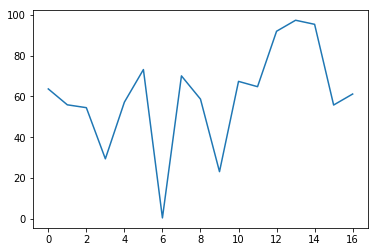

Episod:17, Step: 0, reward: 0.1
Episod:17, Step: 1, reward: 0.1
Episod:17, Step: 2, reward: 0.1
Episod:17, Step: 3, reward: 0.1
Episod:17, Step: 4, reward: 0.1
Episod:17, Step: 5, reward: 0.1
Episod:17, Step: 6, reward: 0.1
Episod:17, Step: 7, reward: 0.1
Episod:17, Step: 8, reward: 0.1
Episod:17, Step: 9, reward: 0.1
Episod:17, Step: 10, reward: 0.1
Episod:17, Step: 11, reward: 0.1
Episod:17, Step: 12, reward: 0.1
Episod:17, Step: 13, reward: 0.1
Episod:17, Step: 14, reward: 0.1
Episod:17, Step: 15, reward: 0.1
Episod:17, Step: 16, reward: 0.1
Episod:17, Step: 17, reward: 0
Episod:17, Step: 18, reward: 0
Episod:17, Step: 19, reward: 0
Episod:17, Step: 20, reward: 0
Episod:17, Step: 21, reward: 0
Episod:17, Step: 22, reward: 0
Episod:17, Step: 23, reward: 0
Episod:17, Step: 24, reward: 0
Episod:17, Step: 25, reward: 0
Episod:17, Step: 26, reward: 0
Episod:17, Step: 27, reward: 0
Episod:17, Step: 28, reward: 0
Episod:17, Step: 29, reward: 0
Episod:17, Step: 30, reward: 0
Episod:17, Step

Episod:17, Step: 260, reward: 0
Episod:17, Step: 261, reward: 0
Episod:17, Step: 262, reward: 0
Episod:17, Step: 263, reward: 0
Episod:17, Step: 264, reward: 0
Episod:17, Step: 265, reward: 0
Episod:17, Step: 266, reward: 0
Episod:17, Step: 267, reward: 0
Episod:17, Step: 268, reward: 0
Episod:17, Step: 269, reward: 0
Episod:17, Step: 270, reward: 0
Episod:17, Step: 271, reward: 0
Episod:17, Step: 272, reward: 0
Episod:17, Step: 273, reward: 0
Episod:17, Step: 274, reward: 0
Episod:17, Step: 275, reward: 0
Episod:17, Step: 276, reward: 0
Episod:17, Step: 277, reward: 0
Episod:17, Step: 278, reward: 0
Episod:17, Step: 279, reward: 0
Episod:17, Step: 280, reward: 0
Episod:17, Step: 281, reward: 0
Episod:17, Step: 282, reward: 0
Episod:17, Step: 283, reward: 0
Episod:17, Step: 284, reward: 0
Episod:17, Step: 285, reward: 0
Episod:17, Step: 286, reward: 0
Episod:17, Step: 287, reward: 0
Episod:17, Step: 288, reward: 0
Episod:17, Step: 289, reward: 0
Episod:17, Step: 290, reward: 0
Episod:1

Episod:17, Step: 513, reward: 0.1
Episod:17, Step: 514, reward: 0.1
Episod:17, Step: 515, reward: 0.1
Episod:17, Step: 516, reward: 0.1
Episod:17, Step: 517, reward: 0.1
Episod:17, Step: 518, reward: 0.1
Episod:17, Step: 519, reward: 0.1
Episod:17, Step: 520, reward: 0.1
Episod:17, Step: 521, reward: 0.1
Episod:17, Step: 522, reward: 0.1
Episod:17, Step: 523, reward: 0.1
Episod:17, Step: 524, reward: 0.1
Episod:17, Step: 525, reward: 0.1
Episod:17, Step: 526, reward: 0.1
Episod:17, Step: 527, reward: 0.1
Episod:17, Step: 528, reward: 0.1
Episod:17, Step: 529, reward: 0.1
Episod:17, Step: 530, reward: 0.1
Episod:17, Step: 531, reward: 0.1
Episod:17, Step: 532, reward: 0.1
Episod:17, Step: 533, reward: 0.1
Episod:17, Step: 534, reward: 0.1
Episod:17, Step: 535, reward: 0.1
Episod:17, Step: 536, reward: 0.1
Episod:17, Step: 537, reward: 0.1
Episod:17, Step: 538, reward: 0.1
Episod:17, Step: 539, reward: 0.1
Episod:17, Step: 540, reward: 0.1
Episod:17, Step: 541, reward: 0.1
Episod:17, Ste

Episod:17, Step: 770, reward: 0
Episod:17, Step: 771, reward: 0
Episod:17, Step: 772, reward: 0
Episod:17, Step: 773, reward: 0
Episod:17, Step: 774, reward: 0
Episod:17, Step: 775, reward: 0
Episod:17, Step: 776, reward: 0
Episod:17, Step: 777, reward: 0
Episod:17, Step: 778, reward: 0
Episod:17, Step: 779, reward: 0
Episod:17, Step: 780, reward: 0
Episod:17, Step: 781, reward: 0
Episod:17, Step: 782, reward: 0
Episod:17, Step: 783, reward: 0
Episod:17, Step: 784, reward: 0
Episod:17, Step: 785, reward: 0
Episod:17, Step: 786, reward: 0
Episod:17, Step: 787, reward: 0
Episod:17, Step: 788, reward: 0
Episod:17, Step: 789, reward: 0
Episod:17, Step: 790, reward: 0
Episod:17, Step: 791, reward: 0
Episod:17, Step: 792, reward: 0
Episod:17, Step: 793, reward: 0
Episod:17, Step: 794, reward: 0
Episod:17, Step: 795, reward: 0
Episod:17, Step: 796, reward: 0
Episod:17, Step: 797, reward: 0
Episod:17, Step: 798, reward: 0
Episod:17, Step: 799, reward: 0
Episod:17, Step: 800, reward: 0
Episod:1

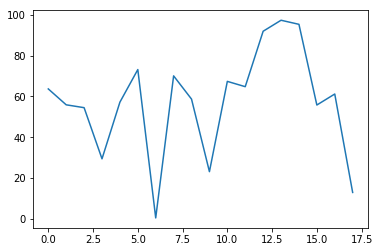

Episod:18, Step: 0, reward: 0
Episod:18, Step: 1, reward: 0
Episod:18, Step: 2, reward: 0
Episod:18, Step: 3, reward: 0
Episod:18, Step: 4, reward: 0
Episod:18, Step: 5, reward: 0
Episod:18, Step: 6, reward: 0
Episod:18, Step: 7, reward: 0
Episod:18, Step: 8, reward: 0
Episod:18, Step: 9, reward: 0
Episod:18, Step: 10, reward: 0
Episod:18, Step: 11, reward: 0
Episod:18, Step: 12, reward: 0
Episod:18, Step: 13, reward: 0
Episod:18, Step: 14, reward: 0
Episod:18, Step: 15, reward: 0
Episod:18, Step: 16, reward: 0
Episod:18, Step: 17, reward: 0
Episod:18, Step: 18, reward: 0
Episod:18, Step: 19, reward: 0
Episod:18, Step: 20, reward: 0
Episod:18, Step: 21, reward: 0
Episod:18, Step: 22, reward: 0
Episod:18, Step: 23, reward: 0
Episod:18, Step: 24, reward: 0
Episod:18, Step: 25, reward: 0.1
Episod:18, Step: 26, reward: 0.1
Episod:18, Step: 27, reward: 0.1
Episod:18, Step: 28, reward: 0.1
Episod:18, Step: 29, reward: 0.1
Episod:18, Step: 30, reward: 0.1
Episod:18, Step: 31, reward: 0.1
Epis

Episod:18, Step: 249, reward: 0
Episod:18, Step: 250, reward: 0
Episod:18, Step: 251, reward: 0
Episod:18, Step: 252, reward: 0
Episod:18, Step: 253, reward: 0
Episod:18, Step: 254, reward: 0
Episod:18, Step: 255, reward: 0
Episod:18, Step: 256, reward: 0
Episod:18, Step: 257, reward: 0
Episod:18, Step: 258, reward: 0
Episod:18, Step: 259, reward: 0
Episod:18, Step: 260, reward: 0
Episod:18, Step: 261, reward: 0
Episod:18, Step: 262, reward: 0
Episod:18, Step: 263, reward: 0.1
Episod:18, Step: 264, reward: 0.1
Episod:18, Step: 265, reward: 0.1
Episod:18, Step: 266, reward: 0.1
Episod:18, Step: 267, reward: 0.1
Episod:18, Step: 268, reward: 0.1
Episod:18, Step: 269, reward: 0.1
Episod:18, Step: 270, reward: 0.1
Episod:18, Step: 271, reward: 0.1
Episod:18, Step: 272, reward: 0.1
Episod:18, Step: 273, reward: 0.1
Episod:18, Step: 274, reward: 0.1
Episod:18, Step: 275, reward: 0.1
Episod:18, Step: 276, reward: 0.1
Episod:18, Step: 277, reward: 0.1
Episod:18, Step: 278, reward: 0.1
Episod:1

Episod:18, Step: 505, reward: 0
Episod:18, Step: 506, reward: 0
Episod:18, Step: 507, reward: 0
Episod:18, Step: 508, reward: 0
Episod:18, Step: 509, reward: 0
Episod:18, Step: 510, reward: 0
Episod:18, Step: 511, reward: 0
Episod:18, Step: 512, reward: 0
Episod:18, Step: 513, reward: 0
Episod:18, Step: 514, reward: 0
Episod:18, Step: 515, reward: 0
Episod:18, Step: 516, reward: 0
Episod:18, Step: 517, reward: 0
Episod:18, Step: 518, reward: 0
Episod:18, Step: 519, reward: 0
Episod:18, Step: 520, reward: 0
Episod:18, Step: 521, reward: 0
Episod:18, Step: 522, reward: 0
Episod:18, Step: 523, reward: 0
Episod:18, Step: 524, reward: 0
Episod:18, Step: 525, reward: 0
Episod:18, Step: 526, reward: 0
Episod:18, Step: 527, reward: 0
Episod:18, Step: 528, reward: 0
Episod:18, Step: 529, reward: 0
Episod:18, Step: 530, reward: 0.1
Episod:18, Step: 531, reward: 0.1
Episod:18, Step: 532, reward: 0.1
Episod:18, Step: 533, reward: 0.1
Episod:18, Step: 534, reward: 0.1
Episod:18, Step: 535, reward: 

Episod:18, Step: 751, reward: 0.1
Episod:18, Step: 752, reward: 0.1
Episod:18, Step: 753, reward: 0.1
Episod:18, Step: 754, reward: 0.1
Episod:18, Step: 755, reward: 0.1
Episod:18, Step: 756, reward: 0.1
Episod:18, Step: 757, reward: 0.1
Episod:18, Step: 758, reward: 0.1
Episod:18, Step: 759, reward: 0.1
Episod:18, Step: 760, reward: 0.1
Episod:18, Step: 761, reward: 0.1
Episod:18, Step: 762, reward: 0.1
Episod:18, Step: 763, reward: 0.1
Episod:18, Step: 764, reward: 0.1
Episod:18, Step: 765, reward: 0.1
Episod:18, Step: 766, reward: 0.1
Episod:18, Step: 767, reward: 0.1
Episod:18, Step: 768, reward: 0.1
Episod:18, Step: 769, reward: 0.1
Episod:18, Step: 770, reward: 0.1
Episod:18, Step: 771, reward: 0.1
Episod:18, Step: 772, reward: 0.1
Episod:18, Step: 773, reward: 0.1
Episod:18, Step: 774, reward: 0.1
Episod:18, Step: 775, reward: 0.1
Episod:18, Step: 776, reward: 0.1
Episod:18, Step: 777, reward: 0.1
Episod:18, Step: 778, reward: 0.1
Episod:18, Step: 779, reward: 0.1
Episod:18, Ste

Episod:18, Step: 996, reward: 0.1
Episod:18, Step: 997, reward: 0.1
Episod:18, Step: 998, reward: 0.1
Episod:18, Step: 999, reward: 0.1
| Reward: 75 | Episode: 18 | Qmax: 2.7945


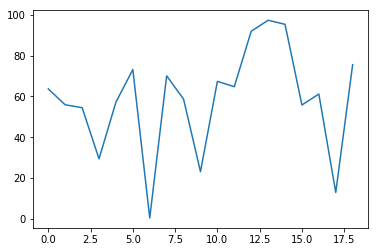

Episod:19, Step: 0, reward: 0.1
Episod:19, Step: 1, reward: 0.1
Episod:19, Step: 2, reward: 0.1
Episod:19, Step: 3, reward: 0.1
Episod:19, Step: 4, reward: 0.1
Episod:19, Step: 5, reward: 0.1
Episod:19, Step: 6, reward: 0.1
Episod:19, Step: 7, reward: 0.1
Episod:19, Step: 8, reward: 0.1
Episod:19, Step: 9, reward: 0.1
Episod:19, Step: 10, reward: 0.1
Episod:19, Step: 11, reward: 0.1
Episod:19, Step: 12, reward: 0.1
Episod:19, Step: 13, reward: 0.1
Episod:19, Step: 14, reward: 0.1
Episod:19, Step: 15, reward: 0.1
Episod:19, Step: 16, reward: 0.1
Episod:19, Step: 17, reward: 0.1
Episod:19, Step: 18, reward: 0.1
Episod:19, Step: 19, reward: 0.1
Episod:19, Step: 20, reward: 0.1
Episod:19, Step: 21, reward: 0.1
Episod:19, Step: 22, reward: 0.1
Episod:19, Step: 23, reward: 0.1
Episod:19, Step: 24, reward: 0.1
Episod:19, Step: 25, reward: 0.1
Episod:19, Step: 26, reward: 0.1
Episod:19, Step: 27, reward: 0.1
Episod:19, Step: 28, reward: 0.1
Episod:19, Step: 29, reward: 0.1
Episod:19, Step: 30,

Episod:19, Step: 251, reward: 0
Episod:19, Step: 252, reward: 0
Episod:19, Step: 253, reward: 0
Episod:19, Step: 254, reward: 0
Episod:19, Step: 255, reward: 0
Episod:19, Step: 256, reward: 0
Episod:19, Step: 257, reward: 0
Episod:19, Step: 258, reward: 0
Episod:19, Step: 259, reward: 0
Episod:19, Step: 260, reward: 0
Episod:19, Step: 261, reward: 0
Episod:19, Step: 262, reward: 0
Episod:19, Step: 263, reward: 0
Episod:19, Step: 264, reward: 0
Episod:19, Step: 265, reward: 0
Episod:19, Step: 266, reward: 0
Episod:19, Step: 267, reward: 0
Episod:19, Step: 268, reward: 0
Episod:19, Step: 269, reward: 0
Episod:19, Step: 270, reward: 0
Episod:19, Step: 271, reward: 0
Episod:19, Step: 272, reward: 0
Episod:19, Step: 273, reward: 0
Episod:19, Step: 274, reward: 0
Episod:19, Step: 275, reward: 0.1
Episod:19, Step: 276, reward: 0.1
Episod:19, Step: 277, reward: 0.1
Episod:19, Step: 278, reward: 0.1
Episod:19, Step: 279, reward: 0.1
Episod:19, Step: 280, reward: 0.1
Episod:19, Step: 281, reward

Episod:19, Step: 494, reward: 0.1
Episod:19, Step: 495, reward: 0.1
Episod:19, Step: 496, reward: 0.1
Episod:19, Step: 497, reward: 0.1
Episod:19, Step: 498, reward: 0.1
Episod:19, Step: 499, reward: 0.1
Episod:19, Step: 500, reward: 0.1
Episod:19, Step: 501, reward: 0.1
Episod:19, Step: 502, reward: 0.1
Episod:19, Step: 503, reward: 0.1
Episod:19, Step: 504, reward: 0.1
Episod:19, Step: 505, reward: 0.1
Episod:19, Step: 506, reward: 0.1
Episod:19, Step: 507, reward: 0.1
Episod:19, Step: 508, reward: 0.1
Episod:19, Step: 509, reward: 0.1
Episod:19, Step: 510, reward: 0.1
Episod:19, Step: 511, reward: 0.1
Episod:19, Step: 512, reward: 0.1
Episod:19, Step: 513, reward: 0.1
Episod:19, Step: 514, reward: 0.1
Episod:19, Step: 515, reward: 0.1
Episod:19, Step: 516, reward: 0.1
Episod:19, Step: 517, reward: 0.1
Episod:19, Step: 518, reward: 0.1
Episod:19, Step: 519, reward: 0.1
Episod:19, Step: 520, reward: 0.1
Episod:19, Step: 521, reward: 0.1
Episod:19, Step: 522, reward: 0.1
Episod:19, Ste

Episod:19, Step: 737, reward: 0.1
Episod:19, Step: 738, reward: 0.1
Episod:19, Step: 739, reward: 0.1
Episod:19, Step: 740, reward: 0.1
Episod:19, Step: 741, reward: 0.1
Episod:19, Step: 742, reward: 0.1
Episod:19, Step: 743, reward: 0.1
Episod:19, Step: 744, reward: 0.1
Episod:19, Step: 745, reward: 0.1
Episod:19, Step: 746, reward: 0.1
Episod:19, Step: 747, reward: 0.1
Episod:19, Step: 748, reward: 0.1
Episod:19, Step: 749, reward: 0.1
Episod:19, Step: 750, reward: 0.1
Episod:19, Step: 751, reward: 0.1
Episod:19, Step: 752, reward: 0.1
Episod:19, Step: 753, reward: 0.1
Episod:19, Step: 754, reward: 0.1
Episod:19, Step: 755, reward: 0.1
Episod:19, Step: 756, reward: 0.1
Episod:19, Step: 757, reward: 0.1
Episod:19, Step: 758, reward: 0.1
Episod:19, Step: 759, reward: 0.1
Episod:19, Step: 760, reward: 0.1
Episod:19, Step: 761, reward: 0.1
Episod:19, Step: 762, reward: 0.1
Episod:19, Step: 763, reward: 0.1
Episod:19, Step: 764, reward: 0.1
Episod:19, Step: 765, reward: 0.1
Episod:19, Ste

Episod:19, Step: 982, reward: 0.1
Episod:19, Step: 983, reward: 0.1
Episod:19, Step: 984, reward: 0.1
Episod:19, Step: 985, reward: 0.1
Episod:19, Step: 986, reward: 0.1
Episod:19, Step: 987, reward: 0.1
Episod:19, Step: 988, reward: 0.1
Episod:19, Step: 989, reward: 0.1
Episod:19, Step: 990, reward: 0.1
Episod:19, Step: 991, reward: 0.1
Episod:19, Step: 992, reward: 0.1
Episod:19, Step: 993, reward: 0.1
Episod:19, Step: 994, reward: 0.1
Episod:19, Step: 995, reward: 0.1
Episod:19, Step: 996, reward: 0.1
Episod:19, Step: 997, reward: 0.1
Episod:19, Step: 998, reward: 0.1
Episod:19, Step: 999, reward: 0.1
| Reward: 96 | Episode: 19 | Qmax: 2.9179


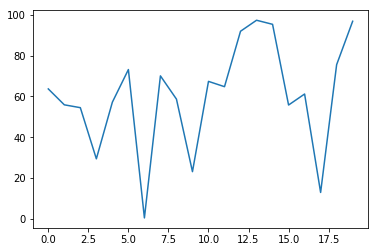

Episod:20, Step: 0, reward: 0.1
Episod:20, Step: 1, reward: 0.1
Episod:20, Step: 2, reward: 0.1
Episod:20, Step: 3, reward: 0.1
Episod:20, Step: 4, reward: 0.1
Episod:20, Step: 5, reward: 0.1
Episod:20, Step: 6, reward: 0.1
Episod:20, Step: 7, reward: 0.1
Episod:20, Step: 8, reward: 0.1
Episod:20, Step: 9, reward: 0.1
Episod:20, Step: 10, reward: 0.1
Episod:20, Step: 11, reward: 0.1
Episod:20, Step: 12, reward: 0.1
Episod:20, Step: 13, reward: 0.1
Episod:20, Step: 14, reward: 0.1
Episod:20, Step: 15, reward: 0.1
Episod:20, Step: 16, reward: 0.1
Episod:20, Step: 17, reward: 0.1
Episod:20, Step: 18, reward: 0.1
Episod:20, Step: 19, reward: 0.1
Episod:20, Step: 20, reward: 0.1
Episod:20, Step: 21, reward: 0.1
Episod:20, Step: 22, reward: 0.1
Episod:20, Step: 23, reward: 0.1
Episod:20, Step: 24, reward: 0.1
Episod:20, Step: 25, reward: 0.1
Episod:20, Step: 26, reward: 0.1
Episod:20, Step: 27, reward: 0.1
Episod:20, Step: 28, reward: 0.1
Episod:20, Step: 29, reward: 0.1
Episod:20, Step: 30,

Episod:20, Step: 249, reward: 0.1
Episod:20, Step: 250, reward: 0.1
Episod:20, Step: 251, reward: 0.1
Episod:20, Step: 252, reward: 0.1
Episod:20, Step: 253, reward: 0.1
Episod:20, Step: 254, reward: 0.1
Episod:20, Step: 255, reward: 0.1
Episod:20, Step: 256, reward: 0.1
Episod:20, Step: 257, reward: 0.1
Episod:20, Step: 258, reward: 0.1
Episod:20, Step: 259, reward: 0.1
Episod:20, Step: 260, reward: 0.1
Episod:20, Step: 261, reward: 0.1
Episod:20, Step: 262, reward: 0.1
Episod:20, Step: 263, reward: 0.1
Episod:20, Step: 264, reward: 0.1
Episod:20, Step: 265, reward: 0.1
Episod:20, Step: 266, reward: 0.1
Episod:20, Step: 267, reward: 0.1
Episod:20, Step: 268, reward: 0.1
Episod:20, Step: 269, reward: 0.1
Episod:20, Step: 270, reward: 0.1
Episod:20, Step: 271, reward: 0.1
Episod:20, Step: 272, reward: 0.1
Episod:20, Step: 273, reward: 0.1
Episod:20, Step: 274, reward: 0.1
Episod:20, Step: 275, reward: 0.1
Episod:20, Step: 276, reward: 0.1
Episod:20, Step: 277, reward: 0.1
Episod:20, Ste

Episod:20, Step: 491, reward: 0.1
Episod:20, Step: 492, reward: 0.1
Episod:20, Step: 493, reward: 0.1
Episod:20, Step: 494, reward: 0.1
Episod:20, Step: 495, reward: 0.1
Episod:20, Step: 496, reward: 0.1
Episod:20, Step: 497, reward: 0.1
Episod:20, Step: 498, reward: 0.1
Episod:20, Step: 499, reward: 0.1
Episod:20, Step: 500, reward: 0.1
Episod:20, Step: 501, reward: 0.1
Episod:20, Step: 502, reward: 0.1
Episod:20, Step: 503, reward: 0.1
Episod:20, Step: 504, reward: 0.1
Episod:20, Step: 505, reward: 0.1
Episod:20, Step: 506, reward: 0.1
Episod:20, Step: 507, reward: 0.1
Episod:20, Step: 508, reward: 0.1
Episod:20, Step: 509, reward: 0.1
Episod:20, Step: 510, reward: 0.1
Episod:20, Step: 511, reward: 0.1
Episod:20, Step: 512, reward: 0.1
Episod:20, Step: 513, reward: 0.1
Episod:20, Step: 514, reward: 0.1
Episod:20, Step: 515, reward: 0.1
Episod:20, Step: 516, reward: 0.1
Episod:20, Step: 517, reward: 0.1
Episod:20, Step: 518, reward: 0.1
Episod:20, Step: 519, reward: 0.1
Episod:20, Ste

Episod:20, Step: 734, reward: 0.1
Episod:20, Step: 735, reward: 0.1
Episod:20, Step: 736, reward: 0.1
Episod:20, Step: 737, reward: 0.1
Episod:20, Step: 738, reward: 0.1
Episod:20, Step: 739, reward: 0.1
Episod:20, Step: 740, reward: 0.1
Episod:20, Step: 741, reward: 0.1
Episod:20, Step: 742, reward: 0.1
Episod:20, Step: 743, reward: 0.1
Episod:20, Step: 744, reward: 0.1
Episod:20, Step: 745, reward: 0.1
Episod:20, Step: 746, reward: 0.1
Episod:20, Step: 747, reward: 0.1
Episod:20, Step: 748, reward: 0.1
Episod:20, Step: 749, reward: 0.1
Episod:20, Step: 750, reward: 0.1
Episod:20, Step: 751, reward: 0.1
Episod:20, Step: 752, reward: 0.1
Episod:20, Step: 753, reward: 0.1
Episod:20, Step: 754, reward: 0.1
Episod:20, Step: 755, reward: 0.1
Episod:20, Step: 756, reward: 0.1
Episod:20, Step: 757, reward: 0.1
Episod:20, Step: 758, reward: 0.1
Episod:20, Step: 759, reward: 0.1
Episod:20, Step: 760, reward: 0.1
Episod:20, Step: 761, reward: 0.1
Episod:20, Step: 762, reward: 0.1
Episod:20, Ste

Episod:20, Step: 979, reward: 0.1
Episod:20, Step: 980, reward: 0.1
Episod:20, Step: 981, reward: 0.1
Episod:20, Step: 982, reward: 0.1
Episod:20, Step: 983, reward: 0.1
Episod:20, Step: 984, reward: 0.1
Episod:20, Step: 985, reward: 0.1
Episod:20, Step: 986, reward: 0.1
Episod:20, Step: 987, reward: 0.1
Episod:20, Step: 988, reward: 0.1
Episod:20, Step: 989, reward: 0.1
Episod:20, Step: 990, reward: 0.1
Episod:20, Step: 991, reward: 0.1
Episod:20, Step: 992, reward: 0.1
Episod:20, Step: 993, reward: 0.1
Episod:20, Step: 994, reward: 0.1
Episod:20, Step: 995, reward: 0.1
Episod:20, Step: 996, reward: 0.1
Episod:20, Step: 997, reward: 0.1
Episod:20, Step: 998, reward: 0.1
Episod:20, Step: 999, reward: 0.1
| Reward: 99 | Episode: 20 | Qmax: 3.0238


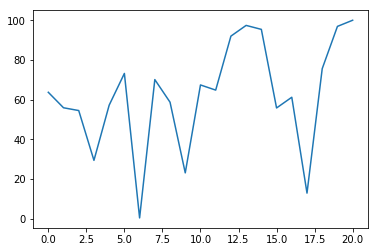

Episod:21, Step: 0, reward: 0.1
Episod:21, Step: 1, reward: 0.1
Episod:21, Step: 2, reward: 0.1
Episod:21, Step: 3, reward: 0.1
Episod:21, Step: 4, reward: 0.1
Episod:21, Step: 5, reward: 0.1
Episod:21, Step: 6, reward: 0.1
Episod:21, Step: 7, reward: 0.1
Episod:21, Step: 8, reward: 0.1
Episod:21, Step: 9, reward: 0.1
Episod:21, Step: 10, reward: 0.1
Episod:21, Step: 11, reward: 0.1
Episod:21, Step: 12, reward: 0.1
Episod:21, Step: 13, reward: 0.1
Episod:21, Step: 14, reward: 0.1
Episod:21, Step: 15, reward: 0.1
Episod:21, Step: 16, reward: 0.1
Episod:21, Step: 17, reward: 0.1
Episod:21, Step: 18, reward: 0.1
Episod:21, Step: 19, reward: 0.1
Episod:21, Step: 20, reward: 0.1
Episod:21, Step: 21, reward: 0.1
Episod:21, Step: 22, reward: 0.1
Episod:21, Step: 23, reward: 0.1
Episod:21, Step: 24, reward: 0.1
Episod:21, Step: 25, reward: 0.1
Episod:21, Step: 26, reward: 0.1
Episod:21, Step: 27, reward: 0.1
Episod:21, Step: 28, reward: 0.1
Episod:21, Step: 29, reward: 0.1
Episod:21, Step: 30,

Episod:21, Step: 251, reward: 0.1
Episod:21, Step: 252, reward: 0.1
Episod:21, Step: 253, reward: 0.1
Episod:21, Step: 254, reward: 0.1
Episod:21, Step: 255, reward: 0.1
Episod:21, Step: 256, reward: 0.1
Episod:21, Step: 257, reward: 0.1
Episod:21, Step: 258, reward: 0.1
Episod:21, Step: 259, reward: 0.1
Episod:21, Step: 260, reward: 0.1
Episod:21, Step: 261, reward: 0.1
Episod:21, Step: 262, reward: 0.1
Episod:21, Step: 263, reward: 0.1
Episod:21, Step: 264, reward: 0.1
Episod:21, Step: 265, reward: 0.1
Episod:21, Step: 266, reward: 0.1
Episod:21, Step: 267, reward: 0.1
Episod:21, Step: 268, reward: 0.1
Episod:21, Step: 269, reward: 0.1
Episod:21, Step: 270, reward: 0.1
Episod:21, Step: 271, reward: 0.1
Episod:21, Step: 272, reward: 0.1
Episod:21, Step: 273, reward: 0.1
Episod:21, Step: 274, reward: 0.1
Episod:21, Step: 275, reward: 0.1
Episod:21, Step: 276, reward: 0.1
Episod:21, Step: 277, reward: 0.1
Episod:21, Step: 278, reward: 0.1
Episod:21, Step: 279, reward: 0.1
Episod:21, Ste

Episod:21, Step: 492, reward: 0.1
Episod:21, Step: 493, reward: 0.1
Episod:21, Step: 494, reward: 0.1
Episod:21, Step: 495, reward: 0.1
Episod:21, Step: 496, reward: 0.1
Episod:21, Step: 497, reward: 0.1
Episod:21, Step: 498, reward: 0.1
Episod:21, Step: 499, reward: 0.1
Episod:21, Step: 500, reward: 0.1
Episod:21, Step: 501, reward: 0.1
Episod:21, Step: 502, reward: 0.1
Episod:21, Step: 503, reward: 0.1
Episod:21, Step: 504, reward: 0.1
Episod:21, Step: 505, reward: 0.1
Episod:21, Step: 506, reward: 0.1
Episod:21, Step: 507, reward: 0.1
Episod:21, Step: 508, reward: 0.1
Episod:21, Step: 509, reward: 0.1
Episod:21, Step: 510, reward: 0.1
Episod:21, Step: 511, reward: 0.1
Episod:21, Step: 512, reward: 0.1
Episod:21, Step: 513, reward: 0.1
Episod:21, Step: 514, reward: 0.1
Episod:21, Step: 515, reward: 0.1
Episod:21, Step: 516, reward: 0.1
Episod:21, Step: 517, reward: 0.1
Episod:21, Step: 518, reward: 0.1
Episod:21, Step: 519, reward: 0.1
Episod:21, Step: 520, reward: 0.1
Episod:21, Ste

Episod:21, Step: 740, reward: 0.1
Episod:21, Step: 741, reward: 0.1
Episod:21, Step: 742, reward: 0.1
Episod:21, Step: 743, reward: 0.1
Episod:21, Step: 744, reward: 0.1
Episod:21, Step: 745, reward: 0.1
Episod:21, Step: 746, reward: 0.1
Episod:21, Step: 747, reward: 0.1
Episod:21, Step: 748, reward: 0.1
Episod:21, Step: 749, reward: 0.1
Episod:21, Step: 750, reward: 0.1
Episod:21, Step: 751, reward: 0.1
Episod:21, Step: 752, reward: 0.1
Episod:21, Step: 753, reward: 0.1
Episod:21, Step: 754, reward: 0.1
Episod:21, Step: 755, reward: 0.1
Episod:21, Step: 756, reward: 0.1
Episod:21, Step: 757, reward: 0.1
Episod:21, Step: 758, reward: 0.1
Episod:21, Step: 759, reward: 0.1
Episod:21, Step: 760, reward: 0.1
Episod:21, Step: 761, reward: 0.1
Episod:21, Step: 762, reward: 0.1
Episod:21, Step: 763, reward: 0.1
Episod:21, Step: 764, reward: 0.1
Episod:21, Step: 765, reward: 0.1
Episod:21, Step: 766, reward: 0.1
Episod:21, Step: 767, reward: 0.1
Episod:21, Step: 768, reward: 0.1
Episod:21, Ste

Episod:21, Step: 987, reward: 0.1
Episod:21, Step: 988, reward: 0.1
Episod:21, Step: 989, reward: 0.1
Episod:21, Step: 990, reward: 0.1
Episod:21, Step: 991, reward: 0.1
Episod:21, Step: 992, reward: 0.1
Episod:21, Step: 993, reward: 0.1
Episod:21, Step: 994, reward: 0.1
Episod:21, Step: 995, reward: 0.1
Episod:21, Step: 996, reward: 0.1
Episod:21, Step: 997, reward: 0.1
Episod:21, Step: 998, reward: 0.1
Episod:21, Step: 999, reward: 0.1
| Reward: 99 | Episode: 21 | Qmax: 3.1277


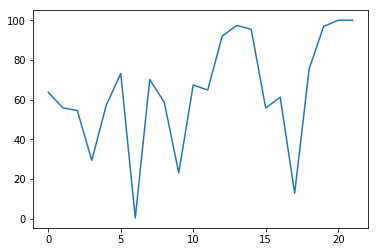

Episod:22, Step: 0, reward: 0.1
Episod:22, Step: 1, reward: 0.1
Episod:22, Step: 2, reward: 0.1
Episod:22, Step: 3, reward: 0.1
Episod:22, Step: 4, reward: 0.1
Episod:22, Step: 5, reward: 0.1
Episod:22, Step: 6, reward: 0.1
Episod:22, Step: 7, reward: 0.1
Episod:22, Step: 8, reward: 0.1
Episod:22, Step: 9, reward: 0.1
Episod:22, Step: 10, reward: 0.1
Episod:22, Step: 11, reward: 0.1
Episod:22, Step: 12, reward: 0.1
Episod:22, Step: 13, reward: 0.1
Episod:22, Step: 14, reward: 0.1
Episod:22, Step: 15, reward: 0.1
Episod:22, Step: 16, reward: 0.1
Episod:22, Step: 17, reward: 0.1
Episod:22, Step: 18, reward: 0.1
Episod:22, Step: 19, reward: 0.1
Episod:22, Step: 20, reward: 0.1
Episod:22, Step: 21, reward: 0.1
Episod:22, Step: 22, reward: 0.1
Episod:22, Step: 23, reward: 0.1
Episod:22, Step: 24, reward: 0.1
Episod:22, Step: 25, reward: 0.1
Episod:22, Step: 26, reward: 0.1
Episod:22, Step: 27, reward: 0.1
Episod:22, Step: 28, reward: 0.1
Episod:22, Step: 29, reward: 0.1
Episod:22, Step: 30,

Episod:22, Step: 245, reward: 0.1
Episod:22, Step: 246, reward: 0.1
Episod:22, Step: 247, reward: 0.1
Episod:22, Step: 248, reward: 0.1
Episod:22, Step: 249, reward: 0.1
Episod:22, Step: 250, reward: 0.1
Episod:22, Step: 251, reward: 0.1
Episod:22, Step: 252, reward: 0.1
Episod:22, Step: 253, reward: 0.1
Episod:22, Step: 254, reward: 0.1
Episod:22, Step: 255, reward: 0.1
Episod:22, Step: 256, reward: 0.1
Episod:22, Step: 257, reward: 0.1
Episod:22, Step: 258, reward: 0.1
Episod:22, Step: 259, reward: 0.1
Episod:22, Step: 260, reward: 0.1
Episod:22, Step: 261, reward: 0.1
Episod:22, Step: 262, reward: 0.1
Episod:22, Step: 263, reward: 0.1
Episod:22, Step: 264, reward: 0.1
Episod:22, Step: 265, reward: 0.1
Episod:22, Step: 266, reward: 0.1
Episod:22, Step: 267, reward: 0.1
Episod:22, Step: 268, reward: 0.1
Episod:22, Step: 269, reward: 0.1
Episod:22, Step: 270, reward: 0.1
Episod:22, Step: 271, reward: 0.1
Episod:22, Step: 272, reward: 0.1
Episod:22, Step: 273, reward: 0.1
Episod:22, Ste

Episod:22, Step: 504, reward: 0
Episod:22, Step: 505, reward: 0
Episod:22, Step: 506, reward: 0
Episod:22, Step: 507, reward: 0
Episod:22, Step: 508, reward: 0
Episod:22, Step: 509, reward: 0
Episod:22, Step: 510, reward: 0
Episod:22, Step: 511, reward: 0
Episod:22, Step: 512, reward: 0
Episod:22, Step: 513, reward: 0
Episod:22, Step: 514, reward: 0
Episod:22, Step: 515, reward: 0
Episod:22, Step: 516, reward: 0
Episod:22, Step: 517, reward: 0
Episod:22, Step: 518, reward: 0
Episod:22, Step: 519, reward: 0
Episod:22, Step: 520, reward: 0
Episod:22, Step: 521, reward: 0
Episod:22, Step: 522, reward: 0
Episod:22, Step: 523, reward: 0
Episod:22, Step: 524, reward: 0
Episod:22, Step: 525, reward: 0
Episod:22, Step: 526, reward: 0
Episod:22, Step: 527, reward: 0
Episod:22, Step: 528, reward: 0
Episod:22, Step: 529, reward: 0
Episod:22, Step: 530, reward: 0
Episod:22, Step: 531, reward: 0
Episod:22, Step: 532, reward: 0
Episod:22, Step: 533, reward: 0
Episod:22, Step: 534, reward: 0
Episod:2

Episod:22, Step: 758, reward: 0.1
Episod:22, Step: 759, reward: 0.1
Episod:22, Step: 760, reward: 0.1
Episod:22, Step: 761, reward: 0.1
Episod:22, Step: 762, reward: 0.1
Episod:22, Step: 763, reward: 0.1
Episod:22, Step: 764, reward: 0.1
Episod:22, Step: 765, reward: 0.1
Episod:22, Step: 766, reward: 0.1
Episod:22, Step: 767, reward: 0.1
Episod:22, Step: 768, reward: 0.1
Episod:22, Step: 769, reward: 0.1
Episod:22, Step: 770, reward: 0.1
Episod:22, Step: 771, reward: 0.1
Episod:22, Step: 772, reward: 0.1
Episod:22, Step: 773, reward: 0.1
Episod:22, Step: 774, reward: 0.1
Episod:22, Step: 775, reward: 0.1
Episod:22, Step: 776, reward: 0.1
Episod:22, Step: 777, reward: 0.1
Episod:22, Step: 778, reward: 0.1
Episod:22, Step: 779, reward: 0.1
Episod:22, Step: 780, reward: 0.1
Episod:22, Step: 781, reward: 0.1
Episod:22, Step: 782, reward: 0.1
Episod:22, Step: 783, reward: 0.1
Episod:22, Step: 784, reward: 0.1
Episod:22, Step: 785, reward: 0.1
Episod:22, Step: 786, reward: 0.1
Episod:22, Ste

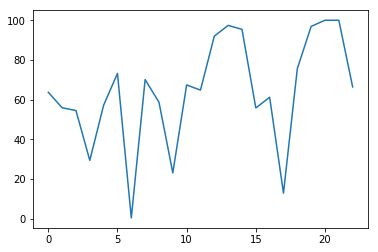

Episod:23, Step: 0, reward: 0
Episod:23, Step: 1, reward: 0
Episod:23, Step: 2, reward: 0
Episod:23, Step: 3, reward: 0
Episod:23, Step: 4, reward: 0
Episod:23, Step: 5, reward: 0
Episod:23, Step: 6, reward: 0
Episod:23, Step: 7, reward: 0
Episod:23, Step: 8, reward: 0
Episod:23, Step: 9, reward: 0
Episod:23, Step: 10, reward: 0
Episod:23, Step: 11, reward: 0
Episod:23, Step: 12, reward: 0
Episod:23, Step: 13, reward: 0
Episod:23, Step: 14, reward: 0
Episod:23, Step: 15, reward: 0
Episod:23, Step: 16, reward: 0
Episod:23, Step: 17, reward: 0
Episod:23, Step: 18, reward: 0
Episod:23, Step: 19, reward: 0
Episod:23, Step: 20, reward: 0
Episod:23, Step: 21, reward: 0
Episod:23, Step: 22, reward: 0
Episod:23, Step: 23, reward: 0
Episod:23, Step: 24, reward: 0
Episod:23, Step: 25, reward: 0
Episod:23, Step: 26, reward: 0
Episod:23, Step: 27, reward: 0
Episod:23, Step: 28, reward: 0
Episod:23, Step: 29, reward: 0
Episod:23, Step: 30, reward: 0
Episod:23, Step: 31, reward: 0
Episod:23, Step: 3

Episod:23, Step: 260, reward: 0
Episod:23, Step: 261, reward: 0
Episod:23, Step: 262, reward: 0
Episod:23, Step: 263, reward: 0
Episod:23, Step: 264, reward: 0
Episod:23, Step: 265, reward: 0
Episod:23, Step: 266, reward: 0
Episod:23, Step: 267, reward: 0
Episod:23, Step: 268, reward: 0
Episod:23, Step: 269, reward: 0
Episod:23, Step: 270, reward: 0
Episod:23, Step: 271, reward: 0
Episod:23, Step: 272, reward: 0
Episod:23, Step: 273, reward: 0
Episod:23, Step: 274, reward: 0
Episod:23, Step: 275, reward: 0.1
Episod:23, Step: 276, reward: 0.1
Episod:23, Step: 277, reward: 0.1
Episod:23, Step: 278, reward: 0.1
Episod:23, Step: 279, reward: 0.1
Episod:23, Step: 280, reward: 0.1
Episod:23, Step: 281, reward: 0.1
Episod:23, Step: 282, reward: 0.1
Episod:23, Step: 283, reward: 0.1
Episod:23, Step: 284, reward: 0.1
Episod:23, Step: 285, reward: 0.1
Episod:23, Step: 286, reward: 0.1
Episod:23, Step: 287, reward: 0.1
Episod:23, Step: 288, reward: 0.1
Episod:23, Step: 289, reward: 0.1
Episod:23,

Episod:23, Step: 508, reward: 0.1
Episod:23, Step: 509, reward: 0.1
Episod:23, Step: 510, reward: 0.1
Episod:23, Step: 511, reward: 0.1
Episod:23, Step: 512, reward: 0.1
Episod:23, Step: 513, reward: 0.1
Episod:23, Step: 514, reward: 0.1
Episod:23, Step: 515, reward: 0.1
Episod:23, Step: 516, reward: 0.1
Episod:23, Step: 517, reward: 0.1
Episod:23, Step: 518, reward: 0.1
Episod:23, Step: 519, reward: 0.1
Episod:23, Step: 520, reward: 0.1
Episod:23, Step: 521, reward: 0.1
Episod:23, Step: 522, reward: 0.1
Episod:23, Step: 523, reward: 0.1
Episod:23, Step: 524, reward: 0.1
Episod:23, Step: 525, reward: 0.1
Episod:23, Step: 526, reward: 0.1
Episod:23, Step: 527, reward: 0.1
Episod:23, Step: 528, reward: 0.1
Episod:23, Step: 529, reward: 0.1
Episod:23, Step: 530, reward: 0.1
Episod:23, Step: 531, reward: 0.1
Episod:23, Step: 532, reward: 0.1
Episod:23, Step: 533, reward: 0.1
Episod:23, Step: 534, reward: 0.1
Episod:23, Step: 535, reward: 0.1
Episod:23, Step: 536, reward: 0.1
Episod:23, Ste

Episod:23, Step: 755, reward: 0.1
Episod:23, Step: 756, reward: 0.1
Episod:23, Step: 757, reward: 0.1
Episod:23, Step: 758, reward: 0.1
Episod:23, Step: 759, reward: 0.1
Episod:23, Step: 760, reward: 0.1
Episod:23, Step: 761, reward: 0.1
Episod:23, Step: 762, reward: 0.1
Episod:23, Step: 763, reward: 0.1
Episod:23, Step: 764, reward: 0.1
Episod:23, Step: 765, reward: 0.1
Episod:23, Step: 766, reward: 0.1
Episod:23, Step: 767, reward: 0.1
Episod:23, Step: 768, reward: 0.1
Episod:23, Step: 769, reward: 0.1
Episod:23, Step: 770, reward: 0.1
Episod:23, Step: 771, reward: 0.1
Episod:23, Step: 772, reward: 0.1
Episod:23, Step: 773, reward: 0.1
Episod:23, Step: 774, reward: 0.1
Episod:23, Step: 775, reward: 0.1
Episod:23, Step: 776, reward: 0.1
Episod:23, Step: 777, reward: 0.1
Episod:23, Step: 778, reward: 0.1
Episod:23, Step: 779, reward: 0.1
Episod:23, Step: 780, reward: 0.1
Episod:23, Step: 781, reward: 0.1
Episod:23, Step: 782, reward: 0.1
Episod:23, Step: 783, reward: 0.1
Episod:23, Ste

Episod:23, Step: 998, reward: 0.1
Episod:23, Step: 999, reward: 0.1
| Reward: 71 | Episode: 23 | Qmax: 3.3604


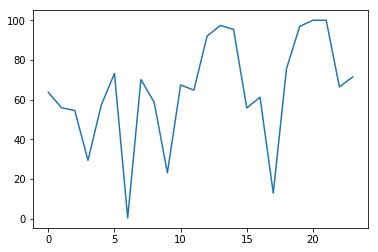

Episod:24, Step: 0, reward: 0.1
Episod:24, Step: 1, reward: 0.1
Episod:24, Step: 2, reward: 0.1
Episod:24, Step: 3, reward: 0.1
Episod:24, Step: 4, reward: 0.1
Episod:24, Step: 5, reward: 0.1
Episod:24, Step: 6, reward: 0.1
Episod:24, Step: 7, reward: 0.1
Episod:24, Step: 8, reward: 0.1
Episod:24, Step: 9, reward: 0.1
Episod:24, Step: 10, reward: 0.1
Episod:24, Step: 11, reward: 0.1
Episod:24, Step: 12, reward: 0.1
Episod:24, Step: 13, reward: 0.1
Episod:24, Step: 14, reward: 0.1
Episod:24, Step: 15, reward: 0.1
Episod:24, Step: 16, reward: 0.1
Episod:24, Step: 17, reward: 0.1
Episod:24, Step: 18, reward: 0.1
Episod:24, Step: 19, reward: 0.1
Episod:24, Step: 20, reward: 0.1
Episod:24, Step: 21, reward: 0.1
Episod:24, Step: 22, reward: 0.1
Episod:24, Step: 23, reward: 0.1
Episod:24, Step: 24, reward: 0.1
Episod:24, Step: 25, reward: 0.1
Episod:24, Step: 26, reward: 0.1
Episod:24, Step: 27, reward: 0.1
Episod:24, Step: 28, reward: 0.1
Episod:24, Step: 29, reward: 0.1
Episod:24, Step: 30,

Episod:24, Step: 249, reward: 0.1
Episod:24, Step: 250, reward: 0.1
Episod:24, Step: 251, reward: 0.1
Episod:24, Step: 252, reward: 0.1
Episod:24, Step: 253, reward: 0.1
Episod:24, Step: 254, reward: 0.1
Episod:24, Step: 255, reward: 0.1
Episod:24, Step: 256, reward: 0.1
Episod:24, Step: 257, reward: 0.1
Episod:24, Step: 258, reward: 0.1
Episod:24, Step: 259, reward: 0.1
Episod:24, Step: 260, reward: 0.1
Episod:24, Step: 261, reward: 0.1
Episod:24, Step: 262, reward: 0.1
Episod:24, Step: 263, reward: 0.1
Episod:24, Step: 264, reward: 0.1
Episod:24, Step: 265, reward: 0.1
Episod:24, Step: 266, reward: 0.1
Episod:24, Step: 267, reward: 0.1
Episod:24, Step: 268, reward: 0.1
Episod:24, Step: 269, reward: 0.1
Episod:24, Step: 270, reward: 0.1
Episod:24, Step: 271, reward: 0.1
Episod:24, Step: 272, reward: 0.1
Episod:24, Step: 273, reward: 0.1
Episod:24, Step: 274, reward: 0.1
Episod:24, Step: 275, reward: 0.1
Episod:24, Step: 276, reward: 0.1
Episod:24, Step: 277, reward: 0.1
Episod:24, Ste

Episod:24, Step: 496, reward: 0
Episod:24, Step: 497, reward: 0
Episod:24, Step: 498, reward: 0
Episod:24, Step: 499, reward: 0
Episod:24, Step: 500, reward: 0
Episod:24, Step: 501, reward: 0
Episod:24, Step: 502, reward: 0
Episod:24, Step: 503, reward: 0
Episod:24, Step: 504, reward: 0
Episod:24, Step: 505, reward: 0
Episod:24, Step: 506, reward: 0
Episod:24, Step: 507, reward: 0
Episod:24, Step: 508, reward: 0
Episod:24, Step: 509, reward: 0
Episod:24, Step: 510, reward: 0
Episod:24, Step: 511, reward: 0
Episod:24, Step: 512, reward: 0
Episod:24, Step: 513, reward: 0
Episod:24, Step: 514, reward: 0
Episod:24, Step: 515, reward: 0
Episod:24, Step: 516, reward: 0
Episod:24, Step: 517, reward: 0
Episod:24, Step: 518, reward: 0
Episod:24, Step: 519, reward: 0
Episod:24, Step: 520, reward: 0
Episod:24, Step: 521, reward: 0
Episod:24, Step: 522, reward: 0
Episod:24, Step: 523, reward: 0
Episod:24, Step: 524, reward: 0
Episod:24, Step: 525, reward: 0
Episod:24, Step: 526, reward: 0
Episod:2

Episod:24, Step: 757, reward: 0
Episod:24, Step: 758, reward: 0
Episod:24, Step: 759, reward: 0
Episod:24, Step: 760, reward: 0
Episod:24, Step: 761, reward: 0
Episod:24, Step: 762, reward: 0
Episod:24, Step: 763, reward: 0
Episod:24, Step: 764, reward: 0
Episod:24, Step: 765, reward: 0
Episod:24, Step: 766, reward: 0
Episod:24, Step: 767, reward: 0
Episod:24, Step: 768, reward: 0
Episod:24, Step: 769, reward: 0
Episod:24, Step: 770, reward: 0
Episod:24, Step: 771, reward: 0
Episod:24, Step: 772, reward: 0
Episod:24, Step: 773, reward: 0
Episod:24, Step: 774, reward: 0
Episod:24, Step: 775, reward: 0
Episod:24, Step: 776, reward: 0
Episod:24, Step: 777, reward: 0
Episod:24, Step: 778, reward: 0
Episod:24, Step: 779, reward: 0
Episod:24, Step: 780, reward: 0
Episod:24, Step: 781, reward: 0
Episod:24, Step: 782, reward: 0
Episod:24, Step: 783, reward: 0
Episod:24, Step: 784, reward: 0
Episod:24, Step: 785, reward: 0
Episod:24, Step: 786, reward: 0
Episod:24, Step: 787, reward: 0
Episod:2

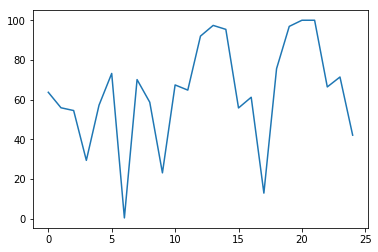

Episod:25, Step: 0, reward: 0.1
Episod:25, Step: 1, reward: 0.1
Episod:25, Step: 2, reward: 0.1
Episod:25, Step: 3, reward: 0.1
Episod:25, Step: 4, reward: 0.1
Episod:25, Step: 5, reward: 0.1
Episod:25, Step: 6, reward: 0.1
Episod:25, Step: 7, reward: 0.1
Episod:25, Step: 8, reward: 0.1
Episod:25, Step: 9, reward: 0.1
Episod:25, Step: 10, reward: 0.1
Episod:25, Step: 11, reward: 0.1
Episod:25, Step: 12, reward: 0.1
Episod:25, Step: 13, reward: 0.1
Episod:25, Step: 14, reward: 0.1
Episod:25, Step: 15, reward: 0.1
Episod:25, Step: 16, reward: 0.1
Episod:25, Step: 17, reward: 0.1
Episod:25, Step: 18, reward: 0.1
Episod:25, Step: 19, reward: 0.1
Episod:25, Step: 20, reward: 0.1
Episod:25, Step: 21, reward: 0.1
Episod:25, Step: 22, reward: 0.1
Episod:25, Step: 23, reward: 0.1
Episod:25, Step: 24, reward: 0.1
Episod:25, Step: 25, reward: 0.1
Episod:25, Step: 26, reward: 0.1
Episod:25, Step: 27, reward: 0.1
Episod:25, Step: 28, reward: 0.1
Episod:25, Step: 29, reward: 0.1
Episod:25, Step: 30,

Episod:25, Step: 246, reward: 0.1
Episod:25, Step: 247, reward: 0.1
Episod:25, Step: 248, reward: 0.1
Episod:25, Step: 249, reward: 0.1
Episod:25, Step: 250, reward: 0.1
Episod:25, Step: 251, reward: 0.1
Episod:25, Step: 252, reward: 0.1
Episod:25, Step: 253, reward: 0.1
Episod:25, Step: 254, reward: 0.1
Episod:25, Step: 255, reward: 0.1
Episod:25, Step: 256, reward: 0.1
Episod:25, Step: 257, reward: 0.1
Episod:25, Step: 258, reward: 0.1
Episod:25, Step: 259, reward: 0.1
Episod:25, Step: 260, reward: 0.1
Episod:25, Step: 261, reward: 0.1
Episod:25, Step: 262, reward: 0.1
Episod:25, Step: 263, reward: 0.1
Episod:25, Step: 264, reward: 0.1
Episod:25, Step: 265, reward: 0.1
Episod:25, Step: 266, reward: 0.1
Episod:25, Step: 267, reward: 0.1
Episod:25, Step: 268, reward: 0.1
Episod:25, Step: 269, reward: 0.1
Episod:25, Step: 270, reward: 0.1
Episod:25, Step: 271, reward: 0.1
Episod:25, Step: 272, reward: 0.1
Episod:25, Step: 273, reward: 0.1
Episod:25, Step: 274, reward: 0.1
Episod:25, Ste

Episod:25, Step: 487, reward: 0.1
Episod:25, Step: 488, reward: 0.1
Episod:25, Step: 489, reward: 0.1
Episod:25, Step: 490, reward: 0.1
Episod:25, Step: 491, reward: 0.1
Episod:25, Step: 492, reward: 0.1
Episod:25, Step: 493, reward: 0.1
Episod:25, Step: 494, reward: 0.1
Episod:25, Step: 495, reward: 0.1
Episod:25, Step: 496, reward: 0.1
Episod:25, Step: 497, reward: 0.1
Episod:25, Step: 498, reward: 0.1
Episod:25, Step: 499, reward: 0.1
Episod:25, Step: 500, reward: 0.1
Episod:25, Step: 501, reward: 0.1
Episod:25, Step: 502, reward: 0.1
Episod:25, Step: 503, reward: 0.1
Episod:25, Step: 504, reward: 0.1
Episod:25, Step: 505, reward: 0.1
Episod:25, Step: 506, reward: 0.1
Episod:25, Step: 507, reward: 0.1
Episod:25, Step: 508, reward: 0.1
Episod:25, Step: 509, reward: 0.1
Episod:25, Step: 510, reward: 0.1
Episod:25, Step: 511, reward: 0.1
Episod:25, Step: 512, reward: 0.1
Episod:25, Step: 513, reward: 0.1
Episod:25, Step: 514, reward: 0.1
Episod:25, Step: 515, reward: 0.1
Episod:25, Ste

Episod:25, Step: 736, reward: 0
Episod:25, Step: 737, reward: 0
Episod:25, Step: 738, reward: 0
Episod:25, Step: 739, reward: 0
Episod:25, Step: 740, reward: 0
Episod:25, Step: 741, reward: 0
Episod:25, Step: 742, reward: 0
Episod:25, Step: 743, reward: 0
Episod:25, Step: 744, reward: 0
Episod:25, Step: 745, reward: 0
Episod:25, Step: 746, reward: 0
Episod:25, Step: 747, reward: 0
Episod:25, Step: 748, reward: 0
Episod:25, Step: 749, reward: 0
Episod:25, Step: 750, reward: 0
Episod:25, Step: 751, reward: 0
Episod:25, Step: 752, reward: 0
Episod:25, Step: 753, reward: 0
Episod:25, Step: 754, reward: 0
Episod:25, Step: 755, reward: 0
Episod:25, Step: 756, reward: 0
Episod:25, Step: 757, reward: 0
Episod:25, Step: 758, reward: 0
Episod:25, Step: 759, reward: 0
Episod:25, Step: 760, reward: 0
Episod:25, Step: 761, reward: 0
Episod:25, Step: 762, reward: 0
Episod:25, Step: 763, reward: 0
Episod:25, Step: 764, reward: 0
Episod:25, Step: 765, reward: 0
Episod:25, Step: 766, reward: 0
Episod:2

Episod:25, Step: 999, reward: 0
| Reward: 64 | Episode: 25 | Qmax: 3.5740


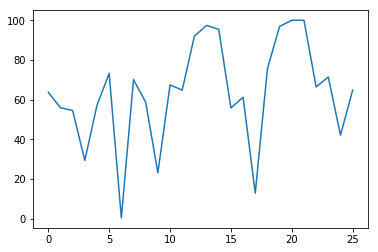

Episod:26, Step: 0, reward: 0
Episod:26, Step: 1, reward: 0
Episod:26, Step: 2, reward: 0
Episod:26, Step: 3, reward: 0
Episod:26, Step: 4, reward: 0
Episod:26, Step: 5, reward: 0
Episod:26, Step: 6, reward: 0
Episod:26, Step: 7, reward: 0
Episod:26, Step: 8, reward: 0
Episod:26, Step: 9, reward: 0
Episod:26, Step: 10, reward: 0.1
Episod:26, Step: 11, reward: 0.1
Episod:26, Step: 12, reward: 0.1
Episod:26, Step: 13, reward: 0.1
Episod:26, Step: 14, reward: 0.1
Episod:26, Step: 15, reward: 0.1
Episod:26, Step: 16, reward: 0.1
Episod:26, Step: 17, reward: 0.1
Episod:26, Step: 18, reward: 0.1
Episod:26, Step: 19, reward: 0.1
Episod:26, Step: 20, reward: 0.1
Episod:26, Step: 21, reward: 0.1
Episod:26, Step: 22, reward: 0.1
Episod:26, Step: 23, reward: 0.1
Episod:26, Step: 24, reward: 0.1
Episod:26, Step: 25, reward: 0.1
Episod:26, Step: 26, reward: 0.1
Episod:26, Step: 27, reward: 0.1
Episod:26, Step: 28, reward: 0.1
Episod:26, Step: 29, reward: 0.1
Episod:26, Step: 30, reward: 0.1
Episod:

Episod:26, Step: 246, reward: 0.1
Episod:26, Step: 247, reward: 0.1
Episod:26, Step: 248, reward: 0.1
Episod:26, Step: 249, reward: 0.1
Episod:26, Step: 250, reward: 0.1
Episod:26, Step: 251, reward: 0.1
Episod:26, Step: 252, reward: 0.1
Episod:26, Step: 253, reward: 0.1
Episod:26, Step: 254, reward: 0.1
Episod:26, Step: 255, reward: 0.1
Episod:26, Step: 256, reward: 0.1
Episod:26, Step: 257, reward: 0.1
Episod:26, Step: 258, reward: 0.1
Episod:26, Step: 259, reward: 0.1
Episod:26, Step: 260, reward: 0.1
Episod:26, Step: 261, reward: 0.1
Episod:26, Step: 262, reward: 0.1
Episod:26, Step: 263, reward: 0.1
Episod:26, Step: 264, reward: 0.1
Episod:26, Step: 265, reward: 0.1
Episod:26, Step: 266, reward: 0.1
Episod:26, Step: 267, reward: 0.1
Episod:26, Step: 268, reward: 0.1
Episod:26, Step: 269, reward: 0.1
Episod:26, Step: 270, reward: 0.1
Episod:26, Step: 271, reward: 0.1
Episod:26, Step: 272, reward: 0.1
Episod:26, Step: 273, reward: 0.1
Episod:26, Step: 274, reward: 0.1
Episod:26, Ste

Episod:26, Step: 490, reward: 0.1
Episod:26, Step: 491, reward: 0.1
Episod:26, Step: 492, reward: 0.1
Episod:26, Step: 493, reward: 0.1
Episod:26, Step: 494, reward: 0.1
Episod:26, Step: 495, reward: 0.1
Episod:26, Step: 496, reward: 0.1
Episod:26, Step: 497, reward: 0.1
Episod:26, Step: 498, reward: 0.1
Episod:26, Step: 499, reward: 0.1
Episod:26, Step: 500, reward: 0.1
Episod:26, Step: 501, reward: 0.1
Episod:26, Step: 502, reward: 0.1
Episod:26, Step: 503, reward: 0.1
Episod:26, Step: 504, reward: 0.1
Episod:26, Step: 505, reward: 0.1
Episod:26, Step: 506, reward: 0.1
Episod:26, Step: 507, reward: 0.1
Episod:26, Step: 508, reward: 0.1
Episod:26, Step: 509, reward: 0.1
Episod:26, Step: 510, reward: 0.1
Episod:26, Step: 511, reward: 0.1
Episod:26, Step: 512, reward: 0.1
Episod:26, Step: 513, reward: 0.1
Episod:26, Step: 514, reward: 0.1
Episod:26, Step: 515, reward: 0.1
Episod:26, Step: 516, reward: 0.1
Episod:26, Step: 517, reward: 0.1
Episod:26, Step: 518, reward: 0.1
Episod:26, Ste

Episod:26, Step: 736, reward: 0.1
Episod:26, Step: 737, reward: 0.1
Episod:26, Step: 738, reward: 0.1
Episod:26, Step: 739, reward: 0.1
Episod:26, Step: 740, reward: 0.1
Episod:26, Step: 741, reward: 0.1
Episod:26, Step: 742, reward: 0.1
Episod:26, Step: 743, reward: 0.1
Episod:26, Step: 744, reward: 0.1
Episod:26, Step: 745, reward: 0.1
Episod:26, Step: 746, reward: 0.1
Episod:26, Step: 747, reward: 0.1
Episod:26, Step: 748, reward: 0.1
Episod:26, Step: 749, reward: 0.1
Episod:26, Step: 750, reward: 0.1
Episod:26, Step: 751, reward: 0.1
Episod:26, Step: 752, reward: 0.1
Episod:26, Step: 753, reward: 0.1
Episod:26, Step: 754, reward: 0.1
Episod:26, Step: 755, reward: 0.1
Episod:26, Step: 756, reward: 0.1
Episod:26, Step: 757, reward: 0.1
Episod:26, Step: 758, reward: 0.1
Episod:26, Step: 759, reward: 0.1
Episod:26, Step: 760, reward: 0.1
Episod:26, Step: 761, reward: 0.1
Episod:26, Step: 762, reward: 0.1
Episod:26, Step: 763, reward: 0.1
Episod:26, Step: 764, reward: 0.1
Episod:26, Ste

Episod:26, Step: 980, reward: 0.1
Episod:26, Step: 981, reward: 0.1
Episod:26, Step: 982, reward: 0.1
Episod:26, Step: 983, reward: 0.1
Episod:26, Step: 984, reward: 0.1
Episod:26, Step: 985, reward: 0.1
Episod:26, Step: 986, reward: 0.1
Episod:26, Step: 987, reward: 0.1
Episod:26, Step: 988, reward: 0.1
Episod:26, Step: 989, reward: 0.1
Episod:26, Step: 990, reward: 0.1
Episod:26, Step: 991, reward: 0.1
Episod:26, Step: 992, reward: 0.1
Episod:26, Step: 993, reward: 0.1
Episod:26, Step: 994, reward: 0.1
Episod:26, Step: 995, reward: 0.1
Episod:26, Step: 996, reward: 0.1
Episod:26, Step: 997, reward: 0.1
Episod:26, Step: 998, reward: 0.1
Episod:26, Step: 999, reward: 0.1
| Reward: 98 | Episode: 26 | Qmax: 3.6976


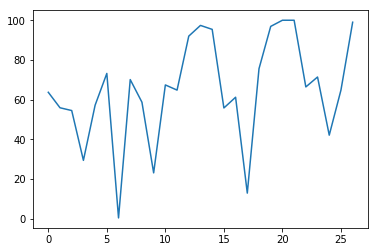

Episod:27, Step: 0, reward: 0.1
Episod:27, Step: 1, reward: 0.1
Episod:27, Step: 2, reward: 0.1
Episod:27, Step: 3, reward: 0.1
Episod:27, Step: 4, reward: 0.1
Episod:27, Step: 5, reward: 0.1
Episod:27, Step: 6, reward: 0.1
Episod:27, Step: 7, reward: 0.1
Episod:27, Step: 8, reward: 0.1
Episod:27, Step: 9, reward: 0.1
Episod:27, Step: 10, reward: 0.1
Episod:27, Step: 11, reward: 0.1
Episod:27, Step: 12, reward: 0.1
Episod:27, Step: 13, reward: 0.1
Episod:27, Step: 14, reward: 0.1
Episod:27, Step: 15, reward: 0.1
Episod:27, Step: 16, reward: 0.1
Episod:27, Step: 17, reward: 0.1
Episod:27, Step: 18, reward: 0.1
Episod:27, Step: 19, reward: 0.1
Episod:27, Step: 20, reward: 0.1
Episod:27, Step: 21, reward: 0.1
Episod:27, Step: 22, reward: 0.1
Episod:27, Step: 23, reward: 0.1
Episod:27, Step: 24, reward: 0.1
Episod:27, Step: 25, reward: 0.1
Episod:27, Step: 26, reward: 0.1
Episod:27, Step: 27, reward: 0.1
Episod:27, Step: 28, reward: 0.1
Episod:27, Step: 29, reward: 0.1
Episod:27, Step: 30,

Episod:27, Step: 247, reward: 0.1
Episod:27, Step: 248, reward: 0.1
Episod:27, Step: 249, reward: 0.1
Episod:27, Step: 250, reward: 0.1
Episod:27, Step: 251, reward: 0.1
Episod:27, Step: 252, reward: 0.1
Episod:27, Step: 253, reward: 0.1
Episod:27, Step: 254, reward: 0.1
Episod:27, Step: 255, reward: 0.1
Episod:27, Step: 256, reward: 0.1
Episod:27, Step: 257, reward: 0.1
Episod:27, Step: 258, reward: 0.1
Episod:27, Step: 259, reward: 0.1
Episod:27, Step: 260, reward: 0.1
Episod:27, Step: 261, reward: 0.1
Episod:27, Step: 262, reward: 0.1
Episod:27, Step: 263, reward: 0.1
Episod:27, Step: 264, reward: 0.1
Episod:27, Step: 265, reward: 0.1
Episod:27, Step: 266, reward: 0.1
Episod:27, Step: 267, reward: 0.1
Episod:27, Step: 268, reward: 0.1
Episod:27, Step: 269, reward: 0.1
Episod:27, Step: 270, reward: 0.1
Episod:27, Step: 271, reward: 0.1
Episod:27, Step: 272, reward: 0.1
Episod:27, Step: 273, reward: 0.1
Episod:27, Step: 274, reward: 0.1
Episod:27, Step: 275, reward: 0.1
Episod:27, Ste

Episod:27, Step: 495, reward: 0.1
Episod:27, Step: 496, reward: 0.1
Episod:27, Step: 497, reward: 0.1
Episod:27, Step: 498, reward: 0.1
Episod:27, Step: 499, reward: 0.1
Episod:27, Step: 500, reward: 0.1
Episod:27, Step: 501, reward: 0.1
Episod:27, Step: 502, reward: 0.1
Episod:27, Step: 503, reward: 0.1
Episod:27, Step: 504, reward: 0.1
Episod:27, Step: 505, reward: 0.1
Episod:27, Step: 506, reward: 0.1
Episod:27, Step: 507, reward: 0.1
Episod:27, Step: 508, reward: 0.1
Episod:27, Step: 509, reward: 0.1
Episod:27, Step: 510, reward: 0.1
Episod:27, Step: 511, reward: 0.1
Episod:27, Step: 512, reward: 0.1
Episod:27, Step: 513, reward: 0.1
Episod:27, Step: 514, reward: 0.1
Episod:27, Step: 515, reward: 0.1
Episod:27, Step: 516, reward: 0.1
Episod:27, Step: 517, reward: 0.1
Episod:27, Step: 518, reward: 0.1
Episod:27, Step: 519, reward: 0.1
Episod:27, Step: 520, reward: 0.1
Episod:27, Step: 521, reward: 0.1
Episod:27, Step: 522, reward: 0.1
Episod:27, Step: 523, reward: 0.1
Episod:27, Ste

Episod:27, Step: 743, reward: 0.1
Episod:27, Step: 744, reward: 0.1
Episod:27, Step: 745, reward: 0.1
Episod:27, Step: 746, reward: 0.1
Episod:27, Step: 747, reward: 0.1
Episod:27, Step: 748, reward: 0.1
Episod:27, Step: 749, reward: 0.1
Episod:27, Step: 750, reward: 0.1
Episod:27, Step: 751, reward: 0.1
Episod:27, Step: 752, reward: 0.1
Episod:27, Step: 753, reward: 0.1
Episod:27, Step: 754, reward: 0.1
Episod:27, Step: 755, reward: 0.1
Episod:27, Step: 756, reward: 0.1
Episod:27, Step: 757, reward: 0.1
Episod:27, Step: 758, reward: 0.1
Episod:27, Step: 759, reward: 0.1
Episod:27, Step: 760, reward: 0.1
Episod:27, Step: 761, reward: 0.1
Episod:27, Step: 762, reward: 0.1
Episod:27, Step: 763, reward: 0.1
Episod:27, Step: 764, reward: 0.1
Episod:27, Step: 765, reward: 0.1
Episod:27, Step: 766, reward: 0.1
Episod:27, Step: 767, reward: 0.1
Episod:27, Step: 768, reward: 0.1
Episod:27, Step: 769, reward: 0.1
Episod:27, Step: 770, reward: 0.1
Episod:27, Step: 771, reward: 0.1
Episod:27, Ste

Episod:27, Step: 984, reward: 0.1
Episod:27, Step: 985, reward: 0.1
Episod:27, Step: 986, reward: 0.1
Episod:27, Step: 987, reward: 0.1
Episod:27, Step: 988, reward: 0.1
Episod:27, Step: 989, reward: 0.1
Episod:27, Step: 990, reward: 0.1
Episod:27, Step: 991, reward: 0.1
Episod:27, Step: 992, reward: 0.1
Episod:27, Step: 993, reward: 0.1
Episod:27, Step: 994, reward: 0.1
Episod:27, Step: 995, reward: 0.1
Episod:27, Step: 996, reward: 0.1
Episod:27, Step: 997, reward: 0.1
Episod:27, Step: 998, reward: 0.1
Episod:27, Step: 999, reward: 0.1
| Reward: 99 | Episode: 27 | Qmax: 3.8144


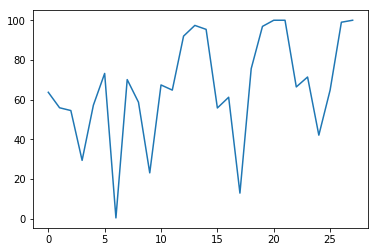

Episod:28, Step: 0, reward: 0.1
Episod:28, Step: 1, reward: 0.1
Episod:28, Step: 2, reward: 0.1
Episod:28, Step: 3, reward: 0.1
Episod:28, Step: 4, reward: 0.1
Episod:28, Step: 5, reward: 0.1
Episod:28, Step: 6, reward: 0.1
Episod:28, Step: 7, reward: 0.1
Episod:28, Step: 8, reward: 0.1
Episod:28, Step: 9, reward: 0.1
Episod:28, Step: 10, reward: 0.1
Episod:28, Step: 11, reward: 0.1
Episod:28, Step: 12, reward: 0.1
Episod:28, Step: 13, reward: 0.1
Episod:28, Step: 14, reward: 0.1
Episod:28, Step: 15, reward: 0.1
Episod:28, Step: 16, reward: 0.1
Episod:28, Step: 17, reward: 0.1
Episod:28, Step: 18, reward: 0.1
Episod:28, Step: 19, reward: 0.1
Episod:28, Step: 20, reward: 0.1
Episod:28, Step: 21, reward: 0.1
Episod:28, Step: 22, reward: 0.1
Episod:28, Step: 23, reward: 0.1
Episod:28, Step: 24, reward: 0.1
Episod:28, Step: 25, reward: 0.1
Episod:28, Step: 26, reward: 0.1
Episod:28, Step: 27, reward: 0.1
Episod:28, Step: 28, reward: 0.1
Episod:28, Step: 29, reward: 0.1
Episod:28, Step: 30,

Episod:28, Step: 249, reward: 0.1
Episod:28, Step: 250, reward: 0.1
Episod:28, Step: 251, reward: 0.1
Episod:28, Step: 252, reward: 0.1
Episod:28, Step: 253, reward: 0.1
Episod:28, Step: 254, reward: 0.1
Episod:28, Step: 255, reward: 0.1
Episod:28, Step: 256, reward: 0.1
Episod:28, Step: 257, reward: 0.1
Episod:28, Step: 258, reward: 0.1
Episod:28, Step: 259, reward: 0.1
Episod:28, Step: 260, reward: 0.1
Episod:28, Step: 261, reward: 0.1
Episod:28, Step: 262, reward: 0.1
Episod:28, Step: 263, reward: 0.1
Episod:28, Step: 264, reward: 0.1
Episod:28, Step: 265, reward: 0.1
Episod:28, Step: 266, reward: 0.1
Episod:28, Step: 267, reward: 0.1
Episod:28, Step: 268, reward: 0.1
Episod:28, Step: 269, reward: 0.1
Episod:28, Step: 270, reward: 0.1
Episod:28, Step: 271, reward: 0.1
Episod:28, Step: 272, reward: 0.1
Episod:28, Step: 273, reward: 0.1
Episod:28, Step: 274, reward: 0.1
Episod:28, Step: 275, reward: 0.1
Episod:28, Step: 276, reward: 0.1
Episod:28, Step: 277, reward: 0.1
Episod:28, Ste

Episod:28, Step: 493, reward: 0.1
Episod:28, Step: 494, reward: 0.1
Episod:28, Step: 495, reward: 0.1
Episod:28, Step: 496, reward: 0.1
Episod:28, Step: 497, reward: 0.1
Episod:28, Step: 498, reward: 0.1
Episod:28, Step: 499, reward: 0.1
Episod:28, Step: 500, reward: 0.1
Episod:28, Step: 501, reward: 0.1
Episod:28, Step: 502, reward: 0
Episod:28, Step: 503, reward: 0
Episod:28, Step: 504, reward: 0
Episod:28, Step: 505, reward: 0
Episod:28, Step: 506, reward: 0
Episod:28, Step: 507, reward: 0
Episod:28, Step: 508, reward: 0
Episod:28, Step: 509, reward: 0
Episod:28, Step: 510, reward: 0.1
Episod:28, Step: 511, reward: 0.1
Episod:28, Step: 512, reward: 0.1
Episod:28, Step: 513, reward: 0.1
Episod:28, Step: 514, reward: 0.1
Episod:28, Step: 515, reward: 0.1
Episod:28, Step: 516, reward: 0.1
Episod:28, Step: 517, reward: 0.1
Episod:28, Step: 518, reward: 0.1
Episod:28, Step: 519, reward: 0.1
Episod:28, Step: 520, reward: 0.1
Episod:28, Step: 521, reward: 0.1
Episod:28, Step: 522, reward: 

Episod:28, Step: 738, reward: 0.1
Episod:28, Step: 739, reward: 0.1
Episod:28, Step: 740, reward: 0.1
Episod:28, Step: 741, reward: 0.1
Episod:28, Step: 742, reward: 0.1
Episod:28, Step: 743, reward: 0.1
Episod:28, Step: 744, reward: 0.1
Episod:28, Step: 745, reward: 0.1
Episod:28, Step: 746, reward: 0.1
Episod:28, Step: 747, reward: 0.1
Episod:28, Step: 748, reward: 0.1
Episod:28, Step: 749, reward: 0.1
Episod:28, Step: 750, reward: 0.1
Episod:28, Step: 751, reward: 0.1
Episod:28, Step: 752, reward: 0.1
Episod:28, Step: 753, reward: 0.1
Episod:28, Step: 754, reward: 0.1
Episod:28, Step: 755, reward: 0.1
Episod:28, Step: 756, reward: 0.1
Episod:28, Step: 757, reward: 0.1
Episod:28, Step: 758, reward: 0.1
Episod:28, Step: 759, reward: 0.1
Episod:28, Step: 760, reward: 0.1
Episod:28, Step: 761, reward: 0.1
Episod:28, Step: 762, reward: 0.1
Episod:28, Step: 763, reward: 0.1
Episod:28, Step: 764, reward: 0.1
Episod:28, Step: 765, reward: 0.1
Episod:28, Step: 766, reward: 0.1
Episod:28, Ste

Episod:28, Step: 979, reward: 0.1
Episod:28, Step: 980, reward: 0.1
Episod:28, Step: 981, reward: 0.1
Episod:28, Step: 982, reward: 0.1
Episod:28, Step: 983, reward: 0.1
Episod:28, Step: 984, reward: 0.1
Episod:28, Step: 985, reward: 0.1
Episod:28, Step: 986, reward: 0.1
Episod:28, Step: 987, reward: 0.1
Episod:28, Step: 988, reward: 0.1
Episod:28, Step: 989, reward: 0.1
Episod:28, Step: 990, reward: 0.1
Episod:28, Step: 991, reward: 0.1
Episod:28, Step: 992, reward: 0.1
Episod:28, Step: 993, reward: 0.1
Episod:28, Step: 994, reward: 0.1
Episod:28, Step: 995, reward: 0.1
Episod:28, Step: 996, reward: 0.1
Episod:28, Step: 997, reward: 0.1
Episod:28, Step: 998, reward: 0.1
Episod:28, Step: 999, reward: 0.1
| Reward: 99 | Episode: 28 | Qmax: 3.9325


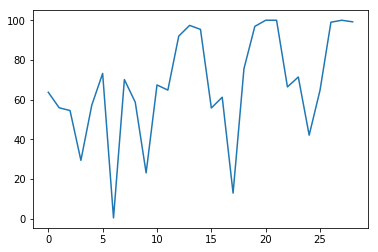

Episod:29, Step: 0, reward: 0.1
Episod:29, Step: 1, reward: 0.1
Episod:29, Step: 2, reward: 0.1
Episod:29, Step: 3, reward: 0.1
Episod:29, Step: 4, reward: 0.1
Episod:29, Step: 5, reward: 0.1
Episod:29, Step: 6, reward: 0.1
Episod:29, Step: 7, reward: 0.1
Episod:29, Step: 8, reward: 0.1
Episod:29, Step: 9, reward: 0.1
Episod:29, Step: 10, reward: 0.1
Episod:29, Step: 11, reward: 0.1
Episod:29, Step: 12, reward: 0.1
Episod:29, Step: 13, reward: 0.1
Episod:29, Step: 14, reward: 0.1
Episod:29, Step: 15, reward: 0.1
Episod:29, Step: 16, reward: 0.1
Episod:29, Step: 17, reward: 0.1
Episod:29, Step: 18, reward: 0.1
Episod:29, Step: 19, reward: 0.1
Episod:29, Step: 20, reward: 0.1
Episod:29, Step: 21, reward: 0.1
Episod:29, Step: 22, reward: 0.1
Episod:29, Step: 23, reward: 0.1
Episod:29, Step: 24, reward: 0.1
Episod:29, Step: 25, reward: 0.1
Episod:29, Step: 26, reward: 0.1
Episod:29, Step: 27, reward: 0.1
Episod:29, Step: 28, reward: 0.1
Episod:29, Step: 29, reward: 0.1
Episod:29, Step: 30,

Episod:29, Step: 245, reward: 0.1
Episod:29, Step: 246, reward: 0.1
Episod:29, Step: 247, reward: 0.1
Episod:29, Step: 248, reward: 0.1
Episod:29, Step: 249, reward: 0.1
Episod:29, Step: 250, reward: 0.1
Episod:29, Step: 251, reward: 0.1
Episod:29, Step: 252, reward: 0.1
Episod:29, Step: 253, reward: 0.1
Episod:29, Step: 254, reward: 0.1
Episod:29, Step: 255, reward: 0.1
Episod:29, Step: 256, reward: 0.1
Episod:29, Step: 257, reward: 0.1
Episod:29, Step: 258, reward: 0.1
Episod:29, Step: 259, reward: 0.1
Episod:29, Step: 260, reward: 0.1
Episod:29, Step: 261, reward: 0.1
Episod:29, Step: 262, reward: 0.1
Episod:29, Step: 263, reward: 0.1
Episod:29, Step: 264, reward: 0.1
Episod:29, Step: 265, reward: 0.1
Episod:29, Step: 266, reward: 0.1
Episod:29, Step: 267, reward: 0.1
Episod:29, Step: 268, reward: 0.1
Episod:29, Step: 269, reward: 0.1
Episod:29, Step: 270, reward: 0.1
Episod:29, Step: 271, reward: 0.1
Episod:29, Step: 272, reward: 0.1
Episod:29, Step: 273, reward: 0.1
Episod:29, Ste

Episod:29, Step: 493, reward: 0.1
Episod:29, Step: 494, reward: 0.1
Episod:29, Step: 495, reward: 0.1
Episod:29, Step: 496, reward: 0.1
Episod:29, Step: 497, reward: 0.1
Episod:29, Step: 498, reward: 0.1
Episod:29, Step: 499, reward: 0.1
Episod:29, Step: 500, reward: 0.1
Episod:29, Step: 501, reward: 0.1
Episod:29, Step: 502, reward: 0.1
Episod:29, Step: 503, reward: 0.1
Episod:29, Step: 504, reward: 0.1
Episod:29, Step: 505, reward: 0.1
Episod:29, Step: 506, reward: 0.1
Episod:29, Step: 507, reward: 0.1
Episod:29, Step: 508, reward: 0.1
Episod:29, Step: 509, reward: 0.1
Episod:29, Step: 510, reward: 0.1
Episod:29, Step: 511, reward: 0.1
Episod:29, Step: 512, reward: 0.1
Episod:29, Step: 513, reward: 0.1
Episod:29, Step: 514, reward: 0.1
Episod:29, Step: 515, reward: 0.1
Episod:29, Step: 516, reward: 0.1
Episod:29, Step: 517, reward: 0.1
Episod:29, Step: 518, reward: 0.1
Episod:29, Step: 519, reward: 0.1
Episod:29, Step: 520, reward: 0.1
Episod:29, Step: 521, reward: 0.1
Episod:29, Ste

Episod:29, Step: 745, reward: 0
Episod:29, Step: 746, reward: 0
Episod:29, Step: 747, reward: 0
Episod:29, Step: 748, reward: 0
Episod:29, Step: 749, reward: 0
Episod:29, Step: 750, reward: 0
Episod:29, Step: 751, reward: 0
Episod:29, Step: 752, reward: 0
Episod:29, Step: 753, reward: 0
Episod:29, Step: 754, reward: 0
Episod:29, Step: 755, reward: 0
Episod:29, Step: 756, reward: 0
Episod:29, Step: 757, reward: 0
Episod:29, Step: 758, reward: 0
Episod:29, Step: 759, reward: 0
Episod:29, Step: 760, reward: 0
Episod:29, Step: 761, reward: 0
Episod:29, Step: 762, reward: 0
Episod:29, Step: 763, reward: 0
Episod:29, Step: 764, reward: 0
Episod:29, Step: 765, reward: 0
Episod:29, Step: 766, reward: 0
Episod:29, Step: 767, reward: 0
Episod:29, Step: 768, reward: 0
Episod:29, Step: 769, reward: 0
Episod:29, Step: 770, reward: 0
Episod:29, Step: 771, reward: 0
Episod:29, Step: 772, reward: 0
Episod:29, Step: 773, reward: 0
Episod:29, Step: 774, reward: 0
Episod:29, Step: 775, reward: 0
Episod:2

Episod:29, Step: 993, reward: 0.1
Episod:29, Step: 994, reward: 0.1
Episod:29, Step: 995, reward: 0.1
Episod:29, Step: 996, reward: 0.1
Episod:29, Step: 997, reward: 0.1
Episod:29, Step: 998, reward: 0.1
Episod:29, Step: 999, reward: 0.1
| Reward: 74 | Episode: 29 | Qmax: 4.0396


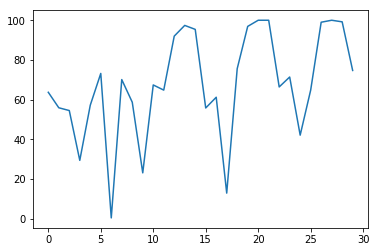

Episod:30, Step: 0, reward: 0
Episod:30, Step: 1, reward: 0
Episod:30, Step: 2, reward: 0
Episod:30, Step: 3, reward: 0.1
Episod:30, Step: 4, reward: 0.1
Episod:30, Step: 5, reward: 0.1
Episod:30, Step: 6, reward: 0.1
Episod:30, Step: 7, reward: 0.1
Episod:30, Step: 8, reward: 0
Episod:30, Step: 9, reward: 0.1
Episod:30, Step: 10, reward: 0.1
Episod:30, Step: 11, reward: 0.1
Episod:30, Step: 12, reward: 0.1
Episod:30, Step: 13, reward: 0.1
Episod:30, Step: 14, reward: 0.1
Episod:30, Step: 15, reward: 0.1
Episod:30, Step: 16, reward: 0.1
Episod:30, Step: 17, reward: 0.1
Episod:30, Step: 18, reward: 0.1
Episod:30, Step: 19, reward: 0.1
Episod:30, Step: 20, reward: 0.1
Episod:30, Step: 21, reward: 0
Episod:30, Step: 22, reward: 0
Episod:30, Step: 23, reward: 0
Episod:30, Step: 24, reward: 0
Episod:30, Step: 25, reward: 0
Episod:30, Step: 26, reward: 0
Episod:30, Step: 27, reward: 0.1
Episod:30, Step: 28, reward: 0.1
Episod:30, Step: 29, reward: 0.1
Episod:30, Step: 30, reward: 0.1
Episod:

Episod:30, Step: 252, reward: 0.1
Episod:30, Step: 253, reward: 0.1
Episod:30, Step: 254, reward: 0.1
Episod:30, Step: 255, reward: 0.1
Episod:30, Step: 256, reward: 0.1
Episod:30, Step: 257, reward: 0.1
Episod:30, Step: 258, reward: 0.1
Episod:30, Step: 259, reward: 0.1
Episod:30, Step: 260, reward: 0.1
Episod:30, Step: 261, reward: 0.1
Episod:30, Step: 262, reward: 0.1
Episod:30, Step: 263, reward: 0.1
Episod:30, Step: 264, reward: 0.1
Episod:30, Step: 265, reward: 0.1
Episod:30, Step: 266, reward: 0.1
Episod:30, Step: 267, reward: 0.1
Episod:30, Step: 268, reward: 0.1
Episod:30, Step: 269, reward: 0.1
Episod:30, Step: 270, reward: 0.1
Episod:30, Step: 271, reward: 0.1
Episod:30, Step: 272, reward: 0.1
Episod:30, Step: 273, reward: 0.1
Episod:30, Step: 274, reward: 0.1
Episod:30, Step: 275, reward: 0.1
Episod:30, Step: 276, reward: 0.1
Episod:30, Step: 277, reward: 0.1
Episod:30, Step: 278, reward: 0.1
Episod:30, Step: 279, reward: 0.1
Episod:30, Step: 280, reward: 0.1
Episod:30, Ste

Episod:30, Step: 508, reward: 0.1
Episod:30, Step: 509, reward: 0.1
Episod:30, Step: 510, reward: 0.1
Episod:30, Step: 511, reward: 0.1
Episod:30, Step: 512, reward: 0.1
Episod:30, Step: 513, reward: 0.1
Episod:30, Step: 514, reward: 0.1
Episod:30, Step: 515, reward: 0.1
Episod:30, Step: 516, reward: 0.1
Episod:30, Step: 517, reward: 0.1
Episod:30, Step: 518, reward: 0.1
Episod:30, Step: 519, reward: 0.1
Episod:30, Step: 520, reward: 0.1
Episod:30, Step: 521, reward: 0.1
Episod:30, Step: 522, reward: 0.1
Episod:30, Step: 523, reward: 0.1
Episod:30, Step: 524, reward: 0.1
Episod:30, Step: 525, reward: 0.1
Episod:30, Step: 526, reward: 0.1
Episod:30, Step: 527, reward: 0.1
Episod:30, Step: 528, reward: 0.1
Episod:30, Step: 529, reward: 0.1
Episod:30, Step: 530, reward: 0.1
Episod:30, Step: 531, reward: 0.1
Episod:30, Step: 532, reward: 0.1
Episod:30, Step: 533, reward: 0.1
Episod:30, Step: 534, reward: 0.1
Episod:30, Step: 535, reward: 0.1
Episod:30, Step: 536, reward: 0.1
Episod:30, Ste

Episod:30, Step: 754, reward: 0.1
Episod:30, Step: 755, reward: 0.1
Episod:30, Step: 756, reward: 0.1
Episod:30, Step: 757, reward: 0.1
Episod:30, Step: 758, reward: 0.1
Episod:30, Step: 759, reward: 0.1
Episod:30, Step: 760, reward: 0.1
Episod:30, Step: 761, reward: 0.1
Episod:30, Step: 762, reward: 0.1
Episod:30, Step: 763, reward: 0.1
Episod:30, Step: 764, reward: 0.1
Episod:30, Step: 765, reward: 0.1
Episod:30, Step: 766, reward: 0.1
Episod:30, Step: 767, reward: 0.1
Episod:30, Step: 768, reward: 0.1
Episod:30, Step: 769, reward: 0.1
Episod:30, Step: 770, reward: 0.1
Episod:30, Step: 771, reward: 0.1
Episod:30, Step: 772, reward: 0.1
Episod:30, Step: 773, reward: 0.1
Episod:30, Step: 774, reward: 0.1
Episod:30, Step: 775, reward: 0.1
Episod:30, Step: 776, reward: 0.1
Episod:30, Step: 777, reward: 0.1
Episod:30, Step: 778, reward: 0.1
Episod:30, Step: 779, reward: 0.1
Episod:30, Step: 780, reward: 0.1
Episod:30, Step: 781, reward: 0.1
Episod:30, Step: 782, reward: 0.1
Episod:30, Ste

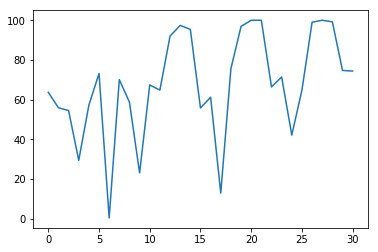

Episod:31, Step: 0, reward: 0.1
Episod:31, Step: 1, reward: 0.1
Episod:31, Step: 2, reward: 0.1
Episod:31, Step: 3, reward: 0.1
Episod:31, Step: 4, reward: 0.1
Episod:31, Step: 5, reward: 0.1
Episod:31, Step: 6, reward: 0.1
Episod:31, Step: 7, reward: 0.1
Episod:31, Step: 8, reward: 0.1
Episod:31, Step: 9, reward: 0.1
Episod:31, Step: 10, reward: 0.1
Episod:31, Step: 11, reward: 0.1
Episod:31, Step: 12, reward: 0.1
Episod:31, Step: 13, reward: 0.1
Episod:31, Step: 14, reward: 0.1
Episod:31, Step: 15, reward: 0.1
Episod:31, Step: 16, reward: 0.1
Episod:31, Step: 17, reward: 0.1
Episod:31, Step: 18, reward: 0.1
Episod:31, Step: 19, reward: 0.1
Episod:31, Step: 20, reward: 0.1
Episod:31, Step: 21, reward: 0.1
Episod:31, Step: 22, reward: 0.1
Episod:31, Step: 23, reward: 0.1
Episod:31, Step: 24, reward: 0.1
Episod:31, Step: 25, reward: 0.1
Episod:31, Step: 26, reward: 0.1
Episod:31, Step: 27, reward: 0.1
Episod:31, Step: 28, reward: 0.1
Episod:31, Step: 29, reward: 0.1
Episod:31, Step: 30,

Episod:31, Step: 260, reward: 0
Episod:31, Step: 261, reward: 0
Episod:31, Step: 262, reward: 0
Episod:31, Step: 263, reward: 0
Episod:31, Step: 264, reward: 0
Episod:31, Step: 265, reward: 0
Episod:31, Step: 266, reward: 0
Episod:31, Step: 267, reward: 0
Episod:31, Step: 268, reward: 0
Episod:31, Step: 269, reward: 0
Episod:31, Step: 270, reward: 0
Episod:31, Step: 271, reward: 0
Episod:31, Step: 272, reward: 0
Episod:31, Step: 273, reward: 0
Episod:31, Step: 274, reward: 0
Episod:31, Step: 275, reward: 0
Episod:31, Step: 276, reward: 0
Episod:31, Step: 277, reward: 0
Episod:31, Step: 278, reward: 0
Episod:31, Step: 279, reward: 0
Episod:31, Step: 280, reward: 0
Episod:31, Step: 281, reward: 0
Episod:31, Step: 282, reward: 0
Episod:31, Step: 283, reward: 0
Episod:31, Step: 284, reward: 0
Episod:31, Step: 285, reward: 0
Episod:31, Step: 286, reward: 0
Episod:31, Step: 287, reward: 0
Episod:31, Step: 288, reward: 0
Episod:31, Step: 289, reward: 0
Episod:31, Step: 290, reward: 0
Episod:3

Episod:31, Step: 518, reward: 0
Episod:31, Step: 519, reward: 0
Episod:31, Step: 520, reward: 0
Episod:31, Step: 521, reward: 0
Episod:31, Step: 522, reward: 0
Episod:31, Step: 523, reward: 0
Episod:31, Step: 524, reward: 0
Episod:31, Step: 525, reward: 0
Episod:31, Step: 526, reward: 0
Episod:31, Step: 527, reward: 0
Episod:31, Step: 528, reward: 0
Episod:31, Step: 529, reward: 0
Episod:31, Step: 530, reward: 0
Episod:31, Step: 531, reward: 0
Episod:31, Step: 532, reward: 0
Episod:31, Step: 533, reward: 0
Episod:31, Step: 534, reward: 0
Episod:31, Step: 535, reward: 0
Episod:31, Step: 536, reward: 0
Episod:31, Step: 537, reward: 0
Episod:31, Step: 538, reward: 0
Episod:31, Step: 539, reward: 0
Episod:31, Step: 540, reward: 0
Episod:31, Step: 541, reward: 0
Episod:31, Step: 542, reward: 0
Episod:31, Step: 543, reward: 0
Episod:31, Step: 544, reward: 0
Episod:31, Step: 545, reward: 0
Episod:31, Step: 546, reward: 0
Episod:31, Step: 547, reward: 0
Episod:31, Step: 548, reward: 0
Episod:3

Episod:31, Step: 777, reward: 0
Episod:31, Step: 778, reward: 0
Episod:31, Step: 779, reward: 0
Episod:31, Step: 780, reward: 0
Episod:31, Step: 781, reward: 0
Episod:31, Step: 782, reward: 0
Episod:31, Step: 783, reward: 0
Episod:31, Step: 784, reward: 0
Episod:31, Step: 785, reward: 0
Episod:31, Step: 786, reward: 0
Episod:31, Step: 787, reward: 0
Episod:31, Step: 788, reward: 0
Episod:31, Step: 789, reward: 0
Episod:31, Step: 790, reward: 0
Episod:31, Step: 791, reward: 0
Episod:31, Step: 792, reward: 0
Episod:31, Step: 793, reward: 0
Episod:31, Step: 794, reward: 0
Episod:31, Step: 795, reward: 0
Episod:31, Step: 796, reward: 0
Episod:31, Step: 797, reward: 0
Episod:31, Step: 798, reward: 0
Episod:31, Step: 799, reward: 0
Episod:31, Step: 800, reward: 0
Episod:31, Step: 801, reward: 0
Episod:31, Step: 802, reward: 0
Episod:31, Step: 803, reward: 0
Episod:31, Step: 804, reward: 0
Episod:31, Step: 805, reward: 0
Episod:31, Step: 806, reward: 0
Episod:31, Step: 807, reward: 0
Episod:3

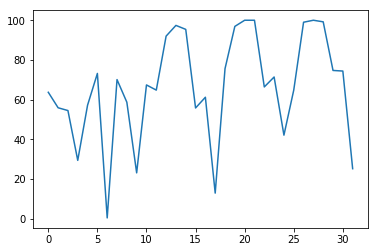

Episod:32, Step: 0, reward: 0.1
Episod:32, Step: 1, reward: 0.1
Episod:32, Step: 2, reward: 0.1
Episod:32, Step: 3, reward: 0.1
Episod:32, Step: 4, reward: 0.1
Episod:32, Step: 5, reward: 0.1
Episod:32, Step: 6, reward: 0.1
Episod:32, Step: 7, reward: 0.1
Episod:32, Step: 8, reward: 0.1
Episod:32, Step: 9, reward: 0.1
Episod:32, Step: 10, reward: 0.1
Episod:32, Step: 11, reward: 0.1
Episod:32, Step: 12, reward: 0.1
Episod:32, Step: 13, reward: 0.1
Episod:32, Step: 14, reward: 0.1
Episod:32, Step: 15, reward: 0.1
Episod:32, Step: 16, reward: 0.1
Episod:32, Step: 17, reward: 0.1
Episod:32, Step: 18, reward: 0.1
Episod:32, Step: 19, reward: 0.1
Episod:32, Step: 20, reward: 0.1
Episod:32, Step: 21, reward: 0.1
Episod:32, Step: 22, reward: 0.1
Episod:32, Step: 23, reward: 0.1
Episod:32, Step: 24, reward: 0.1
Episod:32, Step: 25, reward: 0.1
Episod:32, Step: 26, reward: 0.1
Episod:32, Step: 27, reward: 0.1
Episod:32, Step: 28, reward: 0.1
Episod:32, Step: 29, reward: 0.1
Episod:32, Step: 30,

Episod:32, Step: 261, reward: 0
Episod:32, Step: 262, reward: 0
Episod:32, Step: 263, reward: 0
Episod:32, Step: 264, reward: 0
Episod:32, Step: 265, reward: 0
Episod:32, Step: 266, reward: 0
Episod:32, Step: 267, reward: 0
Episod:32, Step: 268, reward: 0
Episod:32, Step: 269, reward: 0
Episod:32, Step: 270, reward: 0
Episod:32, Step: 271, reward: 0
Episod:32, Step: 272, reward: 0
Episod:32, Step: 273, reward: 0
Episod:32, Step: 274, reward: 0
Episod:32, Step: 275, reward: 0
Episod:32, Step: 276, reward: 0
Episod:32, Step: 277, reward: 0
Episod:32, Step: 278, reward: 0
Episod:32, Step: 279, reward: 0
Episod:32, Step: 280, reward: 0
Episod:32, Step: 281, reward: 0
Episod:32, Step: 282, reward: 0
Episod:32, Step: 283, reward: 0
Episod:32, Step: 284, reward: 0
Episod:32, Step: 285, reward: 0
Episod:32, Step: 286, reward: 0
Episod:32, Step: 287, reward: 0
Episod:32, Step: 288, reward: 0
Episod:32, Step: 289, reward: 0
Episod:32, Step: 290, reward: 0
Episod:32, Step: 291, reward: 0
Episod:3

Episod:32, Step: 522, reward: 0
Episod:32, Step: 523, reward: 0
Episod:32, Step: 524, reward: 0
Episod:32, Step: 525, reward: 0
Episod:32, Step: 526, reward: 0
Episod:32, Step: 527, reward: 0
Episod:32, Step: 528, reward: 0
Episod:32, Step: 529, reward: 0
Episod:32, Step: 530, reward: 0
Episod:32, Step: 531, reward: 0
Episod:32, Step: 532, reward: 0
Episod:32, Step: 533, reward: 0
Episod:32, Step: 534, reward: 0
Episod:32, Step: 535, reward: 0
Episod:32, Step: 536, reward: 0
Episod:32, Step: 537, reward: 0
Episod:32, Step: 538, reward: 0
Episod:32, Step: 539, reward: 0
Episod:32, Step: 540, reward: 0
Episod:32, Step: 541, reward: 0
Episod:32, Step: 542, reward: 0
Episod:32, Step: 543, reward: 0
Episod:32, Step: 544, reward: 0
Episod:32, Step: 545, reward: 0
Episod:32, Step: 546, reward: 0
Episod:32, Step: 547, reward: 0
Episod:32, Step: 548, reward: 0
Episod:32, Step: 549, reward: 0
Episod:32, Step: 550, reward: 0
Episod:32, Step: 551, reward: 0
Episod:32, Step: 552, reward: 0
Episod:3

Episod:32, Step: 786, reward: 0
Episod:32, Step: 787, reward: 0
Episod:32, Step: 788, reward: 0
Episod:32, Step: 789, reward: 0
Episod:32, Step: 790, reward: 0
Episod:32, Step: 791, reward: 0
Episod:32, Step: 792, reward: 0.1
Episod:32, Step: 793, reward: 0.1
Episod:32, Step: 794, reward: 0.1
Episod:32, Step: 795, reward: 0.1
Episod:32, Step: 796, reward: 0.1
Episod:32, Step: 797, reward: 0.1
Episod:32, Step: 798, reward: 0.1
Episod:32, Step: 799, reward: 0.1
Episod:32, Step: 800, reward: 0.1
Episod:32, Step: 801, reward: 0.1
Episod:32, Step: 802, reward: 0.1
Episod:32, Step: 803, reward: 0.1
Episod:32, Step: 804, reward: 0.1
Episod:32, Step: 805, reward: 0.1
Episod:32, Step: 806, reward: 0.1
Episod:32, Step: 807, reward: 0.1
Episod:32, Step: 808, reward: 0.1
Episod:32, Step: 809, reward: 0.1
Episod:32, Step: 810, reward: 0.1
Episod:32, Step: 811, reward: 0.1
Episod:32, Step: 812, reward: 0.1
Episod:32, Step: 813, reward: 0.1
Episod:32, Step: 814, reward: 0.1
Episod:32, Step: 815, rewa

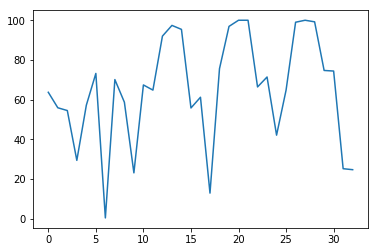

Episod:33, Step: 0, reward: 0.1
Episod:33, Step: 1, reward: 0.1
Episod:33, Step: 2, reward: 0.1
Episod:33, Step: 3, reward: 0.1
Episod:33, Step: 4, reward: 0.1
Episod:33, Step: 5, reward: 0.1
Episod:33, Step: 6, reward: 0.1
Episod:33, Step: 7, reward: 0.1
Episod:33, Step: 8, reward: 0.1
Episod:33, Step: 9, reward: 0.1
Episod:33, Step: 10, reward: 0.1
Episod:33, Step: 11, reward: 0.1
Episod:33, Step: 12, reward: 0.1
Episod:33, Step: 13, reward: 0.1
Episod:33, Step: 14, reward: 0.1
Episod:33, Step: 15, reward: 0.1
Episod:33, Step: 16, reward: 0.1
Episod:33, Step: 17, reward: 0.1
Episod:33, Step: 18, reward: 0.1
Episod:33, Step: 19, reward: 0.1
Episod:33, Step: 20, reward: 0.1
Episod:33, Step: 21, reward: 0.1
Episod:33, Step: 22, reward: 0.1
Episod:33, Step: 23, reward: 0.1
Episod:33, Step: 24, reward: 0.1
Episod:33, Step: 25, reward: 0.1
Episod:33, Step: 26, reward: 0.1
Episod:33, Step: 27, reward: 0.1
Episod:33, Step: 28, reward: 0.1
Episod:33, Step: 29, reward: 0.1
Episod:33, Step: 30,

Episod:33, Step: 249, reward: 0.1
Episod:33, Step: 250, reward: 0.1
Episod:33, Step: 251, reward: 0.1
Episod:33, Step: 252, reward: 0.1
Episod:33, Step: 253, reward: 0.1
Episod:33, Step: 254, reward: 0.1
Episod:33, Step: 255, reward: 0.1
Episod:33, Step: 256, reward: 0.1
Episod:33, Step: 257, reward: 0.1
Episod:33, Step: 258, reward: 0.1
Episod:33, Step: 259, reward: 0.1
Episod:33, Step: 260, reward: 0.1
Episod:33, Step: 261, reward: 0.1
Episod:33, Step: 262, reward: 0.1
Episod:33, Step: 263, reward: 0.1
Episod:33, Step: 264, reward: 0.1
Episod:33, Step: 265, reward: 0.1
Episod:33, Step: 266, reward: 0.1
Episod:33, Step: 267, reward: 0.1
Episod:33, Step: 268, reward: 0.1
Episod:33, Step: 269, reward: 0.1
Episod:33, Step: 270, reward: 0.1
Episod:33, Step: 271, reward: 0.1
Episod:33, Step: 272, reward: 0.1
Episod:33, Step: 273, reward: 0.1
Episod:33, Step: 274, reward: 0.1
Episod:33, Step: 275, reward: 0.1
Episod:33, Step: 276, reward: 0.1
Episod:33, Step: 277, reward: 0.1
Episod:33, Ste

Episod:33, Step: 492, reward: 0.1
Episod:33, Step: 493, reward: 0.1
Episod:33, Step: 494, reward: 0.1
Episod:33, Step: 495, reward: 0.1
Episod:33, Step: 496, reward: 0.1
Episod:33, Step: 497, reward: 0.1
Episod:33, Step: 498, reward: 0.1
Episod:33, Step: 499, reward: 0.1
Episod:33, Step: 500, reward: 0.1
Episod:33, Step: 501, reward: 0.1
Episod:33, Step: 502, reward: 0.1
Episod:33, Step: 503, reward: 0.1
Episod:33, Step: 504, reward: 0.1
Episod:33, Step: 505, reward: 0.1
Episod:33, Step: 506, reward: 0.1
Episod:33, Step: 507, reward: 0.1
Episod:33, Step: 508, reward: 0.1
Episod:33, Step: 509, reward: 0.1
Episod:33, Step: 510, reward: 0.1
Episod:33, Step: 511, reward: 0.1
Episod:33, Step: 512, reward: 0.1
Episod:33, Step: 513, reward: 0.1
Episod:33, Step: 514, reward: 0.1
Episod:33, Step: 515, reward: 0.1
Episod:33, Step: 516, reward: 0.1
Episod:33, Step: 517, reward: 0.1
Episod:33, Step: 518, reward: 0.1
Episod:33, Step: 519, reward: 0.1
Episod:33, Step: 520, reward: 0.1
Episod:33, Ste

Episod:33, Step: 745, reward: 0
Episod:33, Step: 746, reward: 0
Episod:33, Step: 747, reward: 0
Episod:33, Step: 748, reward: 0
Episod:33, Step: 749, reward: 0
Episod:33, Step: 750, reward: 0
Episod:33, Step: 751, reward: 0
Episod:33, Step: 752, reward: 0
Episod:33, Step: 753, reward: 0
Episod:33, Step: 754, reward: 0
Episod:33, Step: 755, reward: 0
Episod:33, Step: 756, reward: 0
Episod:33, Step: 757, reward: 0
Episod:33, Step: 758, reward: 0
Episod:33, Step: 759, reward: 0
Episod:33, Step: 760, reward: 0
Episod:33, Step: 761, reward: 0
Episod:33, Step: 762, reward: 0
Episod:33, Step: 763, reward: 0
Episod:33, Step: 764, reward: 0
Episod:33, Step: 765, reward: 0
Episod:33, Step: 766, reward: 0
Episod:33, Step: 767, reward: 0
Episod:33, Step: 768, reward: 0
Episod:33, Step: 769, reward: 0
Episod:33, Step: 770, reward: 0
Episod:33, Step: 771, reward: 0
Episod:33, Step: 772, reward: 0
Episod:33, Step: 773, reward: 0
Episod:33, Step: 774, reward: 0
Episod:33, Step: 775, reward: 0
Episod:3

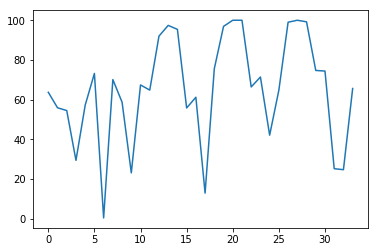

Episod:34, Step: 0, reward: 0
Episod:34, Step: 1, reward: 0
Episod:34, Step: 2, reward: 0
Episod:34, Step: 3, reward: 0
Episod:34, Step: 4, reward: 0
Episod:34, Step: 5, reward: 0
Episod:34, Step: 6, reward: 0
Episod:34, Step: 7, reward: 0
Episod:34, Step: 8, reward: 0
Episod:34, Step: 9, reward: 0
Episod:34, Step: 10, reward: 0
Episod:34, Step: 11, reward: 0
Episod:34, Step: 12, reward: 0
Episod:34, Step: 13, reward: 0
Episod:34, Step: 14, reward: 0
Episod:34, Step: 15, reward: 0
Episod:34, Step: 16, reward: 0
Episod:34, Step: 17, reward: 0
Episod:34, Step: 18, reward: 0
Episod:34, Step: 19, reward: 0
Episod:34, Step: 20, reward: 0
Episod:34, Step: 21, reward: 0
Episod:34, Step: 22, reward: 0
Episod:34, Step: 23, reward: 0
Episod:34, Step: 24, reward: 0
Episod:34, Step: 25, reward: 0
Episod:34, Step: 26, reward: 0
Episod:34, Step: 27, reward: 0
Episod:34, Step: 28, reward: 0
Episod:34, Step: 29, reward: 0
Episod:34, Step: 30, reward: 0
Episod:34, Step: 31, reward: 0
Episod:34, Step: 3

Episod:34, Step: 264, reward: 0
Episod:34, Step: 265, reward: 0
Episod:34, Step: 266, reward: 0
Episod:34, Step: 267, reward: 0
Episod:34, Step: 268, reward: 0
Episod:34, Step: 269, reward: 0
Episod:34, Step: 270, reward: 0
Episod:34, Step: 271, reward: 0
Episod:34, Step: 272, reward: 0
Episod:34, Step: 273, reward: 0
Episod:34, Step: 274, reward: 0
Episod:34, Step: 275, reward: 0
Episod:34, Step: 276, reward: 0
Episod:34, Step: 277, reward: 0
Episod:34, Step: 278, reward: 0
Episod:34, Step: 279, reward: 0
Episod:34, Step: 280, reward: 0
Episod:34, Step: 281, reward: 0
Episod:34, Step: 282, reward: 0
Episod:34, Step: 283, reward: 0
Episod:34, Step: 284, reward: 0
Episod:34, Step: 285, reward: 0
Episod:34, Step: 286, reward: 0
Episod:34, Step: 287, reward: 0
Episod:34, Step: 288, reward: 0
Episod:34, Step: 289, reward: 0
Episod:34, Step: 290, reward: 0
Episod:34, Step: 291, reward: 0
Episod:34, Step: 292, reward: 0
Episod:34, Step: 293, reward: 0
Episod:34, Step: 294, reward: 0
Episod:3

Episod:34, Step: 518, reward: 0.1
Episod:34, Step: 519, reward: 0.1
Episod:34, Step: 520, reward: 0.1
Episod:34, Step: 521, reward: 0.1
Episod:34, Step: 522, reward: 0.1
Episod:34, Step: 523, reward: 0.1
Episod:34, Step: 524, reward: 0.1
Episod:34, Step: 525, reward: 0.1
Episod:34, Step: 526, reward: 0.1
Episod:34, Step: 527, reward: 0.1
Episod:34, Step: 528, reward: 0.1
Episod:34, Step: 529, reward: 0.1
Episod:34, Step: 530, reward: 0.1
Episod:34, Step: 531, reward: 0.1
Episod:34, Step: 532, reward: 0.1
Episod:34, Step: 533, reward: 0.1
Episod:34, Step: 534, reward: 0.1
Episod:34, Step: 535, reward: 0.1
Episod:34, Step: 536, reward: 0.1
Episod:34, Step: 537, reward: 0.1
Episod:34, Step: 538, reward: 0.1
Episod:34, Step: 539, reward: 0.1
Episod:34, Step: 540, reward: 0.1
Episod:34, Step: 541, reward: 0.1
Episod:34, Step: 542, reward: 0.1
Episod:34, Step: 543, reward: 0.1
Episod:34, Step: 544, reward: 0.1
Episod:34, Step: 545, reward: 0.1
Episod:34, Step: 546, reward: 0.1
Episod:34, Ste

Episod:34, Step: 760, reward: 0.1
Episod:34, Step: 761, reward: 0.1
Episod:34, Step: 762, reward: 0.1
Episod:34, Step: 763, reward: 0.1
Episod:34, Step: 764, reward: 0.1
Episod:34, Step: 765, reward: 0.1
Episod:34, Step: 766, reward: 0.1
Episod:34, Step: 767, reward: 0.1
Episod:34, Step: 768, reward: 0.1
Episod:34, Step: 769, reward: 0.1
Episod:34, Step: 770, reward: 0.1
Episod:34, Step: 771, reward: 0.1
Episod:34, Step: 772, reward: 0.1
Episod:34, Step: 773, reward: 0.1
Episod:34, Step: 774, reward: 0.1
Episod:34, Step: 775, reward: 0.1
Episod:34, Step: 776, reward: 0.1
Episod:34, Step: 777, reward: 0.1
Episod:34, Step: 778, reward: 0.1
Episod:34, Step: 779, reward: 0.1
Episod:34, Step: 780, reward: 0.1
Episod:34, Step: 781, reward: 0.1
Episod:34, Step: 782, reward: 0.1
Episod:34, Step: 783, reward: 0.1
Episod:34, Step: 784, reward: 0.1
Episod:34, Step: 785, reward: 0.1
Episod:34, Step: 786, reward: 0.1
Episod:34, Step: 787, reward: 0.1
Episod:34, Step: 788, reward: 0.1
Episod:34, Ste

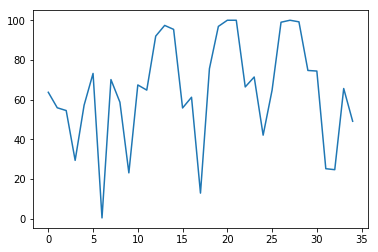

Episod:35, Step: 0, reward: 0
Episod:35, Step: 1, reward: 0
Episod:35, Step: 2, reward: 0
Episod:35, Step: 3, reward: 0
Episod:35, Step: 4, reward: 0
Episod:35, Step: 5, reward: 0
Episod:35, Step: 6, reward: 0
Episod:35, Step: 7, reward: 0
Episod:35, Step: 8, reward: 0
Episod:35, Step: 9, reward: 0
Episod:35, Step: 10, reward: 0
Episod:35, Step: 11, reward: 0
Episod:35, Step: 12, reward: 0
Episod:35, Step: 13, reward: 0
Episod:35, Step: 14, reward: 0
Episod:35, Step: 15, reward: 0
Episod:35, Step: 16, reward: 0
Episod:35, Step: 17, reward: 0
Episod:35, Step: 18, reward: 0
Episod:35, Step: 19, reward: 0
Episod:35, Step: 20, reward: 0
Episod:35, Step: 21, reward: 0
Episod:35, Step: 22, reward: 0
Episod:35, Step: 23, reward: 0
Episod:35, Step: 24, reward: 0
Episod:35, Step: 25, reward: 0
Episod:35, Step: 26, reward: 0
Episod:35, Step: 27, reward: 0
Episod:35, Step: 28, reward: 0
Episod:35, Step: 29, reward: 0
Episod:35, Step: 30, reward: 0
Episod:35, Step: 31, reward: 0
Episod:35, Step: 3

Episod:35, Step: 263, reward: 0
Episod:35, Step: 264, reward: 0
Episod:35, Step: 265, reward: 0
Episod:35, Step: 266, reward: 0
Episod:35, Step: 267, reward: 0
Episod:35, Step: 268, reward: 0
Episod:35, Step: 269, reward: 0
Episod:35, Step: 270, reward: 0
Episod:35, Step: 271, reward: 0
Episod:35, Step: 272, reward: 0
Episod:35, Step: 273, reward: 0
Episod:35, Step: 274, reward: 0
Episod:35, Step: 275, reward: 0
Episod:35, Step: 276, reward: 0
Episod:35, Step: 277, reward: 0
Episod:35, Step: 278, reward: 0
Episod:35, Step: 279, reward: 0
Episod:35, Step: 280, reward: 0
Episod:35, Step: 281, reward: 0
Episod:35, Step: 282, reward: 0
Episod:35, Step: 283, reward: 0
Episod:35, Step: 284, reward: 0
Episod:35, Step: 285, reward: 0
Episod:35, Step: 286, reward: 0
Episod:35, Step: 287, reward: 0
Episod:35, Step: 288, reward: 0
Episod:35, Step: 289, reward: 0
Episod:35, Step: 290, reward: 0
Episod:35, Step: 291, reward: 0
Episod:35, Step: 292, reward: 0
Episod:35, Step: 293, reward: 0
Episod:3

Episod:35, Step: 525, reward: 0
Episod:35, Step: 526, reward: 0
Episod:35, Step: 527, reward: 0
Episod:35, Step: 528, reward: 0
Episod:35, Step: 529, reward: 0
Episod:35, Step: 530, reward: 0
Episod:35, Step: 531, reward: 0
Episod:35, Step: 532, reward: 0
Episod:35, Step: 533, reward: 0
Episod:35, Step: 534, reward: 0
Episod:35, Step: 535, reward: 0
Episod:35, Step: 536, reward: 0
Episod:35, Step: 537, reward: 0
Episod:35, Step: 538, reward: 0
Episod:35, Step: 539, reward: 0
Episod:35, Step: 540, reward: 0
Episod:35, Step: 541, reward: 0
Episod:35, Step: 542, reward: 0
Episod:35, Step: 543, reward: 0
Episod:35, Step: 544, reward: 0
Episod:35, Step: 545, reward: 0
Episod:35, Step: 546, reward: 0
Episod:35, Step: 547, reward: 0
Episod:35, Step: 548, reward: 0
Episod:35, Step: 549, reward: 0
Episod:35, Step: 550, reward: 0
Episod:35, Step: 551, reward: 0
Episod:35, Step: 552, reward: 0
Episod:35, Step: 553, reward: 0
Episod:35, Step: 554, reward: 0
Episod:35, Step: 555, reward: 0
Episod:3

Episod:35, Step: 789, reward: 0
Episod:35, Step: 790, reward: 0
Episod:35, Step: 791, reward: 0
Episod:35, Step: 792, reward: 0
Episod:35, Step: 793, reward: 0
Episod:35, Step: 794, reward: 0
Episod:35, Step: 795, reward: 0
Episod:35, Step: 796, reward: 0
Episod:35, Step: 797, reward: 0
Episod:35, Step: 798, reward: 0
Episod:35, Step: 799, reward: 0
Episod:35, Step: 800, reward: 0
Episod:35, Step: 801, reward: 0
Episod:35, Step: 802, reward: 0
Episod:35, Step: 803, reward: 0
Episod:35, Step: 804, reward: 0
Episod:35, Step: 805, reward: 0
Episod:35, Step: 806, reward: 0
Episod:35, Step: 807, reward: 0
Episod:35, Step: 808, reward: 0
Episod:35, Step: 809, reward: 0
Episod:35, Step: 810, reward: 0
Episod:35, Step: 811, reward: 0
Episod:35, Step: 812, reward: 0
Episod:35, Step: 813, reward: 0
Episod:35, Step: 814, reward: 0
Episod:35, Step: 815, reward: 0
Episod:35, Step: 816, reward: 0
Episod:35, Step: 817, reward: 0
Episod:35, Step: 818, reward: 0
Episod:35, Step: 819, reward: 0
Episod:3

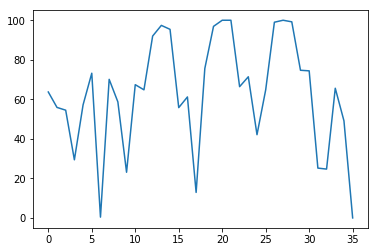

Episod:36, Step: 0, reward: 0
Episod:36, Step: 1, reward: 0
Episod:36, Step: 2, reward: 0
Episod:36, Step: 3, reward: 0
Episod:36, Step: 4, reward: 0
Episod:36, Step: 5, reward: 0
Episod:36, Step: 6, reward: 0
Episod:36, Step: 7, reward: 0
Episod:36, Step: 8, reward: 0
Episod:36, Step: 9, reward: 0
Episod:36, Step: 10, reward: 0
Episod:36, Step: 11, reward: 0
Episod:36, Step: 12, reward: 0
Episod:36, Step: 13, reward: 0
Episod:36, Step: 14, reward: 0
Episod:36, Step: 15, reward: 0
Episod:36, Step: 16, reward: 0
Episod:36, Step: 17, reward: 0
Episod:36, Step: 18, reward: 0
Episod:36, Step: 19, reward: 0
Episod:36, Step: 20, reward: 0
Episod:36, Step: 21, reward: 0
Episod:36, Step: 22, reward: 0
Episod:36, Step: 23, reward: 0
Episod:36, Step: 24, reward: 0
Episod:36, Step: 25, reward: 0
Episod:36, Step: 26, reward: 0
Episod:36, Step: 27, reward: 0
Episod:36, Step: 28, reward: 0
Episod:36, Step: 29, reward: 0
Episod:36, Step: 30, reward: 0
Episod:36, Step: 31, reward: 0
Episod:36, Step: 3

Episod:36, Step: 260, reward: 0
Episod:36, Step: 261, reward: 0
Episod:36, Step: 262, reward: 0
Episod:36, Step: 263, reward: 0
Episod:36, Step: 264, reward: 0
Episod:36, Step: 265, reward: 0
Episod:36, Step: 266, reward: 0
Episod:36, Step: 267, reward: 0
Episod:36, Step: 268, reward: 0
Episod:36, Step: 269, reward: 0
Episod:36, Step: 270, reward: 0
Episod:36, Step: 271, reward: 0
Episod:36, Step: 272, reward: 0
Episod:36, Step: 273, reward: 0
Episod:36, Step: 274, reward: 0
Episod:36, Step: 275, reward: 0
Episod:36, Step: 276, reward: 0
Episod:36, Step: 277, reward: 0
Episod:36, Step: 278, reward: 0
Episod:36, Step: 279, reward: 0
Episod:36, Step: 280, reward: 0
Episod:36, Step: 281, reward: 0
Episod:36, Step: 282, reward: 0
Episod:36, Step: 283, reward: 0
Episod:36, Step: 284, reward: 0
Episod:36, Step: 285, reward: 0
Episod:36, Step: 286, reward: 0
Episod:36, Step: 287, reward: 0
Episod:36, Step: 288, reward: 0
Episod:36, Step: 289, reward: 0
Episod:36, Step: 290, reward: 0
Episod:3

Episod:36, Step: 517, reward: 0
Episod:36, Step: 518, reward: 0
Episod:36, Step: 519, reward: 0
Episod:36, Step: 520, reward: 0
Episod:36, Step: 521, reward: 0
Episod:36, Step: 522, reward: 0
Episod:36, Step: 523, reward: 0
Episod:36, Step: 524, reward: 0
Episod:36, Step: 525, reward: 0
Episod:36, Step: 526, reward: 0
Episod:36, Step: 527, reward: 0
Episod:36, Step: 528, reward: 0
Episod:36, Step: 529, reward: 0
Episod:36, Step: 530, reward: 0
Episod:36, Step: 531, reward: 0
Episod:36, Step: 532, reward: 0
Episod:36, Step: 533, reward: 0
Episod:36, Step: 534, reward: 0
Episod:36, Step: 535, reward: 0
Episod:36, Step: 536, reward: 0
Episod:36, Step: 537, reward: 0
Episod:36, Step: 538, reward: 0
Episod:36, Step: 539, reward: 0
Episod:36, Step: 540, reward: 0
Episod:36, Step: 541, reward: 0
Episod:36, Step: 542, reward: 0
Episod:36, Step: 543, reward: 0
Episod:36, Step: 544, reward: 0
Episod:36, Step: 545, reward: 0
Episod:36, Step: 546, reward: 0
Episod:36, Step: 547, reward: 0
Episod:3

Episod:36, Step: 774, reward: 0
Episod:36, Step: 775, reward: 0
Episod:36, Step: 776, reward: 0
Episod:36, Step: 777, reward: 0
Episod:36, Step: 778, reward: 0
Episod:36, Step: 779, reward: 0
Episod:36, Step: 780, reward: 0
Episod:36, Step: 781, reward: 0
Episod:36, Step: 782, reward: 0
Episod:36, Step: 783, reward: 0
Episod:36, Step: 784, reward: 0
Episod:36, Step: 785, reward: 0
Episod:36, Step: 786, reward: 0
Episod:36, Step: 787, reward: 0
Episod:36, Step: 788, reward: 0
Episod:36, Step: 789, reward: 0
Episod:36, Step: 790, reward: 0
Episod:36, Step: 791, reward: 0
Episod:36, Step: 792, reward: 0
Episod:36, Step: 793, reward: 0
Episod:36, Step: 794, reward: 0
Episod:36, Step: 795, reward: 0
Episod:36, Step: 796, reward: 0
Episod:36, Step: 797, reward: 0
Episod:36, Step: 798, reward: 0
Episod:36, Step: 799, reward: 0
Episod:36, Step: 800, reward: 0
Episod:36, Step: 801, reward: 0
Episod:36, Step: 802, reward: 0
Episod:36, Step: 803, reward: 0
Episod:36, Step: 804, reward: 0
Episod:3

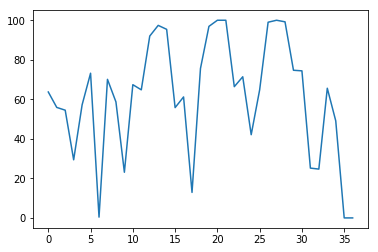

Episod:37, Step: 0, reward: 0
Episod:37, Step: 1, reward: 0
Episod:37, Step: 2, reward: 0
Episod:37, Step: 3, reward: 0
Episod:37, Step: 4, reward: 0
Episod:37, Step: 5, reward: 0
Episod:37, Step: 6, reward: 0
Episod:37, Step: 7, reward: 0
Episod:37, Step: 8, reward: 0
Episod:37, Step: 9, reward: 0
Episod:37, Step: 10, reward: 0
Episod:37, Step: 11, reward: 0
Episod:37, Step: 12, reward: 0
Episod:37, Step: 13, reward: 0
Episod:37, Step: 14, reward: 0
Episod:37, Step: 15, reward: 0
Episod:37, Step: 16, reward: 0
Episod:37, Step: 17, reward: 0
Episod:37, Step: 18, reward: 0
Episod:37, Step: 19, reward: 0
Episod:37, Step: 20, reward: 0
Episod:37, Step: 21, reward: 0
Episod:37, Step: 22, reward: 0
Episod:37, Step: 23, reward: 0
Episod:37, Step: 24, reward: 0
Episod:37, Step: 25, reward: 0
Episod:37, Step: 26, reward: 0
Episod:37, Step: 27, reward: 0
Episod:37, Step: 28, reward: 0
Episod:37, Step: 29, reward: 0
Episod:37, Step: 30, reward: 0
Episod:37, Step: 31, reward: 0
Episod:37, Step: 3

Episod:37, Step: 260, reward: 0
Episod:37, Step: 261, reward: 0
Episod:37, Step: 262, reward: 0
Episod:37, Step: 263, reward: 0
Episod:37, Step: 264, reward: 0
Episod:37, Step: 265, reward: 0
Episod:37, Step: 266, reward: 0
Episod:37, Step: 267, reward: 0
Episod:37, Step: 268, reward: 0
Episod:37, Step: 269, reward: 0
Episod:37, Step: 270, reward: 0
Episod:37, Step: 271, reward: 0
Episod:37, Step: 272, reward: 0
Episod:37, Step: 273, reward: 0
Episod:37, Step: 274, reward: 0
Episod:37, Step: 275, reward: 0
Episod:37, Step: 276, reward: 0
Episod:37, Step: 277, reward: 0
Episod:37, Step: 278, reward: 0
Episod:37, Step: 279, reward: 0
Episod:37, Step: 280, reward: 0
Episod:37, Step: 281, reward: 0
Episod:37, Step: 282, reward: 0
Episod:37, Step: 283, reward: 0
Episod:37, Step: 284, reward: 0
Episod:37, Step: 285, reward: 0
Episod:37, Step: 286, reward: 0
Episod:37, Step: 287, reward: 0
Episod:37, Step: 288, reward: 0
Episod:37, Step: 289, reward: 0
Episod:37, Step: 290, reward: 0
Episod:3

Episod:37, Step: 517, reward: 0
Episod:37, Step: 518, reward: 0
Episod:37, Step: 519, reward: 0
Episod:37, Step: 520, reward: 0
Episod:37, Step: 521, reward: 0
Episod:37, Step: 522, reward: 0
Episod:37, Step: 523, reward: 0
Episod:37, Step: 524, reward: 0
Episod:37, Step: 525, reward: 0
Episod:37, Step: 526, reward: 0
Episod:37, Step: 527, reward: 0
Episod:37, Step: 528, reward: 0
Episod:37, Step: 529, reward: 0
Episod:37, Step: 530, reward: 0
Episod:37, Step: 531, reward: 0
Episod:37, Step: 532, reward: 0
Episod:37, Step: 533, reward: 0
Episod:37, Step: 534, reward: 0
Episod:37, Step: 535, reward: 0
Episod:37, Step: 536, reward: 0
Episod:37, Step: 537, reward: 0
Episod:37, Step: 538, reward: 0
Episod:37, Step: 539, reward: 0
Episod:37, Step: 540, reward: 0
Episod:37, Step: 541, reward: 0
Episod:37, Step: 542, reward: 0
Episod:37, Step: 543, reward: 0
Episod:37, Step: 544, reward: 0
Episod:37, Step: 545, reward: 0
Episod:37, Step: 546, reward: 0
Episod:37, Step: 547, reward: 0
Episod:3

Episod:37, Step: 774, reward: 0
Episod:37, Step: 775, reward: 0
Episod:37, Step: 776, reward: 0
Episod:37, Step: 777, reward: 0
Episod:37, Step: 778, reward: 0
Episod:37, Step: 779, reward: 0
Episod:37, Step: 780, reward: 0
Episod:37, Step: 781, reward: 0
Episod:37, Step: 782, reward: 0
Episod:37, Step: 783, reward: 0
Episod:37, Step: 784, reward: 0
Episod:37, Step: 785, reward: 0
Episod:37, Step: 786, reward: 0
Episod:37, Step: 787, reward: 0
Episod:37, Step: 788, reward: 0
Episod:37, Step: 789, reward: 0
Episod:37, Step: 790, reward: 0
Episod:37, Step: 791, reward: 0
Episod:37, Step: 792, reward: 0
Episod:37, Step: 793, reward: 0
Episod:37, Step: 794, reward: 0
Episod:37, Step: 795, reward: 0
Episod:37, Step: 796, reward: 0
Episod:37, Step: 797, reward: 0
Episod:37, Step: 798, reward: 0
Episod:37, Step: 799, reward: 0
Episod:37, Step: 800, reward: 0
Episod:37, Step: 801, reward: 0
Episod:37, Step: 802, reward: 0
Episod:37, Step: 803, reward: 0
Episod:37, Step: 804, reward: 0
Episod:3

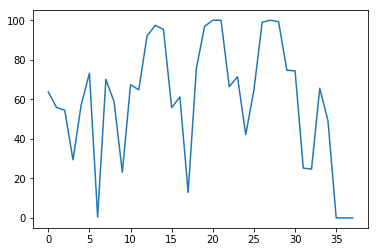

Episod:38, Step: 0, reward: 0
Episod:38, Step: 1, reward: 0
Episod:38, Step: 2, reward: 0
Episod:38, Step: 3, reward: 0
Episod:38, Step: 4, reward: 0
Episod:38, Step: 5, reward: 0
Episod:38, Step: 6, reward: 0
Episod:38, Step: 7, reward: 0
Episod:38, Step: 8, reward: 0
Episod:38, Step: 9, reward: 0
Episod:38, Step: 10, reward: 0
Episod:38, Step: 11, reward: 0
Episod:38, Step: 12, reward: 0
Episod:38, Step: 13, reward: 0
Episod:38, Step: 14, reward: 0
Episod:38, Step: 15, reward: 0
Episod:38, Step: 16, reward: 0
Episod:38, Step: 17, reward: 0
Episod:38, Step: 18, reward: 0
Episod:38, Step: 19, reward: 0
Episod:38, Step: 20, reward: 0
Episod:38, Step: 21, reward: 0
Episod:38, Step: 22, reward: 0
Episod:38, Step: 23, reward: 0
Episod:38, Step: 24, reward: 0
Episod:38, Step: 25, reward: 0
Episod:38, Step: 26, reward: 0
Episod:38, Step: 27, reward: 0
Episod:38, Step: 28, reward: 0
Episod:38, Step: 29, reward: 0
Episod:38, Step: 30, reward: 0
Episod:38, Step: 31, reward: 0
Episod:38, Step: 3

Episod:38, Step: 260, reward: 0
Episod:38, Step: 261, reward: 0
Episod:38, Step: 262, reward: 0
Episod:38, Step: 263, reward: 0
Episod:38, Step: 264, reward: 0
Episod:38, Step: 265, reward: 0
Episod:38, Step: 266, reward: 0
Episod:38, Step: 267, reward: 0
Episod:38, Step: 268, reward: 0
Episod:38, Step: 269, reward: 0
Episod:38, Step: 270, reward: 0
Episod:38, Step: 271, reward: 0
Episod:38, Step: 272, reward: 0
Episod:38, Step: 273, reward: 0
Episod:38, Step: 274, reward: 0
Episod:38, Step: 275, reward: 0
Episod:38, Step: 276, reward: 0
Episod:38, Step: 277, reward: 0
Episod:38, Step: 278, reward: 0
Episod:38, Step: 279, reward: 0
Episod:38, Step: 280, reward: 0
Episod:38, Step: 281, reward: 0
Episod:38, Step: 282, reward: 0
Episod:38, Step: 283, reward: 0
Episod:38, Step: 284, reward: 0
Episod:38, Step: 285, reward: 0
Episod:38, Step: 286, reward: 0
Episod:38, Step: 287, reward: 0
Episod:38, Step: 288, reward: 0
Episod:38, Step: 289, reward: 0
Episod:38, Step: 290, reward: 0
Episod:3

Episod:38, Step: 517, reward: 0
Episod:38, Step: 518, reward: 0
Episod:38, Step: 519, reward: 0
Episod:38, Step: 520, reward: 0
Episod:38, Step: 521, reward: 0
Episod:38, Step: 522, reward: 0
Episod:38, Step: 523, reward: 0
Episod:38, Step: 524, reward: 0
Episod:38, Step: 525, reward: 0
Episod:38, Step: 526, reward: 0
Episod:38, Step: 527, reward: 0
Episod:38, Step: 528, reward: 0
Episod:38, Step: 529, reward: 0
Episod:38, Step: 530, reward: 0
Episod:38, Step: 531, reward: 0
Episod:38, Step: 532, reward: 0
Episod:38, Step: 533, reward: 0
Episod:38, Step: 534, reward: 0
Episod:38, Step: 535, reward: 0
Episod:38, Step: 536, reward: 0
Episod:38, Step: 537, reward: 0
Episod:38, Step: 538, reward: 0
Episod:38, Step: 539, reward: 0
Episod:38, Step: 540, reward: 0
Episod:38, Step: 541, reward: 0
Episod:38, Step: 542, reward: 0
Episod:38, Step: 543, reward: 0
Episod:38, Step: 544, reward: 0
Episod:38, Step: 545, reward: 0
Episod:38, Step: 546, reward: 0
Episod:38, Step: 547, reward: 0
Episod:3

Episod:38, Step: 774, reward: 0
Episod:38, Step: 775, reward: 0
Episod:38, Step: 776, reward: 0
Episod:38, Step: 777, reward: 0
Episod:38, Step: 778, reward: 0
Episod:38, Step: 779, reward: 0
Episod:38, Step: 780, reward: 0
Episod:38, Step: 781, reward: 0
Episod:38, Step: 782, reward: 0
Episod:38, Step: 783, reward: 0
Episod:38, Step: 784, reward: 0
Episod:38, Step: 785, reward: 0
Episod:38, Step: 786, reward: 0
Episod:38, Step: 787, reward: 0
Episod:38, Step: 788, reward: 0
Episod:38, Step: 789, reward: 0
Episod:38, Step: 790, reward: 0
Episod:38, Step: 791, reward: 0
Episod:38, Step: 792, reward: 0
Episod:38, Step: 793, reward: 0
Episod:38, Step: 794, reward: 0
Episod:38, Step: 795, reward: 0
Episod:38, Step: 796, reward: 0
Episod:38, Step: 797, reward: 0
Episod:38, Step: 798, reward: 0
Episod:38, Step: 799, reward: 0
Episod:38, Step: 800, reward: 0
Episod:38, Step: 801, reward: 0
Episod:38, Step: 802, reward: 0
Episod:38, Step: 803, reward: 0
Episod:38, Step: 804, reward: 0
Episod:3

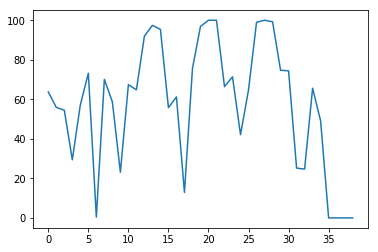

Episod:39, Step: 0, reward: 0
Episod:39, Step: 1, reward: 0
Episod:39, Step: 2, reward: 0
Episod:39, Step: 3, reward: 0
Episod:39, Step: 4, reward: 0
Episod:39, Step: 5, reward: 0
Episod:39, Step: 6, reward: 0
Episod:39, Step: 7, reward: 0
Episod:39, Step: 8, reward: 0
Episod:39, Step: 9, reward: 0
Episod:39, Step: 10, reward: 0
Episod:39, Step: 11, reward: 0
Episod:39, Step: 12, reward: 0
Episod:39, Step: 13, reward: 0
Episod:39, Step: 14, reward: 0
Episod:39, Step: 15, reward: 0
Episod:39, Step: 16, reward: 0
Episod:39, Step: 17, reward: 0
Episod:39, Step: 18, reward: 0
Episod:39, Step: 19, reward: 0
Episod:39, Step: 20, reward: 0
Episod:39, Step: 21, reward: 0
Episod:39, Step: 22, reward: 0
Episod:39, Step: 23, reward: 0
Episod:39, Step: 24, reward: 0
Episod:39, Step: 25, reward: 0
Episod:39, Step: 26, reward: 0
Episod:39, Step: 27, reward: 0
Episod:39, Step: 28, reward: 0
Episod:39, Step: 29, reward: 0
Episod:39, Step: 30, reward: 0
Episod:39, Step: 31, reward: 0
Episod:39, Step: 3

Episod:39, Step: 260, reward: 0
Episod:39, Step: 261, reward: 0
Episod:39, Step: 262, reward: 0
Episod:39, Step: 263, reward: 0
Episod:39, Step: 264, reward: 0
Episod:39, Step: 265, reward: 0
Episod:39, Step: 266, reward: 0
Episod:39, Step: 267, reward: 0
Episod:39, Step: 268, reward: 0
Episod:39, Step: 269, reward: 0
Episod:39, Step: 270, reward: 0
Episod:39, Step: 271, reward: 0
Episod:39, Step: 272, reward: 0
Episod:39, Step: 273, reward: 0
Episod:39, Step: 274, reward: 0
Episod:39, Step: 275, reward: 0
Episod:39, Step: 276, reward: 0
Episod:39, Step: 277, reward: 0
Episod:39, Step: 278, reward: 0
Episod:39, Step: 279, reward: 0
Episod:39, Step: 280, reward: 0
Episod:39, Step: 281, reward: 0
Episod:39, Step: 282, reward: 0
Episod:39, Step: 283, reward: 0
Episod:39, Step: 284, reward: 0
Episod:39, Step: 285, reward: 0
Episod:39, Step: 286, reward: 0
Episod:39, Step: 287, reward: 0
Episod:39, Step: 288, reward: 0
Episod:39, Step: 289, reward: 0
Episod:39, Step: 290, reward: 0
Episod:3

Episod:39, Step: 517, reward: 0
Episod:39, Step: 518, reward: 0
Episod:39, Step: 519, reward: 0
Episod:39, Step: 520, reward: 0
Episod:39, Step: 521, reward: 0
Episod:39, Step: 522, reward: 0
Episod:39, Step: 523, reward: 0
Episod:39, Step: 524, reward: 0
Episod:39, Step: 525, reward: 0
Episod:39, Step: 526, reward: 0
Episod:39, Step: 527, reward: 0
Episod:39, Step: 528, reward: 0
Episod:39, Step: 529, reward: 0
Episod:39, Step: 530, reward: 0
Episod:39, Step: 531, reward: 0
Episod:39, Step: 532, reward: 0
Episod:39, Step: 533, reward: 0
Episod:39, Step: 534, reward: 0
Episod:39, Step: 535, reward: 0
Episod:39, Step: 536, reward: 0
Episod:39, Step: 537, reward: 0
Episod:39, Step: 538, reward: 0
Episod:39, Step: 539, reward: 0
Episod:39, Step: 540, reward: 0
Episod:39, Step: 541, reward: 0
Episod:39, Step: 542, reward: 0
Episod:39, Step: 543, reward: 0
Episod:39, Step: 544, reward: 0
Episod:39, Step: 545, reward: 0
Episod:39, Step: 546, reward: 0
Episod:39, Step: 547, reward: 0
Episod:3

KeyboardInterrupt: 

In [6]:
with tf.Session() as sess:

    #env = gym.make('Pendulum-v0')
    #env = gym.make('MountainCarContinuous-v0')
    env = LASEnv('127.0.0.1', 19997)

    LASAgent = LASAgent_Actor_Critic(sess, env)

    LASAgent.train()

    #env.destroy()

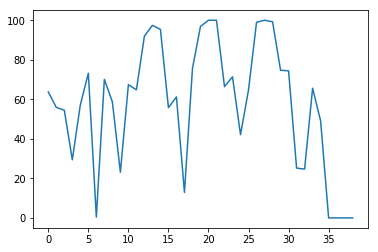

In [7]:
plot_cumulative_reward(LASAgent.episod_reward_memory)

In [8]:
env.destroy()